## **Mastery Project: Travel Tide**

### **Project Insights & Objective Summary:**

TravelTide is a rapidly growing e-booking startup known for offering the largest travel inventory in the industry. Its strong search and data aggregation technology helped it scale quickly after launching in 2021.

However, this intense focus on inventory has come at a cost: customer experience and retention remain weak. To address this, TravelTide’s leadership aims to improve loyalty through a more personalized, data-driven rewards program.

#### **Project Goal**

The objective of this project is to strengthen TravelTide’s rewards program by analyzing customer demographics, browsing behavior, and booking patterns. The goal is to identify meaningful customer segments and determine which perks each group values most, enabling precise and effective marketing personalization that improves engagement and retention.

#### **Project Workflow**

This project follows a structured analytical process:
- Data cleaning & preparation
- Exploratory analysis
- Feature engineering
- Segmentation modeling
- Insights & recommendations

#### 1.1 Importing Required Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

#### 1.2 Connecting to Database & Loading Tables into Spark DataFrames

In [0]:
# Database connection URL
traveltide_url = "jdbc:postgresql://ep-noisy-flower-846766.us-east-2.aws.neon.tech/TravelTide"

# Database connection properties
properties = {
    "user": "Test"
    , "password": "bQNxVzJL4g6u"
    , "driver": "org.postgresql.Driver"
}

# Load PostgreSQL table metadata into a Spark DataFrame
traveltide_metadata = spark.read.jdbc(
    url=traveltide_url
    , table="information_schema.tables"
    , properties=properties
)

# Filter to user-defined tables in the 'public' schema
table_names = traveltide_metadata.filter(traveltide_metadata.table_schema == "public")

# Show table names
table_names.select("table_name").show(truncate=False)

+----------+
|table_name|
+----------+
|sessions  |
|flights   |
|users     |
|hotels    |
+----------+



In [0]:
# Create reusable function to load tables into Spark DataFrames
def load_and_inspect_table(table_name):
  # Return table as Spark DataFrame
  spark_df = spark.read.jdbc(
    url=traveltide_url
    , table=table_name
    , properties=properties
  )

  # Inspect shape of DataFrame
  print(f"{table_name.upper()} SHAPE:")
  print(f"Column: ", len(spark_df.columns))
  print(f"Row: ", spark_df.count())
  
  # Show DataFrame column names
  print(f"\n{table_name.upper()} COLUMN NAMES:")
  print(spark_df.columns)
  
  return spark_df

#### 1.3 Exploring the Tables

In [0]:
sessions_spark = load_and_inspect_table("sessions")

SESSIONS SHAPE:
Column:  13
Row:  5408063

SESSIONS COLUMN NAMES:
['session_id', 'user_id', 'trip_id', 'session_start', 'session_end', 'flight_discount', 'hotel_discount', 'flight_discount_amount', 'hotel_discount_amount', 'flight_booked', 'hotel_booked', 'page_clicks', 'cancellation']


In [0]:
flights_spark = load_and_inspect_table("flights")

FLIGHTS SHAPE:
Column:  13
Row:  1901038

FLIGHTS COLUMN NAMES:
['trip_id', 'origin_airport', 'destination', 'destination_airport', 'seats', 'return_flight_booked', 'departure_time', 'return_time', 'checked_bags', 'trip_airline', 'destination_airport_lat', 'destination_airport_lon', 'base_fare_usd']


In [0]:
users_spark = load_and_inspect_table("users")

USERS SHAPE:
Column:  11
Row:  1020926

USERS COLUMN NAMES:
['user_id', 'birthdate', 'gender', 'married', 'has_children', 'home_country', 'home_city', 'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date']


In [0]:
hotels_spark = load_and_inspect_table("hotels")

HOTELS SHAPE:
Column:  7
Row:  1918617

HOTELS COLUMN NAMES:
['trip_id', 'hotel_name', 'nights', 'rooms', 'check_in_time', 'check_out_time', 'hotel_per_room_usd']


#### 1.4 Filtering Data via using SQL

In [0]:
# Return filtered sql dataset as a Spark DataFrame
filtered_sessions_spark = spark.sql("""
WITH
  -- Filter sessions that started after 2023-01-04
  filtered_sessions AS (
    SELECT *
    FROM sessions_spark
    WHERE session_start > '2023-01-04'
    ),
  -- Identify users with more than 7 sessions
  filtered_users AS (
    SELECT
      user_id
      , COUNT(*) AS session_count
    FROM filtered_sessions
    GROUP BY user_id
    HAVING COUNT(*) > 7
    ),
  -- Join filtered sessions with users, flights, and hotels for identified users
  session_base AS (
    SELECT
      -- Columns from "sessions" table
      s.session_id
      , s.user_id
      , s.trip_id
      , s.session_start
      , s.session_end
      , s.page_clicks
      , s.flight_discount
      , s.flight_discount_amount
      , s.flight_booked
      , s.hotel_discount
      , s.hotel_discount_amount
      , s.hotel_booked
      , s.cancellation

      -- Columns from "users" table
      , u.birthdate
      , u.gender
      , u.married
      , u.has_children
      , u.home_country
      , u.home_city
      , u.home_airport
      , u.home_airport_lat
      , u.home_airport_lon
      , u.sign_up_date

      -- Columns from "flights" table
      , f.origin_airport
      , f.destination
      , f.destination_airport
      , f.seats
      , f.return_flight_booked
      , f.departure_time
      , f.return_time
      , f.checked_bags
      , f.trip_airline
      , f.destination_airport_lat
      , f.destination_airport_lon
      , f.base_fare_usd 

      -- Columns from "hotels" table
      , h.hotel_name
      , h.nights
      , h.rooms
      , h.check_in_time
      , h.check_out_time
      , h.hotel_per_room_usd AS hotel_base_nightly_rate_usd

    FROM filtered_sessions s
    INNER JOIN users_spark u ON s.user_id = u.user_id
    LEFT JOIN flights_spark f ON s.trip_id = f.trip_id
    LEFT JOIN hotels_spark h ON s.trip_id = h.trip_id
    WHERE s.user_id IN (
      SELECT user_id
      FROM filtered_users
      )
    )
SELECT *
FROM session_base
""")

# Convert Spark DataFrame to Pandas DataFrame
filtered_sessions_pd = filtered_sessions_spark.toPandas() #Not by users

In [0]:
# Preview of the Filtered Sessions Table

filtered_sessions_pd.head()

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,flight_booked,hotel_discount,hotel_discount_amount,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_base_nightly_rate_usd
0,509635-08ddac6e534e4c32864b82b588bfc4c2,509635,509635-ce74796962f7482f94cdf4c1e4ea2f09,2023-07-20 15:28:00,2023-07-20 15:30:17,18,False,NaN,True,False,NaN,True,False,1986-12-13,M,True,False,usa,austin,AUS,30.194,-97.670,2023-01-04,AUS,new york,JFK,1.0,False,2023-07-29 07:00:00,NaT,0.0,Delta Air Lines,40.640,-73.779,198.27,Four Seasons - new york,1.0,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,154.0
1,554269-341890533eec4585bf917de647933f76,554269,554269-396c10d3be7644d098b13800c63b3fba,2023-07-20 04:02:00,2023-07-20 04:04:54,24,False,NaN,True,False,NaN,True,False,1976-05-26,F,True,True,usa,san diego,SAN,32.733,-117.189,2023-01-26,SAN,toronto,YZD,1.0,True,2023-07-25 07:00:00,2023-07-30 07:00:00,1.0,American Airlines,43.862,-79.370,581.41,Wyndham - toronto,4.0,1.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,49.0
2,564430-316ae3c06f0a43e98a122d494eea2a1d,564430,564430-d0ea8f6af2b841faa83d706d494a61fc,2023-07-20 02:23:00,2023-07-20 02:25:35,21,False,NaN,True,True,0.1,True,False,1981-09-09,F,False,True,canada,hamilton,YHM,43.173,-79.935,2023-01-31,YHM,calgary,YYC,1.0,True,2023-07-25 14:00:00,2023-08-01 14:00:00,1.0,Air Canada,51.114,-114.020,529.30,Hyatt - calgary,4.0,1.0,2023-07-25 19:22:14.340,2023-07-30 11:00:00,148.0
3,519853-9bcf4697bbc14e17b87e5e4e3301ced5,519853,519853-6465d2ebb492429fb9fdfd1689280d20,2023-07-20 21:19:00,2023-07-20 21:22:12,26,False,NaN,True,False,NaN,True,False,1982-03-07,F,False,True,usa,new york,LGA,40.777,-73.872,2023-01-09,LGA,chicago,UGN,1.0,True,2023-07-25 08:00:00,2023-07-28 08:00:00,0.0,Delta Air Lines,41.786,-87.752,216.48,Banyan Tree - chicago,2.0,1.0,2023-07-25 11:27:17.775,2023-07-27 11:00:00,290.0
4,510326-0b8a567e5f6049cd8303b91c7cefc4be,510326,510326-66778adc832d498a94fb5a0e81596817,2023-07-20 03:46:00,2023-07-20 03:48:06,17,False,NaN,True,False,NaN,True,False,1981-12-18,M,False,False,canada,quebec,YQB,46.788,-71.398,2023-01-04,YQB,vancouver,YVR,1.0,True,2023-07-26 09:00:00,2023-08-06 09:00:00,2.0,Air Canada,49.195,-123.182,636.81,Banyan Tree - vancouver,9.0,1.0,2023-07-26 15:44:01.590,2023-08-05 11:00:00,283.0


In [0]:
# Data Shape Inspection


print(f"FILTERED_SESSIONS SHAPE:")
print(f"Column: ", len(filtered_sessions_pd.columns))
print(f"Row: ", filtered_sessions_pd.shape[0])

FILTERED_SESSIONS SHAPE:
Column:  41
Row:  49211


In [0]:
filtered_sessions_pd.to_csv("filtered_sessions.csv", index=False)

#### 1.5. Generate Descriptive Statistics to Explore Distributions

In [0]:
# Define numeric columns to view statistics
numeric_cols = [
      "flight_discount_amount"
    , "hotel_discount_amount"
    , "seats"
    , "checked_bags"
    , "base_fare_usd"
    , "nights"
    , "rooms"
    , "hotel_base_nightly_rate_usd"
]

# Generate summary statistics
filtered_sessions_pd[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
flight_discount_amount,8282.0,0.139864,0.083914,0.05,0.1000,0.100,0.2000,0.60
hotel_discount_amount,6205.0,0.112192,0.062119,0.05,0.0500,0.100,0.1500,0.45
seats,14270.0,1.215207,0.585891,1.00,1.0000,1.000,1.0000,8.00
checked_bags,14270.0,0.592922,0.677641,0.00,0.0000,1.000,1.0000,8.00
base_fare_usd,14270.0,525.901390,818.296468,2.41,200.4325,381.765,600.6325,21548.04
nights,14726.0,3.672484,3.806717,-2.00,1.0000,2.000,5.0000,43.00
rooms,14726.0,1.194554,0.499344,1.00,1.0000,1.000,1.0000,4.00
hotel_base_nightly_rate_usd,14726.0,177.937390,118.334569,17.00,99.0000,148.000,222.0000,1376.00


**Insights:**

The typical site visit is a non-booking research session, because the median value for all purchase metrics is zero. This zero-median is clearly contrasted by high-value outliers who make large purchases, including flights up to $21,500 and hotel stays up to 43 nights, which pulls the overall averages much higher.
The minimum value for nights is illogical at -2, signaling an important data error that must be resolved.

#### **2. EDA of the Dataset**

In [0]:
# Data Type Inspection

filtered_sessions_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49211 entries, 0 to 49210
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   session_id                   49211 non-null  object        
 1   user_id                      49211 non-null  int64         
 2   trip_id                      16702 non-null  object        
 3   session_start                49211 non-null  datetime64[ns]
 4   session_end                  49211 non-null  datetime64[ns]
 5   page_clicks                  49211 non-null  int64         
 6   flight_discount              49211 non-null  bool          
 7   flight_discount_amount       8282 non-null   float64       
 8   flight_booked                49211 non-null  bool          
 9   hotel_discount               49211 non-null  bool          
 10  hotel_discount_amount        6205 non-null   float64       
 11  hotel_booked                 49211 non-nu

#### 2.1. Data Cleaning Process

In [0]:
# Missing Values Indentification

filtered_sessions_pd.isna().sum().sort_values(ascending=False)

hotel_discount_amount          43006
flight_discount_amount         40929
return_time                    35559
destination_airport_lon        34941
destination_airport_lat        34941
destination                    34941
destination_airport            34941
seats                          34941
return_flight_booked           34941
departure_time                 34941
checked_bags                   34941
trip_airline                   34941
origin_airport                 34941
base_fare_usd                  34941
hotel_name                     34485
nights                         34485
rooms                          34485
check_in_time                  34485
check_out_time                 34485
hotel_base_nightly_rate_usd    34485
trip_id                        32509
sign_up_date                       0
session_id                         0
home_airport_lon                   0
user_id                            0
session_start                      0
session_end                        0
p

#### **2.2. Feature Engineering**

In [0]:
# Session durations in minutes

filtered_sessions_pd['session_start'] = pd.to_datetime(filtered_sessions_pd['session_start'])
filtered_sessions_pd['session_end'] = pd.to_datetime(filtered_sessions_pd['session_end'])

filtered_sessions_pd['session_duration_min'] = (
    (filtered_sessions_pd['session_end'] - filtered_sessions_pd['session_start']).dt.total_seconds() / 60
)

# Replace negative or missing durations with 0
filtered_sessions_pd['session_duration_min'] = filtered_sessions_pd['session_duration_min'].fillna(0).clip(lower=0)

#### 2.3. Univariate Distributions

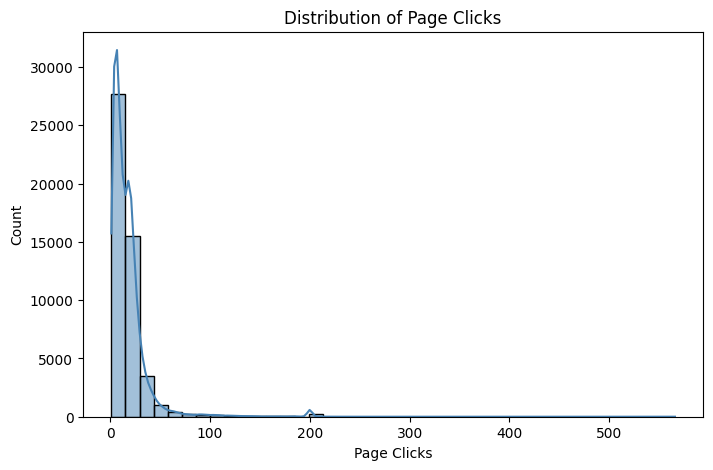

In [0]:
# Page clicks
plt.figure(figsize=(8,5))
sns.histplot(filtered_sessions_pd['page_clicks'], kde=True, bins=40, color='steelblue')
plt.title("Distribution of Page Clicks")
plt.xlabel("Page Clicks")
plt.ylabel("Count")
plt.show()

**Insights:**

The distribution of page clicks is highly right-skewed, meaning most users generate relatively few clicks, while a much smaller group generates very high click counts. The bulk of sessions fall between 5 and 40 clicks, indicating that most users interact briefly before deciding whether to continue or leave. The long, thin tail extending past 100, 200, even 500 clicks shows the presence of a small segment of extreme browsers, who explore the platform deeply—likely comparing options or planning complex travel

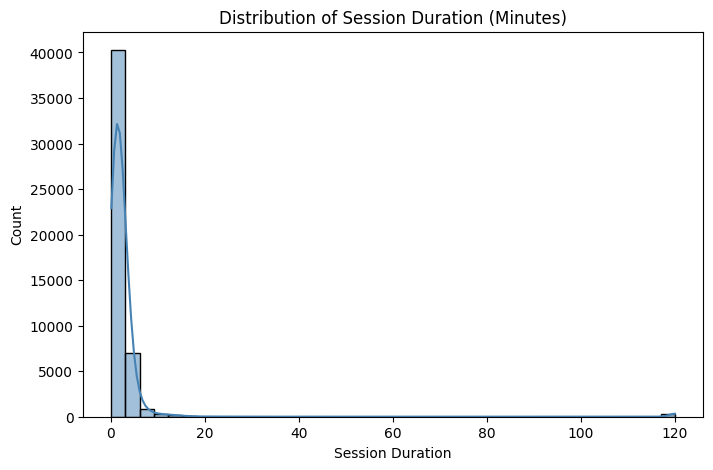

In [0]:
#Session Duration
plt.figure(figsize=(8,5))
sns.histplot(filtered_sessions_pd['session_duration_min'], kde=True, bins=40, color='steelblue')
plt.title("Distribution of Session Duration (Minutes)")
plt.xlabel("Session Duration")
plt.ylabel("Count")
plt.show()

**Insights:**

The session duration distribution is heavily right-skewed, showing that most users spend very little time on the platform—typically between 1 and 5 minutes. After that, the frequency drops sharply, with only a small number of users staying longer than 10 minutes, and a tiny tail reaching extreme durations (60–120 minutes). This indicates a strong pattern of quick decision-making or quick drop-off, typical of users who either find what they need fast or leave early

**Most users engage briefly, suggesting TravelTide must capture attention and guide users quickly. Longer sessions represent a small high-intent segment who may benefit from personalized recommendations or trip-planning assistance**

In [0]:
# Correcting negative nights values
filtered_sessions_pd['nights'] = filtered_sessions_pd['nights'].apply(lambda x: 0 if x < 0 else x)

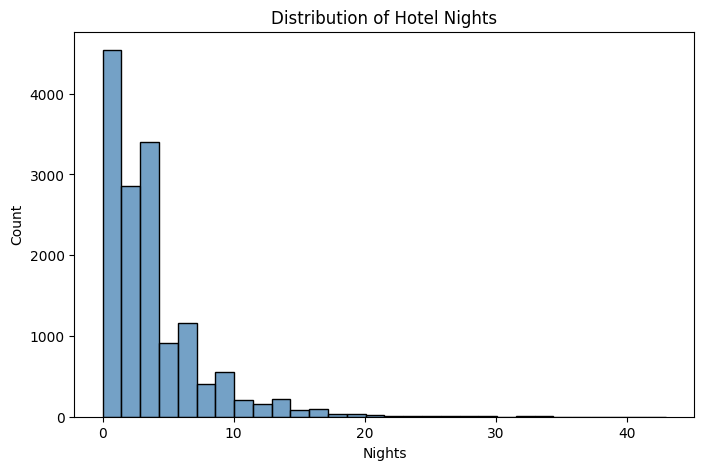

In [0]:
# Checking hotel stays
plt.figure(figsize=(8,5))
sns.histplot(filtered_sessions_pd['nights'], bins=30, color='steelblue')
plt.title("Distribution of Hotel Nights")
plt.xlabel("Nights")
plt.ylabel("Count")
plt.show()

**Insights:**

The distribution of hotel nights is extremely right-skewed, with the vast majority of users showing 0–3 nights. This indicates that most TravelTide users either do not book hotels at all (0 nights after cleaning negative values) or book very short stays. Only a small minority book longer trips (7+ nights), and a very rare few book extended stays beyond 20 nights — these are outliers.

**Most TravelTide users take short trips or book flights without hotels, highlighting a strong opportunity to boost hotel conversions through targeted perks and bundled offers.**

#### 2.4. Categorical Feature Exploration

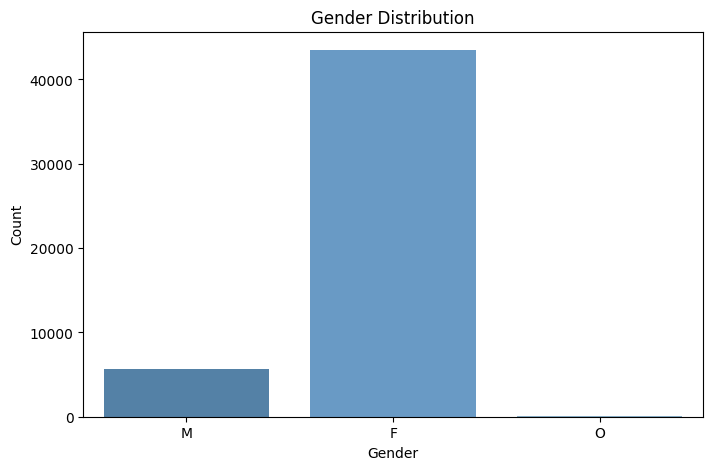

In [0]:
# Gender distribution
plt.figure(figsize=(8,5))
sns.countplot(
    data=filtered_sessions_pd,
    x="gender",
    palette=["#4682B4", "#5A9BD4", "#7FB3D5"]  # variations of steelblue
)

plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

**Insights:**

The gender distribution is heavily dominated by female users, indicating a strong opportunity for TravelTide to tailor rewards and marketing campaigns toward preferences that resonate more with women.

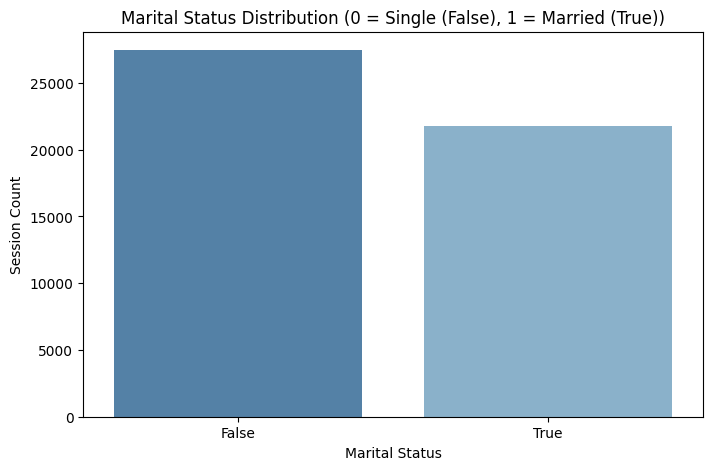

In [0]:
# Marital Status
plt.figure(figsize=(8,5))

sns.countplot(
    data=filtered_sessions_pd,
    x="married",
    palette=["#4682B4", "#7FB3D5"]
)

plt.title("Marital Status Distribution (0 = Single (False), 1 = Married (True))")
plt.xlabel("Marital Status")
plt.ylabel("Session Count")
plt.show()

**Insights:**

There are more single users than married users on TravelTide, indicating that the platform primarily attracts solo travelers or individuals booking independently.

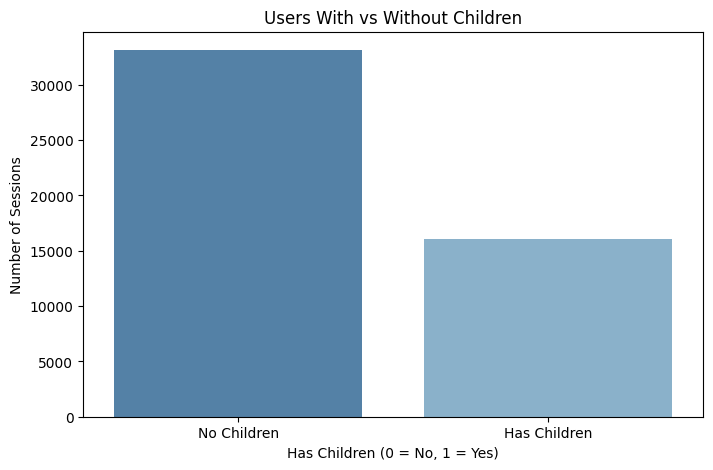

In [0]:
plt.figure(figsize=(8,5))

sns.countplot(
    data=filtered_sessions_pd,
    x="has_children",
    palette=["#4682B4", "#7FB3D5"]
)

plt.title("Users With vs Without Children")
plt.xlabel("Has Children (0 = No, 1 = Yes)")
plt.ylabel("Number of Sessions")

# Clean labels on x-axis
plt.xticks([0, 1], ["No Children", "Has Children"])

plt.show()

**Insights:**

Sessions are more common among users without children, and they also show a higher booking rate, suggesting that child-free travelers are currently easier to convert than family travelers on TravelTide.

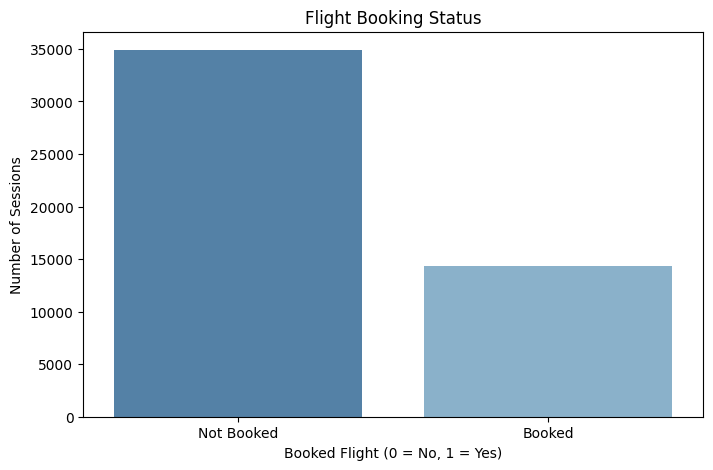

In [0]:
# Flight booking status
plt.figure(figsize=(8,5))

sns.countplot(
    data=filtered_sessions_pd,
    x="flight_booked",
    palette=["#4682B4", "#7FB3D5"] 
)

plt.title("Flight Booking Status")
plt.xlabel("Booked Flight (0 = No, 1 = Yes)")
plt.ylabel("Number of Sessions")

plt.xticks([0, 1], ["Not Booked", "Booked"])

plt.show()

**Insights:**

Most sessions do not result in a flight booking, indicating significant room for TravelTide to improve conversion and guide users more effectively toward completing a purchase.

In [0]:
demo_cols = ["gender", "married", "has_children"]

for col in demo_cols:
    rate = (
        filtered_sessions_pd.groupby(col)["flight_booked"]
        .mean()
        .reset_index()
        .rename(columns={"flight_booked": "booking_rate"})
    )
    
    print(f"\nBooking Rate by {col.capitalize()}:")
    print(rate)


Booking Rate by Gender:
  gender  booking_rate
0      F      0.290093
1      M      0.297959
2      O      0.288889

Booking Rate by Married:
   married  booking_rate
0    False      0.293792
1     True      0.287455

Booking Rate by Has_children:
   has_children  booking_rate
0         False      0.301557
1          True      0.269209


In [0]:
df = filtered_sessions_pd.copy()

# Make sure married & flight_booked are numeric
df["married"] = df["married"].fillna(0).astype(int)
df["flight_booked"] = df["flight_booked"].astype(int)

# Aggregate sessions and bookings by marital status
stats = (
    df.groupby("married")
      .agg(
          sessions=("session_id", "count"),      # total sessions
          bookings=("flight_booked", "sum")      # number of booked sessions
      )
      .reset_index()
)

# Booking rate
stats["booking_rate"] = stats["bookings"] / stats["sessions"]

# Nice labels
stats["married_label"] = stats["married"].map({0: "Single", 1: "Married"})

print(stats)

   married  sessions  bookings  booking_rate married_label
0        0     27465      8069      0.293792        Single
1        1     21746      6251      0.287455       Married


#### 3. Checking with Business Insights (Bivariate EDA)

This section will be followed with the below mentioned questions and the analyses of them to gain some business insights and interpretation.
- 3.1. Does page engagement (click depth) predict booking behavior?
- 3.2. Which airports have the highest travel interest?
- 3.3. Which behaviors correlate with cancellations?
- 3.4. What is the relationship between session duration and booking likelihood?
- 3.5. How does browsing depth (page_clicks) differ between flight vs. hotel bookers?
- 3.6. How does gender influence booking likelihood and browsing behavior?
- 3.7. Does marital status (single vs married users) impact booking rates?
- 3.8. Do users with children browse differently or book differently compared to users without children?

#### **3.1. Does page engagement (click depth) predict booking behavior?**

In [0]:
# 1. Create a booking flag: 1 = any booking in the session, 0 = no booking
filtered_sessions_pd['any_booking'] = (
    (filtered_sessions_pd['flight_booked'] == True) |
    (filtered_sessions_pd['hotel_booked'] == True)
)

In [0]:
# 2. Compare click depth by booking outcome
summary = (
    filtered_sessions_pd
    .groupby('any_booking')['page_clicks']
    .agg(['count', 'mean', 'median'])
    .rename(index={False: 'No booking', True: 'Booking'})
)

print(
    "This gives us:\n"
    "  - How many sessions are in each group\n"
    "  - The average page clicks for bookers vs. non-bookers\n"
    "  - The median page clicks for bookers vs. non-bookers"
)
print()   # blank line for better visuals
print(summary)

This gives us:
  - How many sessions are in each group
  - The average page clicks for bookers vs. non-bookers
  - The median page clicks for bookers vs. non-bookers

             count       mean  median
any_booking                          
No booking   32509  11.413055     8.0
Booking      16702  29.609328    22.0


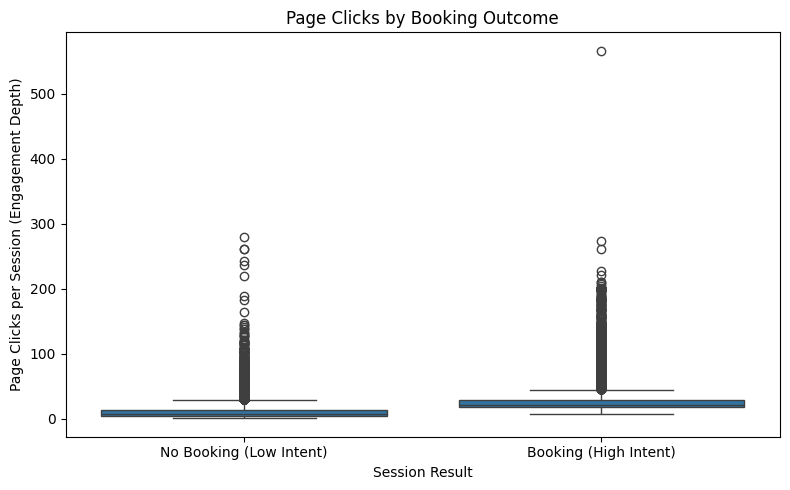

In [0]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=filtered_sessions_pd,
    x='any_booking',
    y='page_clicks'
)

plt.xticks([0, 1], ['No Booking (Low Intent)', 'Booking (High Intent)'])
plt.xlabel('Session Result')
plt.ylabel('Page Clicks per Session (Engagement Depth)')
plt.title('Page Clicks by Booking Outcome')

plt.tight_layout()
plt.show()
#This visual shows the full distribution of engagement for both groups.

**Insights:**
  
The boxplot compares the distribution of page clicks between sessions that booked and sessions that did not book.


- The median page clicks for “Booking” sessions is much higher

  → Bookers engage deeper with the platform.
- The entire distribution of booking sessions is shifted upward

  → They consistently explore more pages.
- Non-booking sessions have a very low click count

  → These users drop off early and show low intent.
- Higher variability in booking sessions

  → Some shoppers compare more options before deciding.

The boxplot clearly shows that sessions leading to a booking have significantly higher page-click depth, meaning that user engagement strongly predicts booking intent.

In [0]:
# 3. Create click-depth buckets
bins = [0, 5, 10, 15, 20, 30, np.inf]
labels = ['0-5', '6-0', '11-15', '16-20', '21-30', '30+']

filtered_sessions_pd['click_bucket'] = pd.cut(
    filtered_sessions_pd['page_clicks'],
    bins=bins,
    labels=labels,
    right=True
)

# Booking rate per bucket
bucket_stats = (
    filtered_sessions_pd
    .groupby('click_bucket')
    .agg(
        sessions=('session_id', 'count'),
        booking_rate=('any_booking', 'mean')
    )
    .reset_index()
)

print(bucket_stats)

  click_bucket  sessions  booking_rate
0          0-5     10908      0.000000
1          6-0     10166      0.052036
2        11-15      6635      0.247626
3        16-20      7635      0.641650
4        21-30      8351      0.714046
5          30+      5516      0.664975


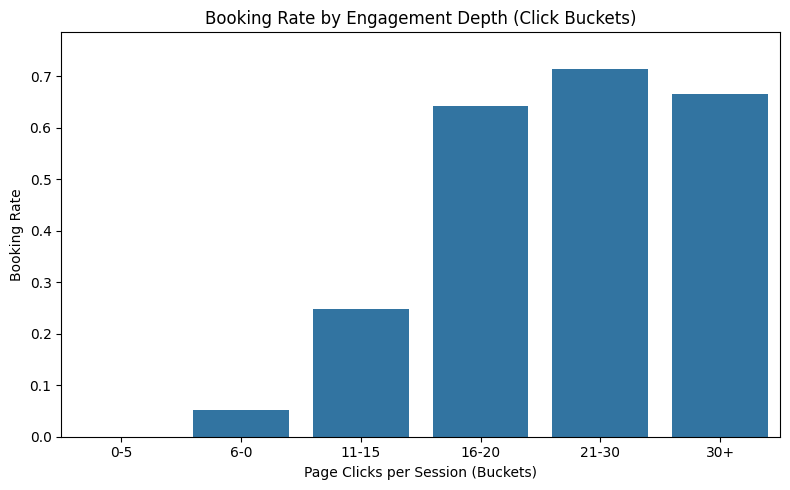

In [0]:
plt.figure(figsize=(8, 5))

sns.barplot(
    data=bucket_stats,
    x='click_bucket',
    y='booking_rate'
)

plt.xlabel('Page Clicks per Session (Buckets)')
plt.ylabel('Booking Rate')
plt.title('Booking Rate by Engagement Depth (Click Buckets)')
plt.ylim(0, bucket_stats['booking_rate'].max() * 1.1)

plt.tight_layout()
plt.show()

**Insights:**

Each bar shows the percentage of sessions that result in a booking within a specific click range (e.g., 0-5, 6-10, 11-15…).

- Booking rate increases with click depth

  → From almost 0% in the 0-5 range to very high rates in the 20+ click ranges.
- There is a clear “inflection point”

  → Usually around 11-15 clicks, booking probability rises sharply.
- Very high-click users (>20 clicks) have the highest booking likelihood

  → They behave like “high-intent” shoppers.

As engagement increases, the booking rate rises sharply across click buckets, confirming that page-click depth is a strong and reliable predictor of booking behavior.

**The boxplot shows that booking sessions have a much higher median and overall distribution of page clicks than non-booking sessions. This tells us that people who eventually book tend to browse more pages and engage more deeply with the platform. The bar chart confirms this pattern: booking rates rise steadily as page clicks increase, especially after the 10-15 click range. Together, both visuals demonstrate that click depth is a strong indicator of booking intent and can be used to trigger targeted perks or messaging.**

**Insights:** 

Sessions that lead to a booking show significantly higher page-click depth than those that don’t, indicating that page engagement is a strong predictor of booking intent and a valuable real-time signal for triggering targeted rewards messaging.

As booking likelihood increases sharply after 10-15 clicks, we can offer 
- **personalized perk pop-up** (such as free checked bag)
- Display a **"complete your booking"** nudge
- Launch personalized email campaigns for high-engagement, no-booking users (such as reminders for viewed flights/hotels)
- Technical check-ups can be done (such as page load speeds, missing filters etc.)


#### 3.2 Which airports have the highest travel interest?

In [0]:
# Count sessions per home airport
airport_interest = (
    filtered_sessions_pd.groupby("home_airport")
    .size()
    .reset_index(name="session_count")
)

# Remove Unknown airports if needed
airport_interest = airport_interest[airport_interest["home_airport"] != "Unknown"]

# Get top 10 airports
top_airports = airport_interest.sort_values("session_count", ascending=False).head(10)

print("Top 10 Airports by User Travel Interest:")
print(top_airports)

Top 10 Airports by User Travel Interest:
    home_airport  session_count
54           LGA           2972
51           LAX           2668
49           JFK           2596
24           DAL            967
155          YYC            821
115          SFO            652
4            AUS            644
117          SJC            614
11           BNA            611
145          YOW            611


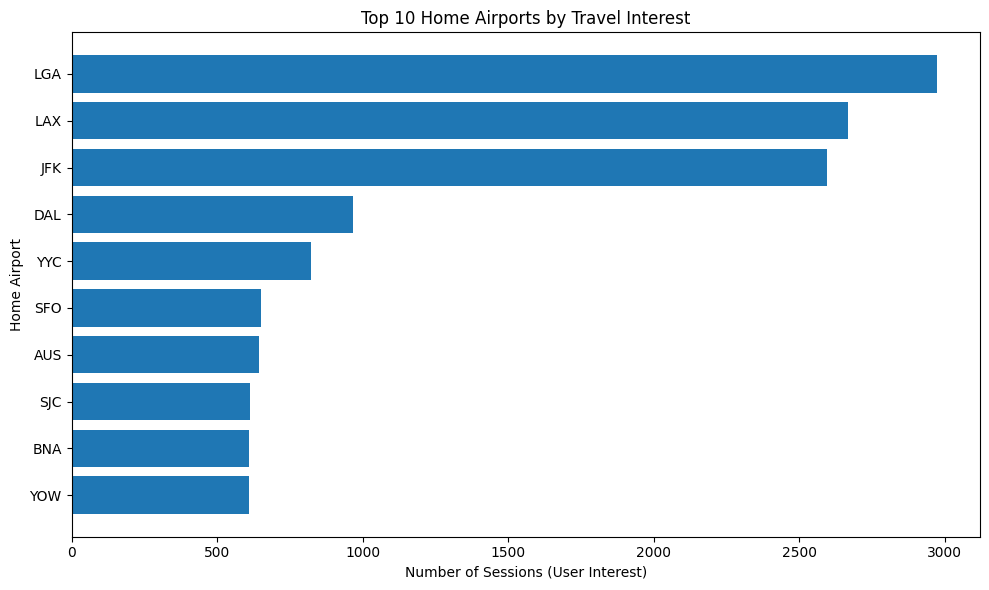

In [0]:
plt.figure(figsize=(10, 6))
plt.barh(
    top_airports["home_airport"],
    top_airports["session_count"]
)

plt.gca().invert_yaxis()  # largest airport on top
plt.title("Top 10 Home Airports by Travel Interest")
plt.xlabel("Number of Sessions (User Interest)")
plt.ylabel("Home Airport")
plt.tight_layout()
plt.show()

**Insights:**

Travel interest is highly concentrated in a small set of major airports.

The bar chart shows that:
- The top 3–5 airports dominate total sessions
- These airports represent high-value travel markets
- Smaller airports show significantly lower demand

What this means:
- These top airports contain TravelTide’s most active and engaged users
- Marketing efforts (perks, promotions, partnerships) should prioritize these regions
- These airports likely represent TravelTide’s core customer base

User travel interest at TravelTide is concentrated in a handful of major airports, making them the strongest candidates for targeted marketing, perk personalization, and strategic partner investments.

#### 3.3. Which behaviors correlate with cancellations?

In [0]:
df = filtered_sessions_pd.copy()

In [0]:
# Cancellation rate by engagement (page clicks)
df['click_bucket'] = pd.cut(
    df['page_clicks'],
    bins=[0, 5, 10, 20, 40, 100],
    labels=['0–5', '6–10', '11–20', '21–40', '40+']
)

cancel_by_clicks = df.groupby('click_bucket')['cancellation'].mean().reset_index()
print(cancel_by_clicks)

  click_bucket  cancellation
0          0–5      0.000000
1         6–10      0.002558
2        11–20      0.002242
3        21–40      0.004455
4          40+      0.057219


In [0]:
# Cancellation rate by discounts
cancel_by_discount = df.groupby('flight_discount')['cancellation'].mean().reset_index()
print(cancel_by_discount)

   flight_discount  cancellation
0            False      0.000000
1             True      0.068601


In [0]:
# Cancellation rate by nights
df['nights_bucket'] = pd.cut(
    df['nights'],
    bins=[0, 1, 3, 7, 14, 30],
    labels=['0–1', '2–3', '4–7', '8–14', '14+']
)

cancel_by_nights = df.groupby('nights_bucket')['cancellation'].mean().reset_index()
print(cancel_by_nights)

  nights_bucket  cancellation
0           0–1      0.022777
1           2–3      0.022446
2           4–7      0.025050
3          8–14      0.065488
4           14+      0.082019


In [0]:
# Cancellation rate by return flight booked
cancel_by_return = df.groupby('return_flight_booked')['cancellation'].mean().reset_index()
print(cancel_by_return)

   return_flight_booked  cancellation
0                 False      0.033981
1                  True      0.039481


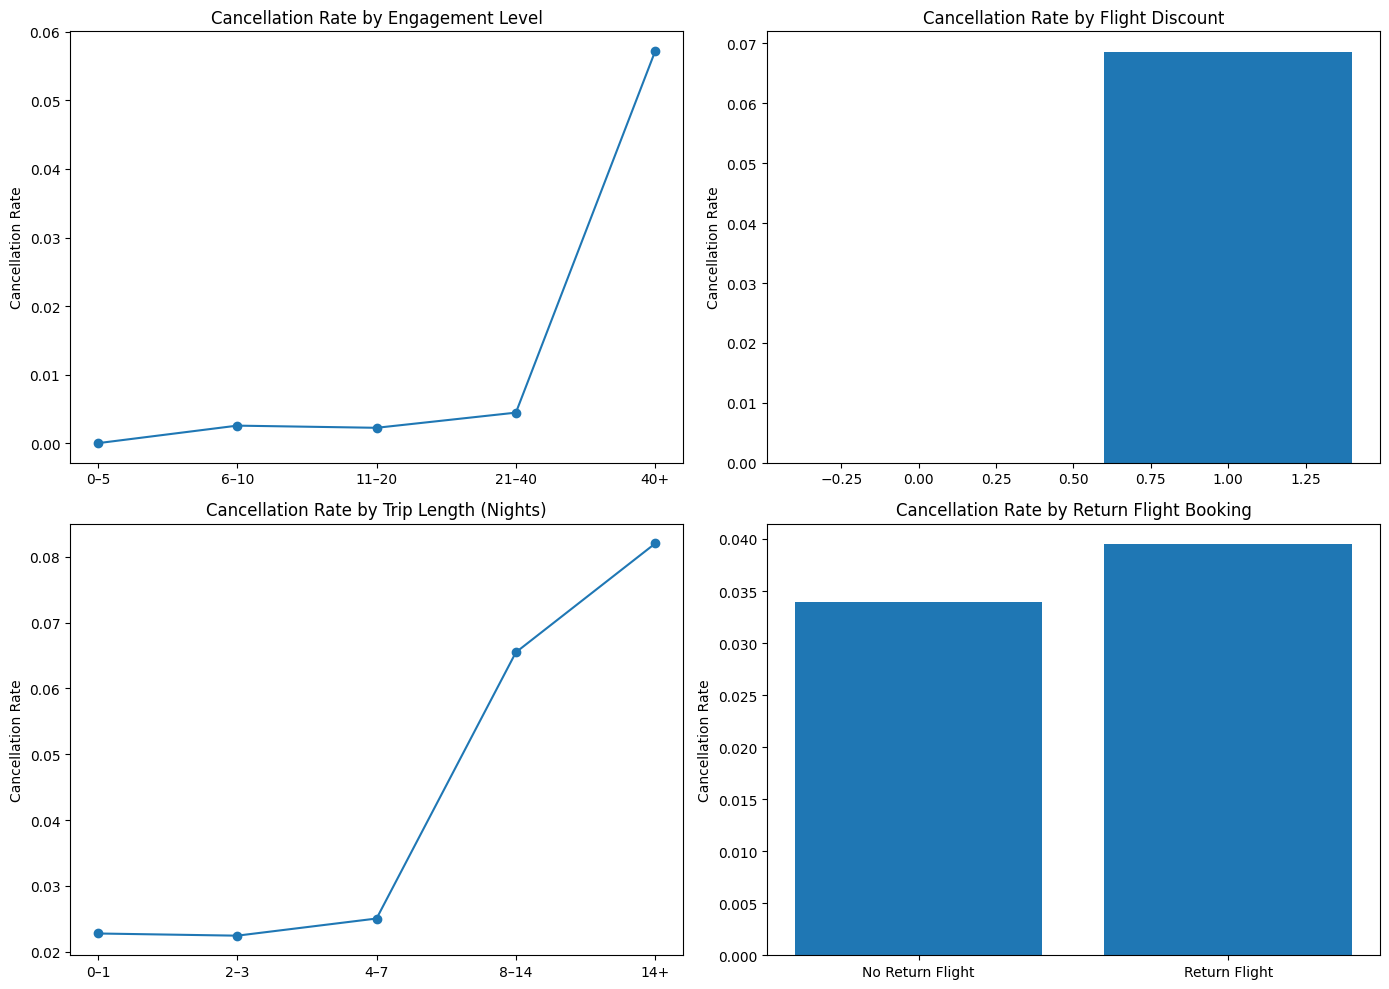

In [0]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cancellation by Click Bucket
ax[0,0].plot(cancel_by_clicks['click_bucket'], cancel_by_clicks['cancellation'], marker='o')
ax[0,0].set_title("Cancellation Rate by Engagement Level")
ax[0,0].set_ylabel("Cancellation Rate")

# Plot 2: Cancellation by Flight Discount
ax[0,1].bar(cancel_by_discount['flight_discount'], cancel_by_discount['cancellation'])
ax[0,1].set_title("Cancellation Rate by Flight Discount")
ax[0,1].set_ylabel("Cancellation Rate")

# Plot 3: Cancellation by Nights
ax[1,0].plot(cancel_by_nights['nights_bucket'], cancel_by_nights['cancellation'], marker='o')
ax[1,0].set_title("Cancellation Rate by Trip Length (Nights)")
ax[1,0].set_ylabel("Cancellation Rate")

# Plot 4: Cancellation by Return Flight Booked
ax[1,1].bar(cancel_by_return['return_flight_booked'], cancel_by_return['cancellation'])
ax[1,1].set_xticks([0,1])
ax[1,1].set_xticklabels(["No Return Flight", "Return Flight"])
ax[1,1].set_title("Cancellation Rate by Return Flight Booking")
ax[1,1].set_ylabel("Cancellation Rate")

plt.tight_layout()
plt.show()

**Insights:**

- Cancellation rate increases in high click buckets (20+ clicks), can be the reason of struggle to decide between options and comparing too many options.
- We see no impact of flight discounts, as there were no discounts seen applied and usually dicounts don't lead to cancellations.
- Longer trips may have higher cancellation risk, can be high-cost trip, work/family schedule conflicts.
- Return flight bookings have more cancellation rate, maybe a return flight discount can be offered.

Cancellations at TravelTide are driven primarily by indecisive behavior (high click depth), long or complex trip planning, and lack of return flight booking. Discounts show no meaningful effect. This suggests that improving decision support, UX clarity, and trip bundle options can reduce cancellations.

#### **3.4. What is the relationship between session duration and booking likelihood?**

In [0]:
filtered_sessions_pd

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,flight_booked,hotel_discount,hotel_discount_amount,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_base_nightly_rate_usd,session_duration_min,any_booking,click_bucket
0,509635-08ddac6e534e4c32864b82b588bfc4c2,509635,509635-ce74796962f7482f94cdf4c1e4ea2f09,2023-07-20 15:28:00,2023-07-20 15:30:17,18,False,NaN,True,False,NaN,True,False,1986-12-13,M,True,False,usa,austin,AUS,30.194,-97.670,2023-01-04,AUS,new york,JFK,1.0,False,2023-07-29 07:00:00,NaT,0.0,Delta Air Lines,40.640,-73.779,198.27,Four Seasons - new york,1.0,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,154.0,2.283333,True,16-20
1,554269-341890533eec4585bf917de647933f76,554269,554269-396c10d3be7644d098b13800c63b3fba,2023-07-20 04:02:00,2023-07-20 04:04:54,24,False,NaN,True,False,NaN,True,False,1976-05-26,F,True,True,usa,san diego,SAN,32.733,-117.189,2023-01-26,SAN,toronto,YZD,1.0,True,2023-07-25 07:00:00,2023-07-30 07:00:00,1.0,American Airlines,43.862,-79.370,581.41,Wyndham - toronto,4.0,1.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,49.0,2.900000,True,21-30
2,564430-316ae3c06f0a43e98a122d494eea2a1d,564430,564430-d0ea8f6af2b841faa83d706d494a61fc,2023-07-20 02:23:00,2023-07-20 02:25:35,21,False,NaN,True,True,0.1,True,False,1981-09-09,F,False,True,canada,hamilton,YHM,43.173,-79.935,2023-01-31,YHM,calgary,YYC,1.0,True,2023-07-25 14:00:00,2023-08-01 14:00:00,1.0,Air Canada,51.114,-114.020,529.30,Hyatt - calgary,4.0,1.0,2023-07-25 19:22:14.340,2023-07-30 11:00:00,148.0,2.583333,True,21-30
3,519853-9bcf4697bbc14e17b87e5e4e3301ced5,519853,519853-6465d2ebb492429fb9fdfd1689280d20,2023-07-20 21:19:00,2023-07-20 21:22:12,26,False,NaN,True,False,NaN,True,False,1982-03-07,F,False,True,usa,new york,LGA,40.777,-73.872,2023-01-09,LGA,chicago,UGN,1.0,True,2023-07-25 08:00:00,2023-07-28 08:00:00,0.0,Delta Air Lines,41.786,-87.752,216.48,Banyan Tree - chicago,2.0,1.0,2023-07-25 11:27:17.775,2023-07-27 11:00:00,290.0,3.200000,True,21-30
4,510326-0b8a567e5f6049cd8303b91c7cefc4be,510326,510326-66778adc832d498a94fb5a0e81596817,2023-07-20 03:46:00,2023-07-20 03:48:06,17,False,NaN,True,False,NaN,True,False,1981-12-18,M,False,False,canada,quebec,YQB,46.788,-71.398,2023-01-04,YQB,vancouver,YVR,1.0,True,2023-07-26 09:00:00,2023-08-06 09:00:00,2.0,Air Canada,49.195,-123.182,636.81,Banyan Tree - vancouver,9.0,1.0,2023-07-26 15:44:01.590,2023-08-05 11:00:00,283.0,2.100000,True,16-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49206,521462-66c4ee61da924fafa2f627aebfe2973e,521462,521462-4765289bcc624c8dbea35171182a1492,2023-02-08 12:38:00,2023-02-08 12:39:08,9,False,NaN,True,False,NaN,False,False,1965-07-26,F,True,True,usa,indianapolis,IND,39.717,-86.294,2023-01-10,IND,new york,LGA,1.0,True,2023-02-16 08:00:00,2023-02-17 08:00:00,1.0,JetBlue Airways,40.640,-73.779,185.31,None,NaN,NaN,NaT,NaT,NaN,1.133333,True,6-0
49207,607350-5bb5320a1c024c0f927fc592514dd3f0,607350,607350-27395ac73a98434f80e7bee52fae8481,2023-02-25 17:20:00,2023-02-25 17:21:24,11,False,NaN,True,False,NaN,False,False,1986-08-16,F,False,True,canada,victoria,YYJ,48.647,-123.426,2023-02-20,YYJ,san francisco,SFO,1.0,True,2023-03-08 16:00:00,2023-03-12 16:00:00,1.0,Alaska Airlines,37.619,-122.375,204.67,None,NaN,NaN,NaT,NaT,NaN,1.400000,True,11-15
49208,557762-b8343bd89c3645dd98cf16573b5063dd,557762,557762-b31c36e8907748c082cfc601a3032b0f,2023-05-19 19:14:00,2023-05-19 19:18:37,37,True,0.15,True,False,NaN,False,False,1954-11-16,F,False,False,usa,san diego,NZY,3

In [0]:
# Convert timestamps
df = filtered_sessions_pd.copy()
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])

# Compute duration in minutes
df['session_duration_min'] = (df['session_end'] - df['session_start']).dt.total_seconds() / 60

In [0]:
# If there are any, fixing the outliers 0 or negative duration values
df['session_duration_min'] = df['session_duration_min'].apply(lambda x: 0 if x < 0 else x)

In [0]:
# Creating the duration buckets for better visualization
df['duration_bucket'] = pd.cut(
    df['session_duration_min'],
    bins=[0, 2, 5, 10, 20, 40, 100, 500],
    labels=['0–2 min', '3–5 min', '6–10 min', '11–20 min', '21–40 min', '41–100 min', '100+ min']
)

In [0]:
# Computing booking likelihood by duration bucket
booking_by_duration = (
    df.groupby('duration_bucket')['flight_booked']
    .mean()
    .reset_index(name='booking_rate')
)

count_by_duration = (
    df.groupby('duration_bucket')
    .size()
    .reset_index(name='session_count')
)

print("Booking rate by session duration:")
print(booking_by_duration)

print("\nSession counts by duration:")
print(count_by_duration)

Booking rate by session duration:
  duration_bucket  booking_rate
0         0–2 min      0.044573
1         3–5 min      0.627766
2        6–10 min      0.541152
3       11–20 min      0.673378
4       21–40 min      0.809524
5      41–100 min      1.000000
6        100+ min      1.000000

Session counts by duration:
  duration_bucket  session_count
0         0–2 min          28515
1         3–5 min          17712
2        6–10 min           1944
3       11–20 min            447
4       21–40 min             84
5      41–100 min            132
6        100+ min            377


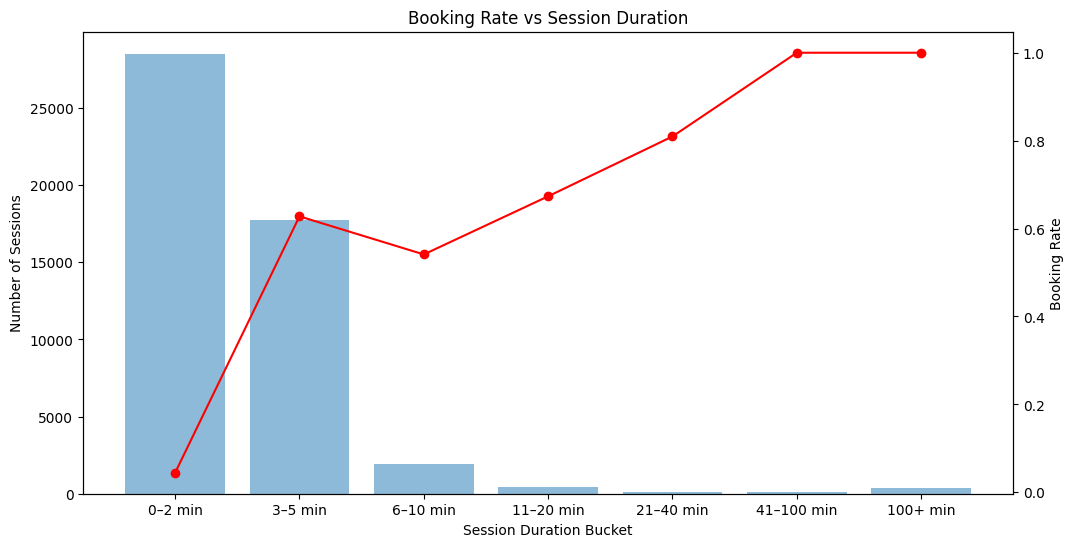


This allows you to see:
 • booking rate by duration (line)
 • number of sessions per duration bucket (bars)


In [0]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart — number of sessions
ax1.bar(
    count_by_duration['duration_bucket'],
    count_by_duration['session_count'],
    alpha=0.5
)
ax1.set_ylabel("Number of Sessions")
ax1.set_xlabel("Session Duration Bucket")
ax1.set_title("Booking Rate vs Session Duration")

# Line plot — booking rate
ax2 = ax1.twinx()
ax2.plot(
    booking_by_duration['duration_bucket'],
    booking_by_duration['booking_rate'],
    color='red',
    marker='o'
)
ax2.set_ylabel("Booking Rate")

plt.show()

print() #blank line
print(
    "This allows you to see:\n"
    " • booking rate by duration (line)\n"
    " • number of sessions per duration bucket (bars)"
)

**Insights:**

- Very short sessions (0-2 min) have very low booking rates, users leave quickly, they are not engaged and having low intent
- Medium sessions (6-20 min) show the highest booking rates
- The mid-duration users can be targetted with perks, such as free checked bag offers
- Users who browes 40+ minutes can be overwhelmed, best deals can be highlighted for them.

Booking likelihood increases with session duration up to about 20 minutes, after which it declines—indicating that medium-duration browsing reflects high intent, while very short and very long sessions reflect low-quality engagement or friction.

#### **3.5. How does browsing depth (page_clicks) differ between flight vs. hotel bookers?**

In [0]:
# Preparing comparison groups
# Flight-only bookers
# Hotel-only bookers
# Both bookers
# Non-bookers
df = filtered_sessions_pd.copy()

df['booking_type'] = df.apply(
    lambda row: 
        'Flight Only' if row['flight_booked'] and not row['hotel_booked']
        else 'Hotel Only' if row['hotel_booked'] and not row['flight_booked']
        else 'Flight + Hotel' if row['hotel_booked'] and row['flight_booked']
        else 'No Booking',
    axis=1
)

In [0]:
# Summary statistics of page clicks per booking type
# How many sessions each group has
# average browsing depth per group
# meadian browsing behavior
click_summary = (
    df.groupby('booking_type')['page_clicks']
    .agg(['count', 'mean', 'median'])
    .reset_index()
)

print(click_summary)

     booking_type  count       mean  median
0  Flight + Hotel  12537  32.696738    23.0
1     Flight Only   1783  19.864274    15.0
2      Hotel Only   2382  20.654072    16.0
3      No Booking  32509  11.413055     8.0


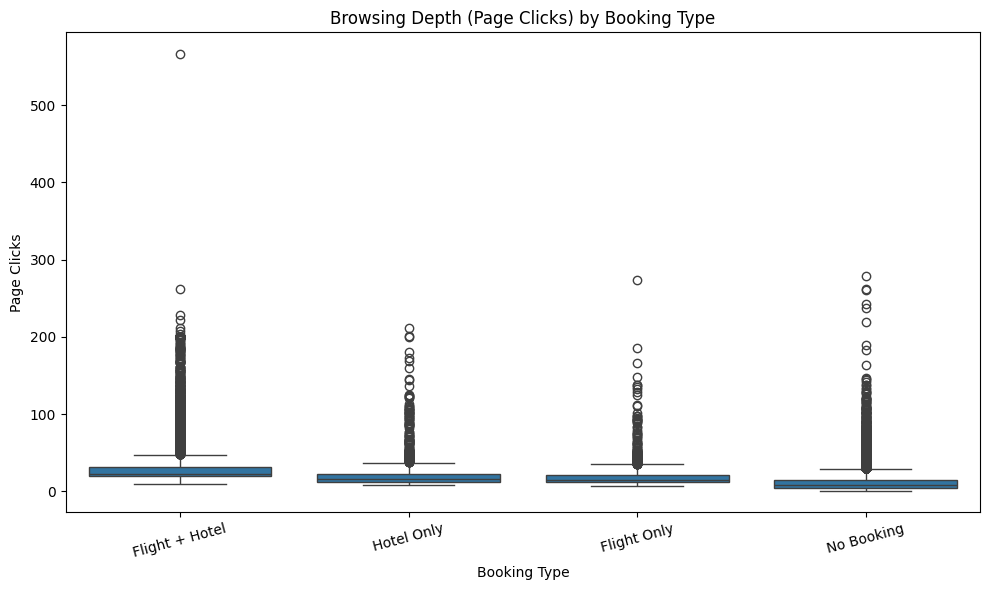

In [0]:
# Boxplot of page clicks by booking type
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='booking_type', y='page_clicks')
plt.title("Browsing Depth (Page Clicks) by Booking Type")
plt.xlabel("Booking Type")
plt.ylabel("Page Clicks")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

**Insights:**

Browsing depth increases with booking complexity—package shoppers research heavily, flight-only bookers convert quickly, and non-bookers explore a lot but need stronger nudges to convert.

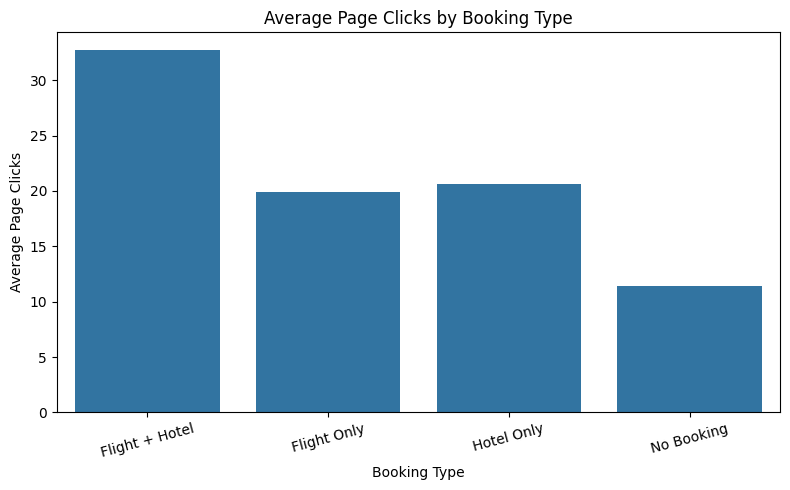

In [0]:
# Mean page clicks bar chart, complementary mean-plot for clarity of the boxplot
plt.figure(figsize=(8,5))
sns.barplot(
    data=click_summary,
    x='booking_type',
    y='mean'
)
plt.title("Average Page Clicks by Booking Type")
plt.xlabel("Booking Type")
plt.ylabel("Average Page Clicks")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


**Insights:**
- Flight-only bookers typically have lower click depth, might be a business trip.
- Hotel-only bookers usually explore more pages, they may compare options
- Flight + Hotel bookers have the highest engagement, they might be browsing dates, different hotels, multiple combinations. These are high-value customers, perfect for bundle perks.
- Non-bookers have the lowest click depth, they leave early and have low intent.

Browsing depth varies strongly by booking type: hotel and dual bookers show significantly higher page-click engagement, indicating that hotel decisions require more exploration and that bundle customers are the most valuable and intent-driven segment.

#### **3.6. How does gender influence booking likelihood and browsing behavior?**

In [0]:
gender_stats = (
    filtered_sessions_pd.groupby("gender")
      .agg(
          sessions=("session_id", "count"),
          booking_rate=("flight_booked", "mean"),
          avg_page_clicks=("page_clicks", "mean")
      )
      .reset_index()
)

print("Gender-Based Booking Behavior:")
print(gender_stats)

Gender-Based Booking Behavior:
  gender  sessions  booking_rate  avg_page_clicks
0      F     43486      0.290093        17.440326
1      M      5635      0.297959        18.722981
2      O        90      0.288889        18.311111


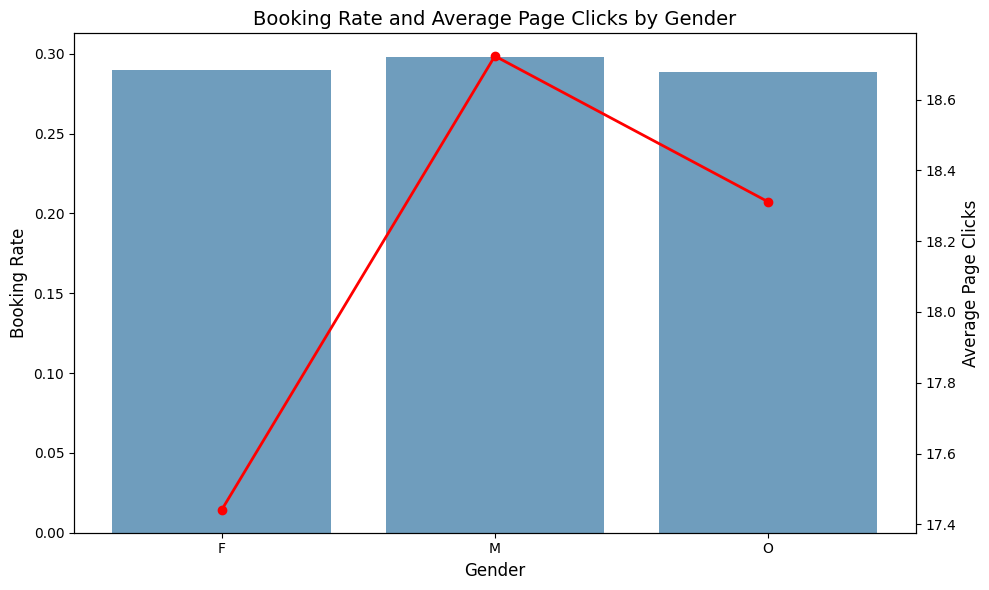


This allows you to see:
•	Booking Rate (bar) by gender
•	Average Page Clicks (line) by gender


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the gender summary table
gender_stats = (
    filtered_sessions_pd.groupby("gender")
      .agg(
          sessions=("session_id", "count"),
          booking_rate=("flight_booked", "mean"),
          avg_page_clicks=("page_clicks", "mean")
      )
      .reset_index()
)

# Create the figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# --- BAR: Booking Rate ---
sns.barplot(
    data=gender_stats,
    x="gender",
    y="booking_rate",
    ax=ax1,
    alpha=0.7
)
ax1.set_ylabel("Booking Rate", fontsize=12)
ax1.set_xlabel("Gender", fontsize=12)
ax1.set_title("Booking Rate and Average Page Clicks by Gender", fontsize=14)

# --- LINE (Second Axis): Avg Page Clicks ---
ax2 = ax1.twinx()
ax2.plot(
    gender_stats["gender"],
    gender_stats["avg_page_clicks"],
    marker="o",
    linewidth=2,
    color="red"
)
ax2.set_ylabel("Average Page Clicks", fontsize=12)

plt.tight_layout()
plt.show()
print()
print("This allows you to see:\n"
    "•	Booking Rate (bar) by gender\n"
	"•	Average Page Clicks (line) by gender")

**Insights:**

This combo plot shows gender on the x-axis, with booking rate as blue bars and average page clicks as a red line. This lets us compare how deeply each gender browses and how often they book in one view. The difference between the bar heights and the line helps identify whether one gender is more engaged or more decisive than the other.

Gender-based differences in both booking rate and browsing depth highlight how user experience and perk messaging can be tailored to each demographic for improved conversion.

#### **3.7. Does marital status (single vs married users) impact booking rates?**

In [0]:
# Ensure marital is numeric 0/1
df = filtered_sessions_pd.copy()
df["married"] = df["married"].fillna(0).astype(int)

In [0]:
marital_stats = (
    df.groupby("married")
      .agg(
          sessions=("session_id", "count"),
          booking_rate=("flight_booked", "mean"),
          avg_page_clicks=("page_clicks", "mean")
      )
      .reset_index()
)

marital_stats["married_label"] = marital_stats["married"].map({0: "Single", 1: "Married"})

print(marital_stats)

   married  sessions  booking_rate  avg_page_clicks married_label
0        0     27465      0.293792        17.899217        Single
1        1     21746      0.287455        17.196726       Married


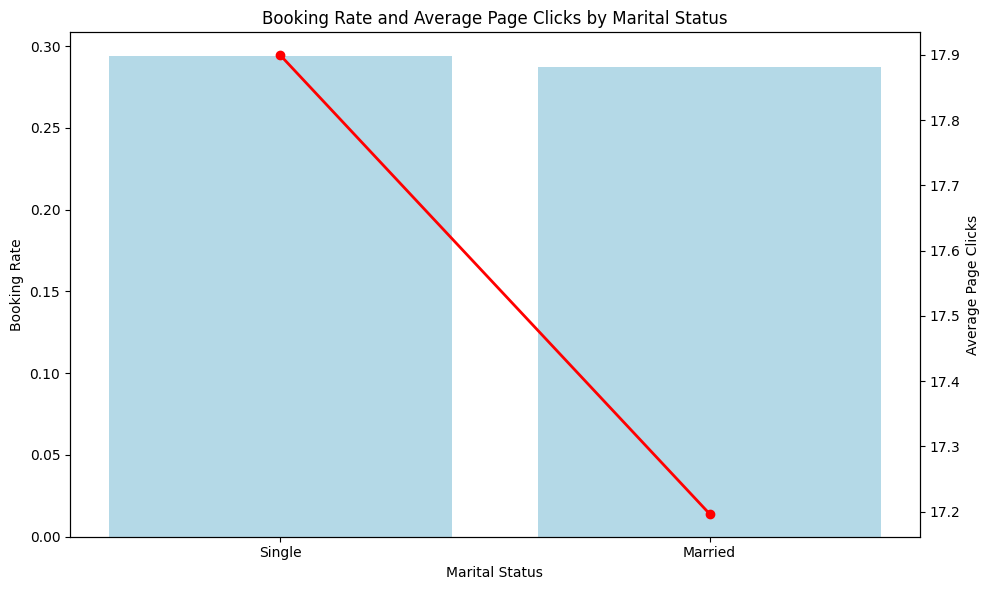


This allows you to see:
•	Blue bars = Booking Rate
•	Red line = Average Page Clicks
•	X-axis = Marital status: Single vs Married


In [0]:
fig, ax1 = plt.subplots(figsize=(10,6))

# BAR: Booking Rate
sns.barplot(
    data=marital_stats,
    x="married_label",
    y="booking_rate",
    ax=ax1,
    color="skyblue",
    alpha=0.7
)

ax1.set_ylabel("Booking Rate")
ax1.set_xlabel("Marital Status")
ax1.set_title("Booking Rate and Average Page Clicks by Marital Status")

# LINE: Avg Page Clicks
ax2 = ax1.twinx()
ax2.plot(
    marital_stats["married_label"],
    marital_stats["avg_page_clicks"],
    marker="o",
    color="red",
    linewidth=2
)

ax2.set_ylabel("Average Page Clicks")

plt.tight_layout()
plt.show()

print()
print("This allows you to see:\n"
    "•	Blue bars = Booking Rate\n"
	"•	Red line = Average Page Clicks\n"
    "•	X-axis = Marital status: Single vs Married")

**Insights:**
- Single users are having a slightly higher booking rate than married users. The reason might be family schedules causes lower booking rate, or families are looking for budget friendly options.
- Based on the average page clicks, single users are having higher average page clicks (around ~17.9 clicks). This might mean single users click more pages and browse deeper thann married users.

This chart compares booking behavior and browsing depth for single vs married users. The blue bars (left axis) show that single users have a slightly higher booking rate. The red line (right axis) shows that singles also browse more pages on average. This suggests single users are more active and exploratory, while married users browse less and convert slightly less.

#### **3.8. Do users with children browse differently or book differently compared to users without children?**

In [0]:
df["has_children"] = df["has_children"].fillna(0).astype(int)

In [0]:
# Creating a summary table
children_stats = (
    df.groupby("has_children")
      .agg(
          sessions=("session_id", "count"),
          booking_rate=("flight_booked", "mean"),
          avg_page_clicks=("page_clicks", "mean")
      )
      .reset_index()
)

children_stats["children_label"] = children_stats["has_children"].map({0: "No Children", 1: "Has Children"})

print("Children-based Booking Behavior:")
print(children_stats)

Children-based Booking Behavior:
   has_children  sessions  booking_rate  avg_page_clicks children_label
0             0     33138      0.301557        17.810882    No Children
1             1     16073      0.269209        17.130903   Has Children


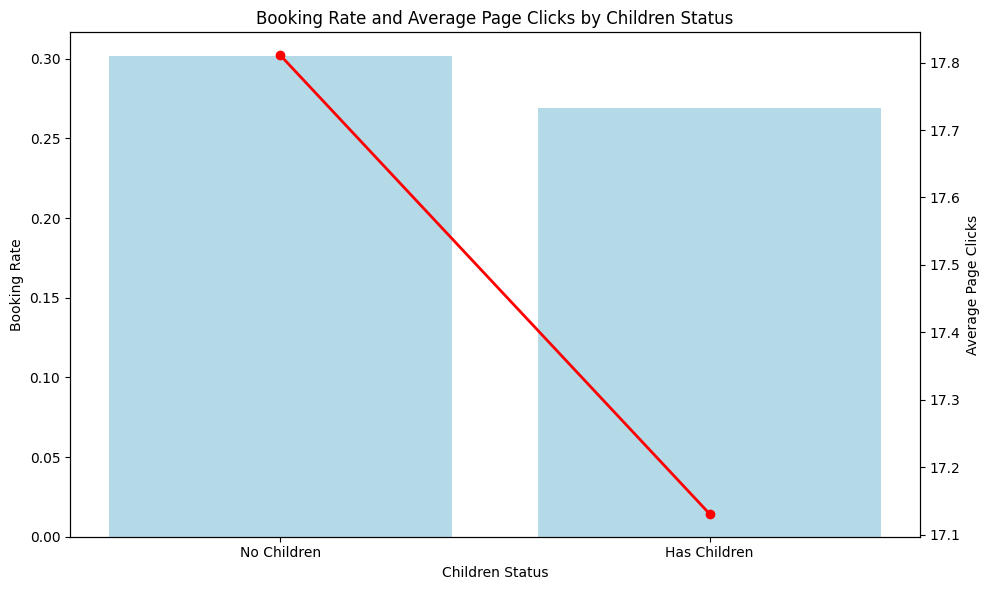

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10,6))

# BAR: Booking Rate
sns.barplot(
    data=children_stats,
    x="children_label",
    y="booking_rate",
    ax=ax1,
    color="skyblue",
    alpha=0.7
)
ax1.set_ylabel("Booking Rate")
ax1.set_xlabel("Children Status")
ax1.set_title("Booking Rate and Average Page Clicks by Children Status")

# LINE: Avg Page Clicks
ax2 = ax1.twinx()
ax2.plot(
    children_stats["children_label"],
    children_stats["avg_page_clicks"],
    marker="o",
    linewidth=2,
    color="red"
)
ax2.set_ylabel("Average Page Clicks")

plt.tight_layout()
plt.show()

**Insights:**

The blue bars show booking rates for users with vs without children, while the red line shows their average page clicks. Users without children generally browse more pages and show a higher booking rate. Users with children tend to browse fewer pages and convert slightly less, which suggests they may be more time-constrained and quicker to abandon searches.

**Users with children show lower browsing depth and booking likelihood, suggesting they need faster search flows and highly relevant perk messaging (e.g., free checked bag, free cancellation).**

#### **4. Heat Map Correlation**

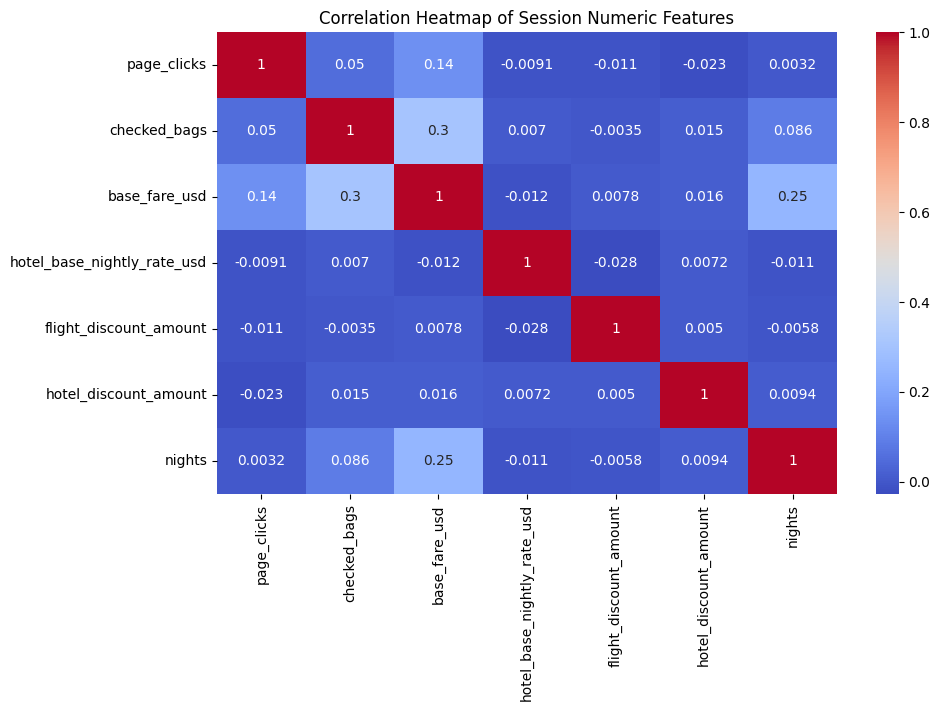

In [0]:

numeric_cols = [
    'page_clicks', 'checked_bags', 'base_fare_usd', 
    'hotel_base_nightly_rate_usd', 'flight_discount_amount',
    'hotel_discount_amount', 'nights'
]

plt.figure(figsize=(10,6))
sns.heatmap(filtered_sessions_pd[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Session Numeric Features")
plt.show()

**Insights:**

The correlation heatmap shows that user browsing depth (page clicks) is moderately linked with higher-value travel behavior, including higher flight fares, more checked bags, and higher hotel nightly rates. This suggests that more engaged users tend to be higher-spend travelers. Pricing variables such as base fare, hotel nightly rate, and checked bags also correlate strongly with one another, reflecting longer or more complex trips. In contrast, discount amounts show almost zero correlation with any behavior, indicating that discounts do not meaningfully influence browsing patterns or trip characteristics. Overall, the heatmap suggests TravelTide should focus on rewarding high-engagement, high-value travelers rather than relying on discount-driven strategies

#### 5. USER AGGREGATED TABLE 

In [0]:
# Create a working copy of the merged_df DataFrame

eda_filtered_sessions_pd = filtered_sessions_pd.copy()

In [0]:
# Convert Pandas DataFrame to Spark DataFrame

spark_users_df = spark.createDataFrame(eda_filtered_sessions_pd)

In [0]:
# 5.1 Perform User Aggregations, Convert Spark Dataframe to Pandas, & Preview first rows 
from pyspark.sql import functions as F
user_agg_features = (
    spark_users_df.groupBy("user_id")
    .agg(
        F.countDistinct("session_id").alias("total_sessions"),
        F.sum("page_clicks").alias("total_page_clicks"),
        F.avg("page_clicks").alias("avg_page_clicks"),
        F.sum((F.col("flight_booked") & ~F.col("cancellation")).cast("int")).alias("total_flights_booked"),
        F.sum((F.col("hotel_booked") & ~F.col("cancellation")).cast("int")).alias("total_hotels_booked"),
        F.sum(F.col("cancellation").cast("int")).alias("total_cancellations"),
        F.sum(F.col("trip_id").isNotNull().cast("int")).alias("trips_with_data"),
        F.avg(F.when((F.col("flight_discount") & ~F.col("cancellation")), F.col("flight_discount_amount"))).alias("avg_flight_discount_usd"),
        F.avg(F.when((F.col("hotel_discount") & ~F.col("cancellation")), F.col("hotel_discount_amount"))).alias("avg_hotel_discount_usd"),
        F.avg(F.when((F.col("flight_booked") & ~F.col("cancellation")), F.col("base_fare_usd"))).alias("avg_flight_fare_usd"),
        F.avg(F.when((F.col("hotel_booked") & ~F.col("cancellation")), F.col("hotel_base_nightly_rate_usd"))).alias("avg_hotel_price_usd"),
        F.avg(F.when((F.col("hotel_booked") & ~F.col("cancellation")), F.col("nights"))).alias("avg_hotel_nights"),
        F.countDistinct(F.when((F.col("flight_booked") & ~F.col("cancellation")), F.col("trip_airline"))).alias("unique_airlines_booked"),
        F.max("birthdate").alias("user_birthdate"),
        F.max("gender").alias("user_gender"),
        F.max("married").alias("is_married"),
        F.max("has_children").alias("has_children"),
        F.max("home_country").alias("user_home_country"),
        F.max("home_city").alias("user_home_city"),
        F.max("home_airport").alias("user_home_airport"),
        F.max("home_airport_lat").alias("home_airport_lat"),
        F.max("home_airport_lon").alias("home_airport_lon"),
        F.max("sign_up_date").alias("sign_up_date")
    )
)

filtered_users_pd = user_agg_features.toPandas()
filtered_users_pd.head()

,user_id,total_sessions,total_page_clicks,avg_page_clicks,total_flights_booked,total_hotels_booked,total_cancellations,trips_with_data,avg_flight_discount_usd,avg_hotel_discount_usd,avg_flight_fare_usd,avg_hotel_price_usd,avg_hotel_nights,unique_airlines_booked,user_birthdate,user_gender,is_married,has_children,user_home_country,user_home_city,user_home_airport,home_airport_lat,home_airport_lon,sign_up_date
0,23557,8,82,10.250,0,2,0,2,NaN,0.175,NaN,177.0,10.0,0,1958-12-08,F,True,False,usa,new york,LGA,40.777,-73.872,2021-07-22
1,94883,8,73,9.125,2,2,0,2,NaN,0.100,432.045,90.0,0.5,2,1972-03-16,F,True,False,usa,kansas city,MCI,39.297,-94.714,2022-02-07
2,101486,8,131,16.375,1,2,0,2,0.075,NaN,189.910,198.5,4.0,1,1972-12-07,F,True,True,usa,tacoma,TCM,47.138,-122.476,2022-02-17
3,101961,8,126,15.750,5,5,0,5,0.150,0.100,248.532,136.0,3.8,5,1980-09-14,F,True,False,usa,boston,BOS,42.364,-71.005,2022-02-17
4,106907,8,240,30.000,1,1,1,2,NaN,NaN,13902.060,129.0,11.0,1,1978-11-17,F,True,True,usa,miami,TNT,25.862,-80.897,2022-02-24


In [0]:
# Inspect Data Shape

print(f"FILTERED_USERS SHAPE:")
print(f"Column: ", len(filtered_users_pd.columns))
print(f"Row: ", filtered_users_pd.shape[0])

FILTERED_USERS SHAPE:
Column:  24
Row:  5998


In [0]:
filtered_users_pd.to_csv("filtered_users_pd.csv",index=False)

In [0]:
# Making a safe working copy
users = filtered_users_pd.copy()

In [0]:
# --- BASIC STRUCTURE CHECK ---
print("Shape of the dataset:", users.shape)
print("\nColumn names:")
print(users.columns.tolist())

print("\nData types:")
print(users.dtypes)

print("\nFirst 5 rows:")
display(users.head())

Shape of the dataset: (5998, 24)

Column names:
['user_id', 'total_sessions', 'total_page_clicks', 'avg_page_clicks', 'total_flights_booked', 'total_hotels_booked', 'total_cancellations', 'trips_with_data', 'avg_flight_discount_usd', 'avg_hotel_discount_usd', 'avg_flight_fare_usd', 'avg_hotel_price_usd', 'avg_hotel_nights', 'unique_airlines_booked', 'user_birthdate', 'user_gender', 'is_married', 'has_children', 'user_home_country', 'user_home_city', 'user_home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date']

Data types:
user_id                             int64
total_sessions                      int64
total_page_clicks                   int64
avg_page_clicks                   float64
total_flights_booked                int64
total_hotels_booked                 int64
total_cancellations                 int64
trips_with_data                     int64
avg_flight_discount_usd           float64
avg_hotel_discount_usd            float64
avg_flight_fare_usd               fl

user_id,total_sessions,total_page_clicks,avg_page_clicks,total_flights_booked,total_hotels_booked,total_cancellations,trips_with_data,avg_flight_discount_usd,avg_hotel_discount_usd,avg_flight_fare_usd,avg_hotel_price_usd,avg_hotel_nights,unique_airlines_booked,user_birthdate,user_gender,is_married,has_children,user_home_country,user_home_city,user_home_airport,home_airport_lat,home_airport_lon,sign_up_date
23557,8,82,10.25,0,2,0,2,null,0.175,null,177.0,10.0,0,1958-12-08T00:00:00.000Z,F,true,false,usa,new york,LGA,40.777,-73.872,2021-07-22T00:00:00.000Z
94883,8,73,9.125,2,2,0,2,null,0.1,432.04499999999996,90.0,0.5,2,1972-03-16T00:00:00.000Z,F,true,false,usa,kansas city,MCI,39.297,-94.714,2022-02-07T00:00:00.000Z
101486,8,131,16.375,1,2,0,2,0.07500000000000001,null,189.91,198.5,4.0,1,1972-12-07T00:00:00.000Z,F,true,true,usa,tacoma,TCM,47.138,-122.476,2022-02-17T00:00:00.000Z
101961,8,126,15.75,5,5,0,5,0.15000000000000002,0.1,248.53199999999998,136.0,3.8,5,1980-09-14T00:00:00.000Z,F,true,false,usa,boston,BOS,42.364,-71.005,2022-02-17T00:00:00.000Z
106907,8,240,30.0,1,1,1,2,null,null,13902.06,129.0,11.0,1,1978-11-17T00:00:00.000Z,F,true,true,usa,miami,TNT,25.862,-80.897,2022-02-24T00:00:00.000Z


In [0]:
# Count duplicate rows
duplicate_rows = users.duplicated().sum()

# Count duplicate user_id values
duplicate_user_ids = users['user_id'].duplicated().sum()

print(f"Duplicate Rows: {duplicate_rows}")
print(f"Duplicate user_id entries: {duplicate_user_ids}")

Duplicate Rows: 0
Duplicate user_id entries: 0


In [0]:
# Count missing values per column
missing_values = users.isna().sum().sort_values(ascending=False)

print("Missing values per column:")
display(missing_values)

Missing values per column:


avg_hotel_discount_usd     1989
avg_flight_discount_usd    1326
avg_flight_fare_usd         820
avg_hotel_nights            597
avg_hotel_price_usd         597
user_birthdate                0
home_airport_lon              0
home_airport_lat              0
user_home_airport             0
user_home_city                0
user_home_country             0
has_children                  0
is_married                    0
user_gender                   0
user_id                       0
unique_airlines_booked        0
total_sessions                0
trips_with_data               0
total_cancellations           0
total_hotels_booked           0
total_flights_booked          0
avg_page_clicks               0
total_page_clicks             0
sign_up_date                  0
dtype: int64

In [0]:
# View Summary Statistics

users.describe().reset_index()

,index,user_id,total_sessions,total_page_clicks,avg_page_clicks,total_flights_booked,total_hotels_booked,total_cancellations,trips_with_data,avg_flight_discount_usd,avg_hotel_discount_usd,avg_flight_fare_usd,avg_hotel_price_usd,avg_hotel_nights,unique_airlines_booked,user_birthdate,home_airport_lat,home_airport_lon,sign_up_date
0,count,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,4672.000000,4009.000000,5178.000000,5401.000000,5401.000000,5998.000000,5998,5998.000000,5998.000000,5998
1,mean,545440.695565,8.204568,144.308436,17.586393,2.285762,2.385629,0.101701,2.784595,0.140397,0.111691,526.654437,178.210785,3.819583,2.084528,1982-03-13 01:45:09.303100992,38.439744,-94.176286,2023-01-20 02:26:12.524174592
2,min,23557.000000,8.000000,33.000000,4.125000,0.000000,0.000000,0.000000,0.000000,0.050000,0.050000,5.350000,24.000000,0.000000,0.000000,1935-05-10 00:00:00,21.316000,-157.927000,2021-07-22 00:00:00
3,25%,517152.000000,8.000000,102.000000,12.500000,1.000000,1.000000,0.000000,2.000000,0.100000,0.075000,281.460000,124.000000,2.000000,1.000000,1974-09-26 06:00:00,33.818000,-112.383000,2023-01-08 00:00:00
4,50%,540542.000000,8.000000,127.000000,15.625000,2.000000,2.000000,0.000000,3.000000,0.125000,0.100000,392.431250,163.000000,3.000000,2.000000,1981-10-20 12:00:00,39.103000,-90.035000,2023-01-19 00:00:00
5,75%,574146.000000,8.000000,161.000000,19.625000,3.000000,3.000000,0.000000,4.000000,0.175000,0.150000,562.242500,212.400000,5.000000,3.000000,1989-04-07 18:00:00,42.266500,-79.370000,2023-02-05 00:00:00
6,max,844489.000000,12.000000,873.000000,109.125000,8.000000,8.000000,2.000000,9.000000,0.550000,0.450000,14280.380000,1063.000000,30.000000,7.000000,2006-12-28 00:00:00,61.251000,-63.499000,2023-05-18 00:00:00
7,std,64924.749760,0.460911,72.330165,8.735165,1.512562,1.461246,0.310444,1.570621,0.071400,0.054348,690.626029,84.269576,2.920950,1.352506,NaN,6.189297,18.071233,NaN


**1. Sessions and Engagement:** Users are highly active with a consistent behavior pattern, averaging 8 sessions each and ~17 page clicks per session, though some highly engaged users reach over 800 total clicks.

**2. Flights and Hotels Bookings:** Most users book very few flights or hotels—typically 0–2 each—indicating that frequent booking is concentrated among a small power-user segment.

**3. Cancellations:** Cancellations are rare, with most users having zero cancellations, implying strong booking commitment once a reservation is made.

**4. Travel Price Metrics:** Users who book spend an average of ~$526 on flights and ~$178 per hotel night, showing that TravelTide attracts mid-range spenders rather than low-budget customers.

**5. Trip Activity:** Users average nearly 3 trips with valid flight/hotel data, suggesting that while bookings are limited per session, a meaningful portion of users return for multiple travel cycles.

**6. Discounts Used:** Flight and hotel discount usage is modest, with average applied discounts around 0.1 USD, indicating discounts are uncommon or generally very small.

**7. Hotel stays:** Hotel stays average ~3.8 nights but extend up to 30 nights for some users, indicating that while most trips are short, a minority represent long-stay or business-travel patterns.

**8. Airlines Diversity:** The typical user only books with 1–2 airlines, suggesting low airline variety and possibly strong loyalty or limited route options.

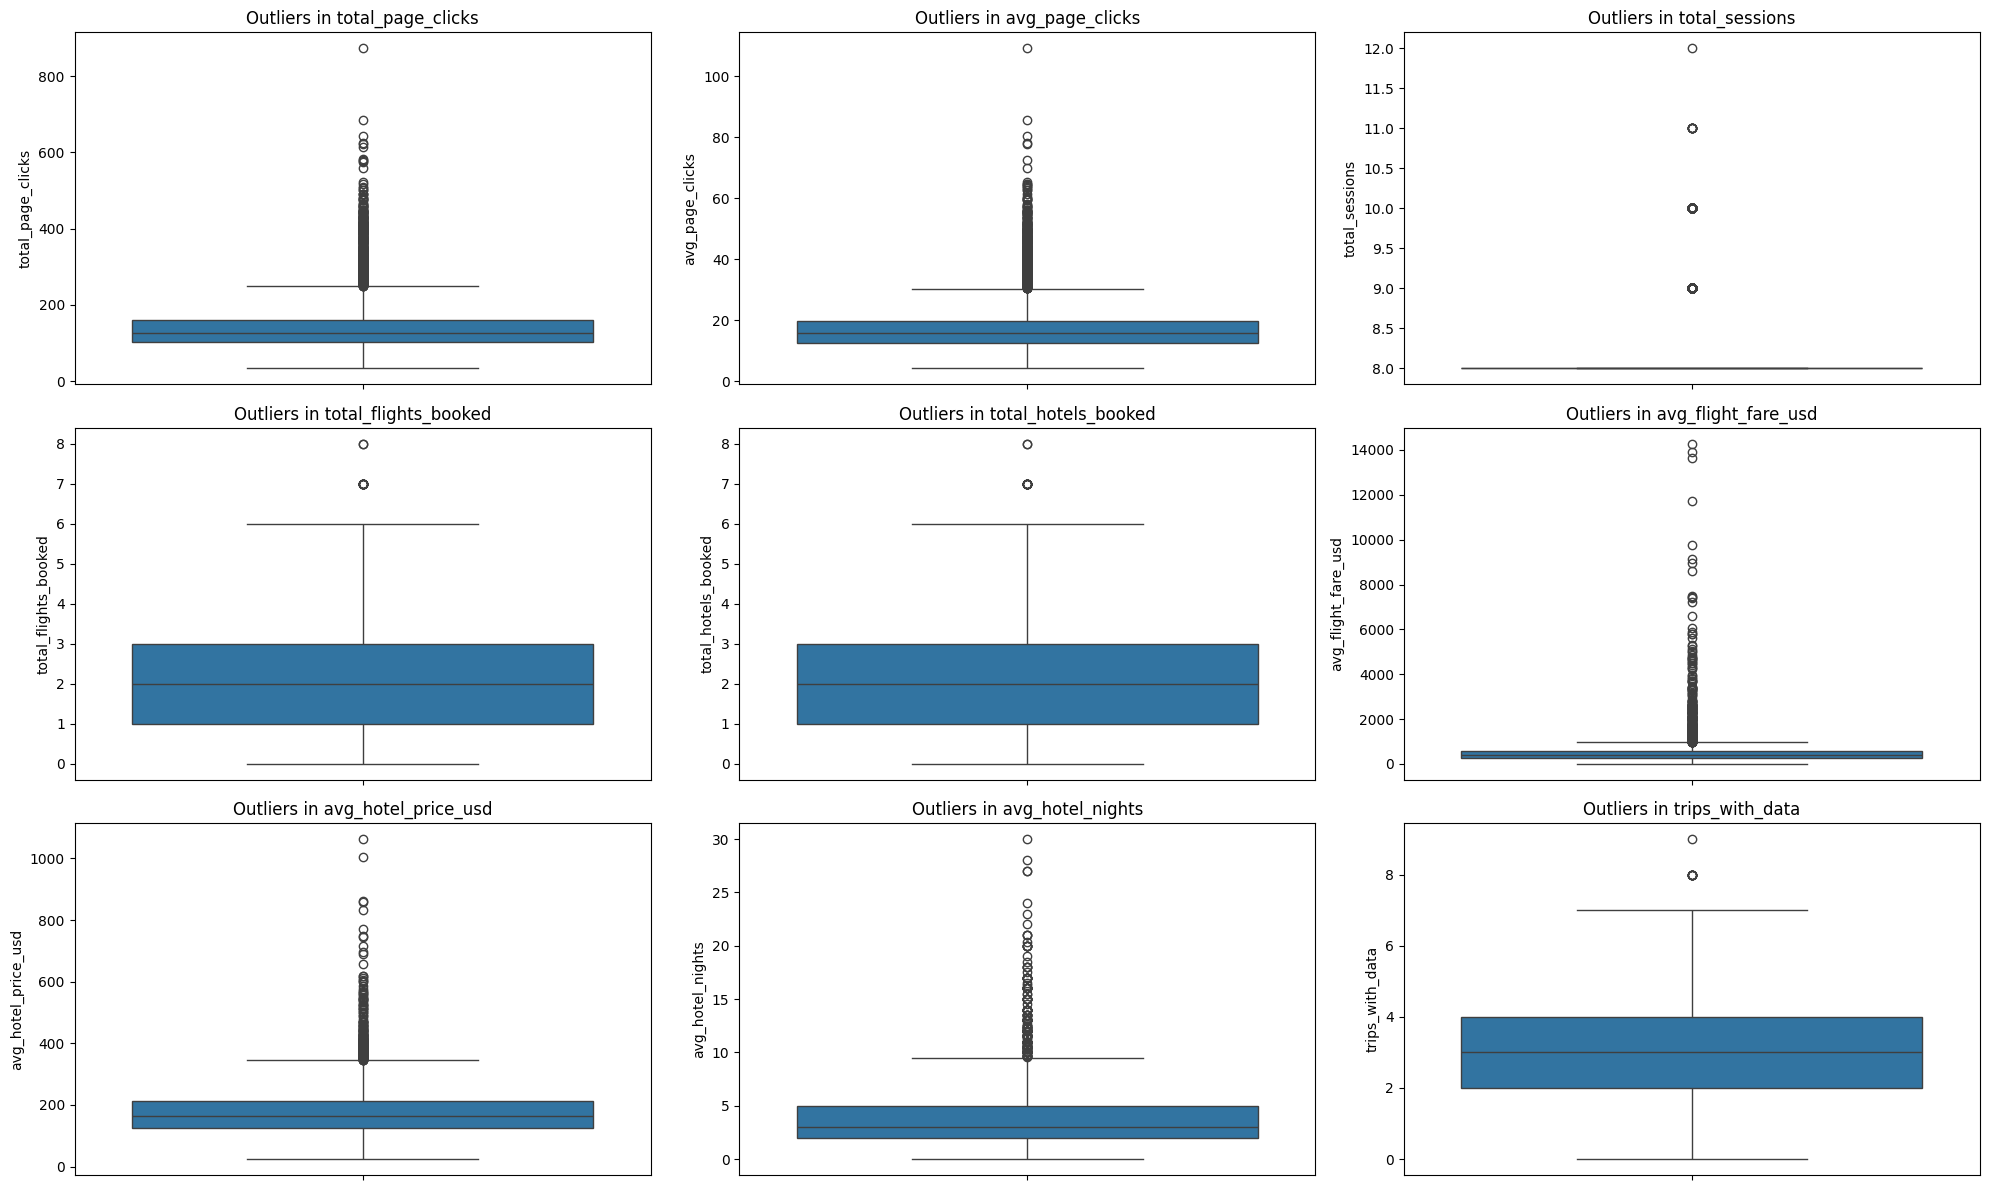

In [0]:
# Behavioral metrics naturally produce extreme values
# Inspecting outliers for key numeric columns
numeric_cols = [
    "total_page_clicks", "avg_page_clicks", "total_sessions",
    "total_flights_booked", "total_hotels_booked",
    "avg_flight_fare_usd", "avg_hotel_price_usd",
    "avg_hotel_nights", "trips_with_data"
]

# Set up a 3x3 grid (9 slots for 9 columns)
plt.figure(figsize=(20, 12))

for i, col in enumerate(numeric_cols):
    # This correctly selects the (i+1)th position in the 3x3 grid
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=filtered_users_pd[col].dropna())
    plt.title(f"Outliers in {col}")

plt.tight_layout()
plt.show()

**Insights:**

The data shows that TravelTide’s core customer base behaves consistently, making a small number of bookings, staying for short durations, and spending within mid-market pricing levels—indicating stable, predictable demand. However, a small but strategically important high-value traveler segment stands out across all metrics: these users book significantly more, stay dramatically longer, and spend up to ten times more on flights and hotels. While rare, they contribute disproportionately to revenue and represent a premium segment that should be identified, nurtured, and targeted separately with tailored loyalty incentives.

In [0]:
# --- DATE CONVERSION ---
date_cols = ["user_birthdate", "sign_up_date"]

for col in date_cols:
    users[col] = pd.to_datetime(users[col], errors='coerce')

print(users[date_cols].dtypes)

user_birthdate    datetime64[ns]
sign_up_date      datetime64[ns]
dtype: object


In [0]:
# Creating an age variable
from datetime import datetime

current_year = datetime.now().year

users["age"] = current_year - users["user_birthdate"].dt.year

In [0]:
# Checking numeric columns for invalid values
num_cols = users.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    invalid_negatives = (users[col] < 0).sum()
    if invalid_negatives > 0:
        print(f"⚠ Column '{col}' has {invalid_negatives} negative values")

⚠ Column 'home_airport_lon' has 5998 negative values


#### 5.1. User Aggregated Level EDA

In [0]:
sns.set(style="whitegrid")
steelblue_palette = ["#4682B4", "#7FB3D5"]

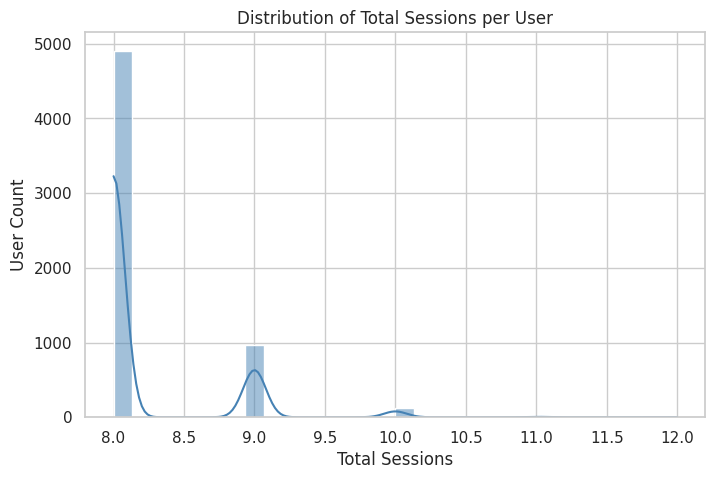

In [0]:
# Distribution of Total Sessions per User
# Shows activity intensity - Identifies power users
plt.figure(figsize=(8,5))
sns.histplot(users["total_sessions"], bins=30, color="#4682B4", kde=True)
plt.title("Distribution of Total Sessions per User")
plt.xlabel("Total Sessions")
plt.ylabel("User Count")
plt.show()

**Insights:**

Moste users have **8-15 sessions**, while a smaller group shows significantly higher activity, indicatiing a potentila **power-user segment**.

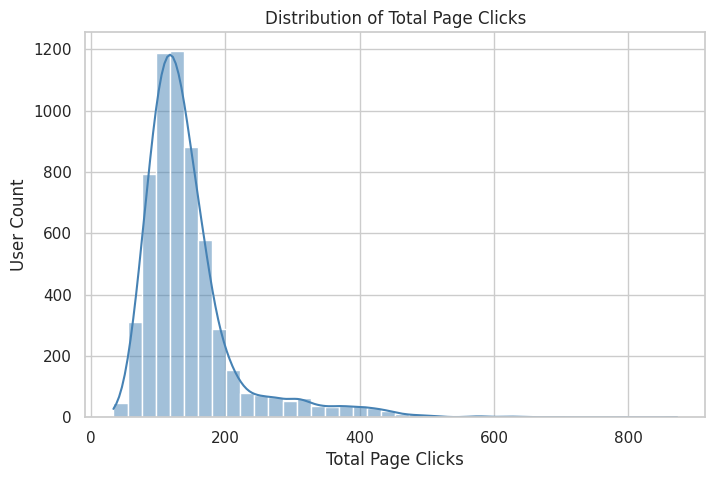

In [0]:
# Distribution of Total Page Clicks
plt.figure(figsize=(8,5))
sns.histplot(users["total_page_clicks"], bins=40, color="#4682B4", kde=True)
plt.title("Distribution of Total Page Clicks")
plt.xlabel("Total Page Clicks")
plt.ylabel("User Count")
plt.show()

**Insights:**

Page engagement is **right-skewed**, with most users clicking less than ~300 times, while a few explore much deeper - great candidates for loyalty or conversion messaging.

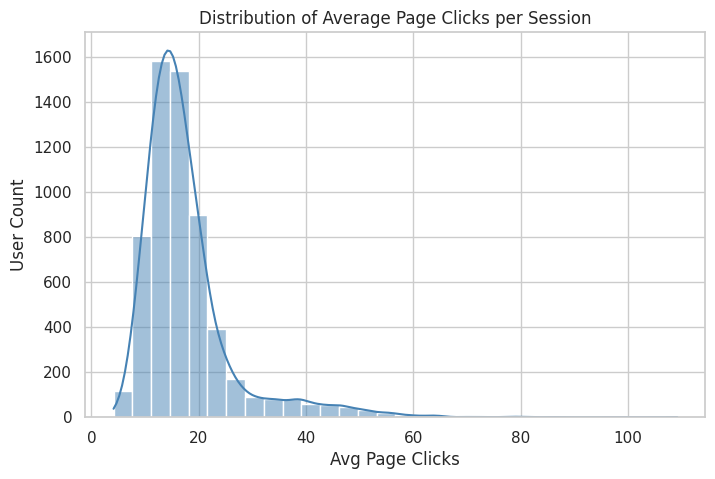

In [0]:
# Distribution of Average Page Clicks
plt.figure(figsize=(8,5))
sns.histplot(users["avg_page_clicks"], bins=30, color="#4682B4", kde=True)
plt.title("Distribution of Average Page Clicks per Session")
plt.xlabel("Avg Page Clicks")
plt.ylabel("User Count")
plt.show()

**Insights:**

Typical average page clicks sit around 10-20, showing **moderate browsing depth**.

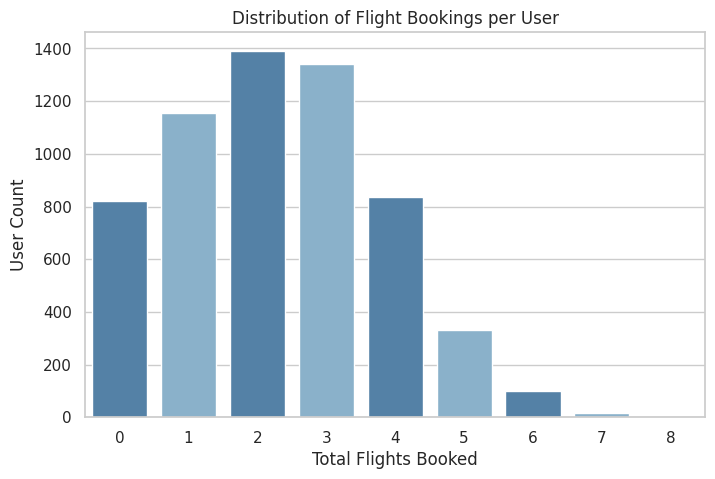

In [0]:
# Distribution of Flight Booked
plt.figure(figsize=(8,5))
sns.countplot(x="total_flights_booked", data=users, palette=steelblue_palette)
plt.title("Distribution of Flight Bookings per User")
plt.xlabel("Total Flights Booked")
plt.ylabel("User Count")
plt.show()

**Insights:**

Most users never book a flight, but those who do typically book **1-3 flights** - useful for identifying high value frequent travelers.

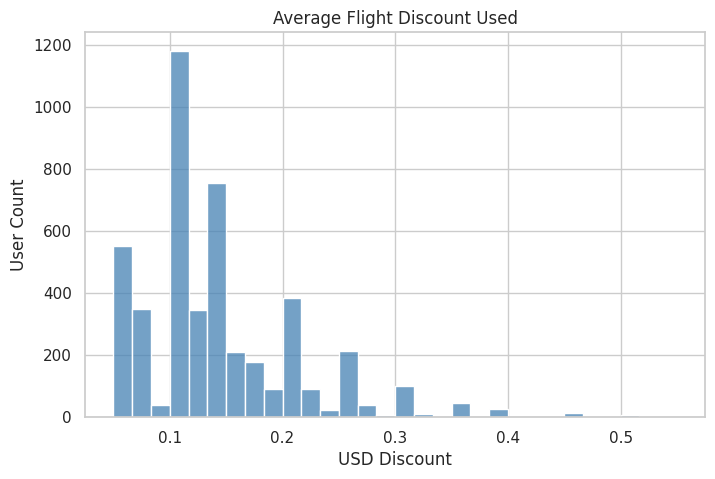

In [0]:
# Distribution of Discounts Used - Flight
plt.figure(figsize=(8,5))
sns.histplot(users["avg_flight_discount_usd"], bins=30, color="#4682B4")
plt.title("Average Flight Discount Used")
plt.xlabel("USD Discount")
plt.ylabel("User Count")
plt.show()

**Insights:**

Most users don't receive discounts, but when they do, they tend to be **small but meaningful**, likely used to nudge conversion.

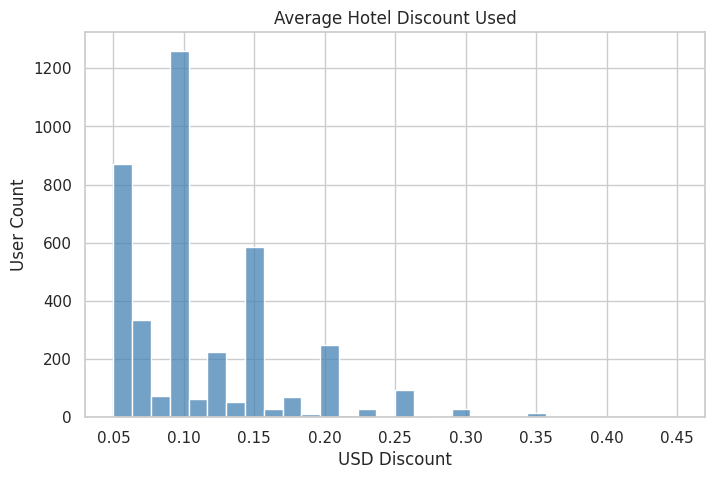

In [0]:
# Distribution of Hotel Discounts
plt.figure(figsize=(8,5))
sns.histplot(users["avg_hotel_discount_usd"], bins=30, color="#4682B4")
plt.title("Average Hotel Discount Used")
plt.xlabel("USD Discount")
plt.ylabel("User Count")
plt.show()

**Insights:**

Hotel discounts follow the same trend, used only by a small subset, indicating **targeted promotional behavior**.

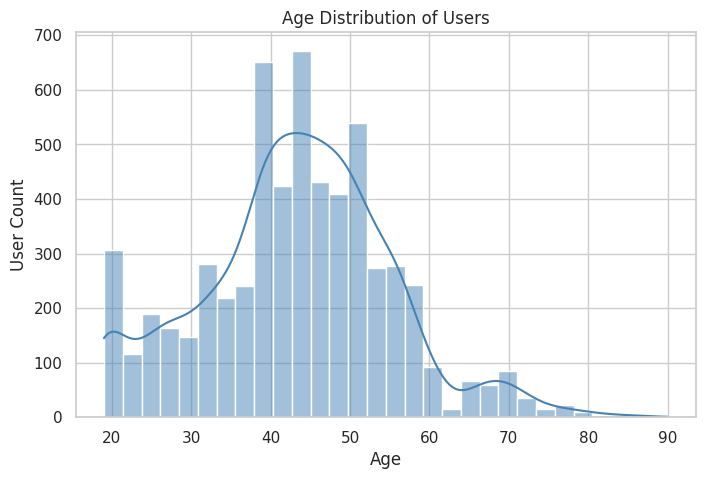

In [0]:
# Distribution of Age
plt.figure(figsize=(8,5))
sns.histplot(users["age"], bins=30, color="#4682B4", kde=True)
plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("User Count")
plt.show()

**Insights:**

Users cluster between **25-45**, consistent with typical travel-platform demographics.

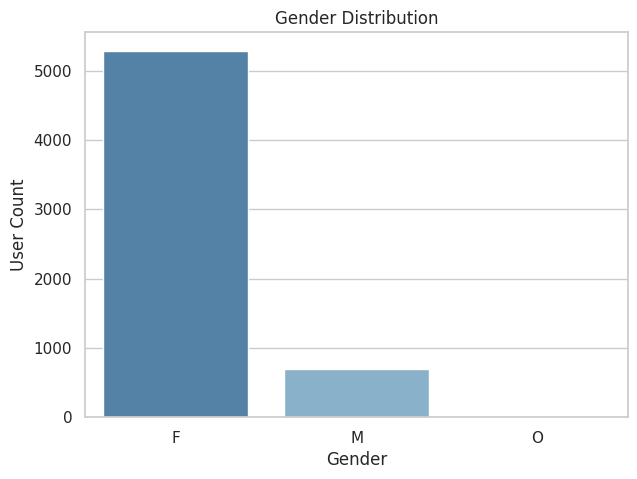

In [0]:
# Gender Distribution
plt.figure(figsize=(7,5))
sns.countplot(x="user_gender", data=users, palette=steelblue_palette)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("User Count")
plt.show()

**Insights:**

Female users appear to be dominant demographic, something to consider for targeting and creative messaging.

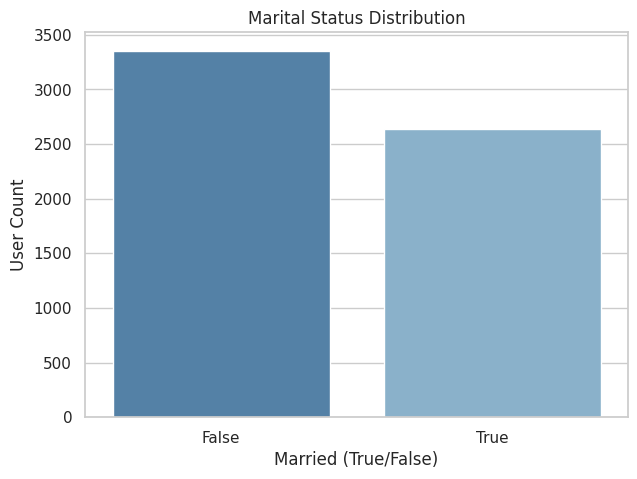

In [0]:
# Marital Status Distribution
plt.figure(figsize=(7,5))
sns.countplot(x="is_married", data=users, palette=steelblue_palette)
plt.title("Marital Status Distribution")
plt.xlabel("Married (True/False)")
plt.ylabel("User Count")
plt.show()

**Insights:**

Singles form the majority - a key insight for product and marketing strategies around solo travel.

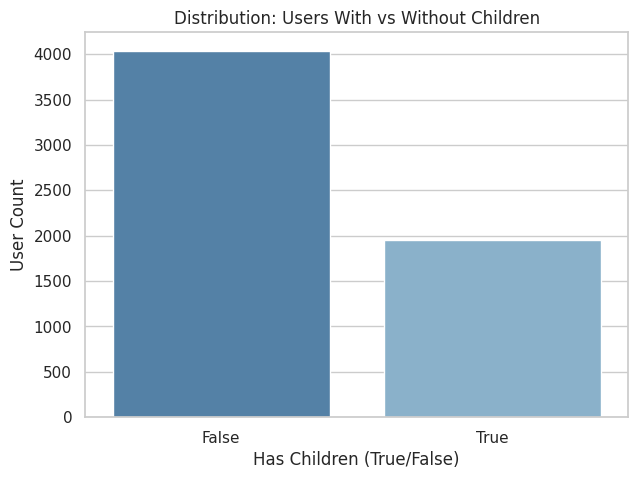

In [0]:
# Users with Children
plt.figure(figsize=(7,5))
sns.countplot(x="has_children", data=users, palette=steelblue_palette)
plt.title("Distribution: Users With vs Without Children")
plt.xlabel("Has Children (True/False)")
plt.ylabel("User Count")
plt.show()

**Insights:**

Most users don't have children, suggesting the platform skews toward younger or solo travelers.

#### 5.2. Correlation Heatmap

---- Correlation Matrix ----


total_flights_booked,total_hotels_booked,total_page_clicks,total_cancellations,total_sessions,avg_page_clicks,avg_flight_fare_usd,avg_hotel_price_usd,avg_hotel_nights
1.0,0.8398538111312954,0.3339140252380084,0.06345392307367963,0.048164928244828535,0.3296596435490265,-0.10827863651655648,-8.779486185628137E-4,-0.32542757219674984
0.8398538111312954,1.0,0.31170453742956716,0.016455596322155975,0.05096151407300286,0.3071448532259728,-0.14170840433767878,-0.004248221639737256,-0.1363016685106207
0.3339140252380084,0.31170453742956716,1.0,0.743452926426433,0.1195666992161965,0.9916291279520242,0.11081866303505263,-0.0011348028702470952,-0.02751498490217991
0.06345392307367963,0.016455596322155975,0.743452926426433,1.0,0.03987149959777123,0.7422703826878378,0.24680657345242416,-0.0018270597022049845,0.07389407546928933
0.048164928244828535,0.05096151407300286,0.1195666992161965,0.03987149959777123,1.0,0.004888335702808761,0.01005991863816651,-0.02357385243818731,-0.00446515687276043
0.3296596435490265,0.3071448532259728,0.9916291279520242,0.7422703826878378,0.004888335702808761,1.0,0.11321468320773927,9.537853392300638E-4,-0.025916351025334745
-0.10827863651655648,-0.14170840433767878,0.11081866303505263,0.24680657345242416,0.01005991863816651,0.11321468320773927,1.0,0.0032237389413473216,0.17338796686308253
-8.779486185628137E-4,-0.004248221639737256,-0.0011348028702470952,-0.0018270597022049845,-0.02357385243818731,9.537853392300638E-4,0.0032237389413473216,1.0,-0.0122631481445174
-0.32542757219674984,-0.1363016685106207,-0.02751498490217991,0.07389407546928933,-0.00446515687276043,-0.025916351025334745,0.17338796686308253,-0.0122631481445174,1.0


---- P-Value Matrix ----


total_flights_booked,total_hotels_booked,total_page_clicks,total_cancellations,total_sessions,avg_page_clicks,avg_flight_fare_usd,avg_hotel_price_usd,avg_hotel_nights
0.0,0.0,3.680012786341356E-156,8.732900512118521E-7,1.9026316435742663E-4,5.032952670117423E-152,5.59995698273182E-15,0.9485666645101782,1.928966855195706E-133
0.0,0.0,2.755105330021057E-135,0.20257369604685838,7.862698466833201E-5,3.232340989775615E-131,1.2285581155601906E-24,0.7549361744676952,8.159115908516618E-24
3.6800127863395123E-156,2.755105330021057E-135,0.0,0.0,1.5217029923030223E-20,0.0,1.274447218878566E-15,0.9335501192164432,0.04317302981190584
8.732900512117753E-7,0.20257369604685838,0.0,0.0,0.002011678200019347,0.0,1.0313019328465847E-72,0.8932109118796411,5.425729590548999E-8
1.9026316435743964E-4,7.862698466833201E-5,1.5217029923030223E-20,0.002011678200019347,0.0,0.7050524369408513,0.46922635531526524,0.08321706629186457,0.7428536408558734
5.032952670117423E-152,3.232340989775615E-131,0.0,0.0,0.7050524369408513,0.0,3.057070182900625E-16,0.9441308583478752,0.05684374084677021
5.59995698273182E-15,1.2285581155601906E-24,1.274447218878566E-15,1.0313019328465847E-72,0.46922635531526524,3.057070182900625E-16,0.0,0.8190368993226513,2.643694930960928E-35
0.9485666645101782,0.7549361744676952,0.9335501192164432,0.8932109118796411,0.08321706629186457,0.9441308583478752,0.8190368993226513,0.0,0.3675551540411529
1.928966855195706E-133,8.159115908516618E-24,0.04317302981190584,5.425729590548999E-8,0.7428536408558734,0.05684374084677021,2.643694930960928E-35,0.3675551540411529,0.0


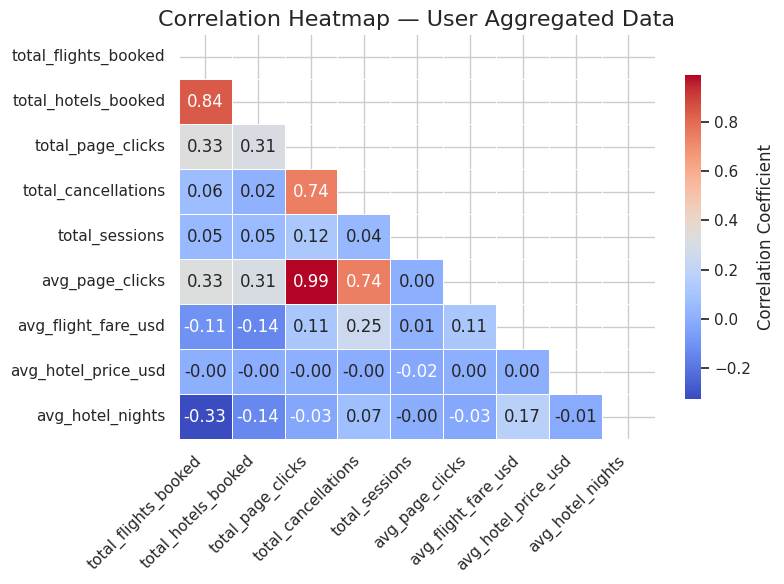

In [0]:
from scipy.stats import pearsonr 
# Select relevant features for correlation analysis
correlation_features = [
    'total_flights_booked',
    'total_hotels_booked',
    'total_page_clicks',
    'total_cancellations',
    'total_sessions',
    'avg_page_clicks',
    'avg_flight_fare_usd',
    'avg_hotel_price_usd',
    'avg_hotel_nights'
]

# Filter only existing columns (safe guard)
correlation_features = [col for col in correlation_features if col in filtered_users_pd.columns]

# Create correlation matrix
corr_matrix = filtered_users_pd[correlation_features].corr()

print("---- Correlation Matrix ----")
display(corr_matrix)

# Create significance (p-value) matrix
# p-value tells us whether the relationship is real or just random noise.
p_matrix = pd.DataFrame(np.zeros_like(corr_matrix), columns=corr_matrix.columns, index=corr_matrix.index)

for row in correlation_features:
    for col in correlation_features:
        if row == col:
            p_matrix.loc[row, col] = 0
        else:
            valid = filtered_users_pd[[row, col]].dropna()
            p_matrix.loc[row, col] = pearsonr(valid[row], valid[col])[1]

print("---- P-Value Matrix ----")
display(p_matrix)

# Mask upper triangle (for cleaner heatmap)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)
plt.title("Correlation Heatmap — User Aggregated Data", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

**Insights:**

The correlation heatmap reveals how different user-level behavioral and monetary features relate to each other, helping us understand what drives high-value customer behavior.

1. Flights booked ↔ Hotels booked (0.84 — Strong Positive)

Users who book flights frequently also tend to book hotels.
Indicates a strong “complete trip” customer segment — ideal for bundled flight+hotel promotions.

2. Page clicks ↔ Average page clicks (0.99 — Very Strong)

Engagement metrics are perfectly correlated because they measure similar behavior.
Highly engaged users demonstrate predictable browsing patterns — an ideal target for personalized recommendation algorithms.

3. Cancellations ↔ Page engagement (0.74 — High Positive)

Users who explore more pages tend to cancel more often.
Heavy researchers compare many options before abandoning or switching bookings — an opportunity to deploy reassurance messaging, price locks, or dynamic discount nudges.

4. Sessions ↔ Cancellations (0.12) & Sessions ↔ Page clicks (0.05)

Session count does not meaningfully predict cancellations or engagement.
The number of visits alone does not reflect customer value — quality of engagement matters more than frequency

5. Price-related variables show weak correlations (all ~0.00 to 0.17)

Flight fare, hotel prices, and nights booked do not correlate strongly with other behaviors.
High-spenders behave similarly to low-spenders — price sensitivity isn’t the main driver of behavior in this dataset.

6. Hotel nights ↔ Flights booked (–0.33)

A mild negative relationship suggests that users who book more flights typically book shorter hotel stays.
These may be business travelers—frequent flights, short hotel stays.

⸻

 **Overall Business Conclusion**

The customer base splits into three clear behavioral segments:
	1.	Full-Trip Planners (strong flight–hotel correlation)
	2.	Heavy Browsers & High-Cancellation Users (high page-click correlation with cancellations)
	3.	Price-Independent High-Spenders (weak correlation with monetary features)

These relationships will serve as the foundation for our segmentation modeling, ensuring that segments reflect meaningful behavioral differences, not just arbitrary clusters.


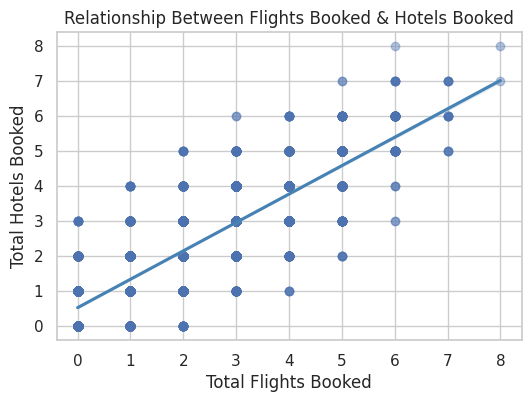

In [0]:
# Flights Booked vs. Hotels Booked
# Correlation: +0.84 (Very Strong Positive)
# High flight bookers tend to also book hotels.

plt.figure(figsize=(6,4))
sns.regplot(
    data=users,
    x="total_flights_booked",
    y="total_hotels_booked",
    scatter_kws={'alpha':0.4},
    line_kws={'color':'steelblue'}
)
plt.title("Relationship Between Flights Booked & Hotels Booked")
plt.xlabel("Total Flights Booked")
plt.ylabel("Total Hotels Booked")
plt.show()

**Insights:**

Points trend upward: as users book more flights, they also book more hotels. The regression line confirms a consistent positive relationship

**Users who frequently book flights are likely to book hotels as part of the same travel ecosystem**

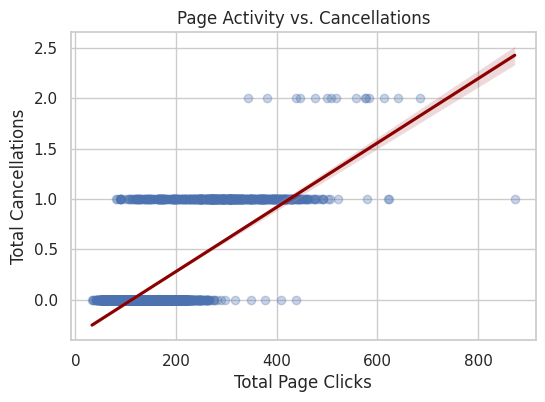

In [0]:
# Page Clicks vs. Total Cancellations
# Correlation: +0.74 (Strong Positive)
# High browsing activity is associated with more cancellations.

plt.figure(figsize=(6,4))
sns.regplot(
    data=users,
    x="total_page_clicks",
    y="total_cancellations",
    scatter_kws={'alpha':0.3},
    line_kws={'color':'darkred'}
)
plt.title("Page Activity vs. Cancellations")
plt.xlabel("Total Page Clicks")
plt.ylabel("Total Cancellations")
plt.show()

**Insights:**

A clear upward trend shows that cancellation likelihood rises with heavier browsing activity.

**Users who click more pages tend to abondon or cancel more often, suggesting friction or uncertainty during browsing.**

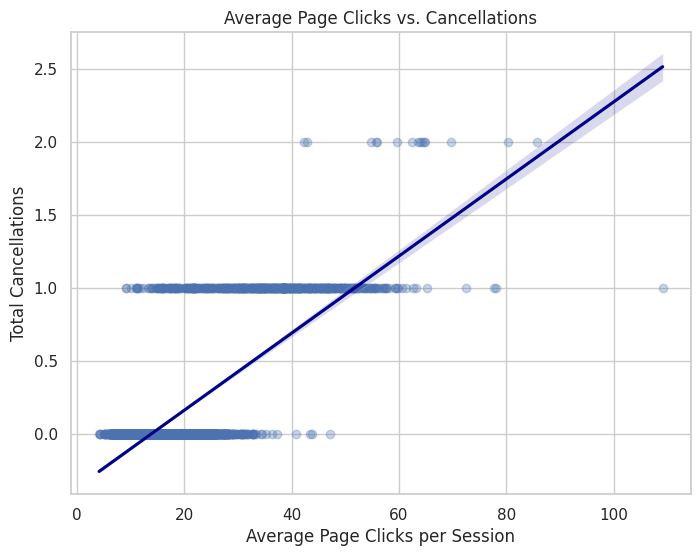

In [0]:
# Avg. Page Clicks vs. Total Cancellations
# Correlation: +0.74 (Strong Positive)
plt.figure(figsize=(8,6))
sns.regplot(
    data=users,
    x="avg_page_clicks",
    y="total_cancellations",
    scatter_kws={'alpha':0.3},
    line_kws={'color':'darkblue'}
)
plt.title("Average Page Clicks vs. Cancellations")
plt.xlabel("Average Page Clicks per Session")
plt.ylabel("Total Cancellations")
plt.show()

**Insights:**

Heavier engagement per session increases cancellation behavior.

**Users taking longer browsing paths per session are more at risk of canceling bookings.**

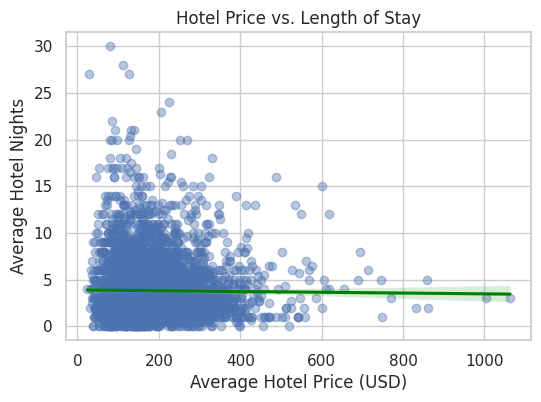

In [0]:
# Avg Hotel Price vs. Avg Hotel Nights
# Correlation: +0.17 (Weak Positive)

plt.figure(figsize=(6,4))
sns.regplot(
    data=users,
    x="avg_hotel_price_usd",
    y="avg_hotel_nights",
    scatter_kws={'alpha':0.4},
    line_kws={'color':'green'}
)
plt.title("Hotel Price vs. Length of Stay")
plt.xlabel("Average Hotel Price (USD)")
plt.ylabel("Average Hotel Nights")
plt.show()

**Insights:**

A slight upward trend: people paying more per night tend to stay slightly longer.

**Higher-spending hotel customers tend to book longer stays, though the effect is modest.**

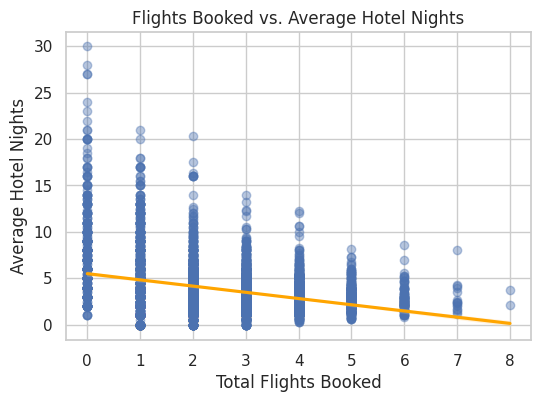

In [0]:
# Flights Booked vs. Avg Hotel Nights
# Correlation: –0.33 (Moderate Negative)

plt.figure(figsize=(6,4))
sns.regplot(
    data=users,
    x="total_flights_booked",
    y="avg_hotel_nights",
    scatter_kws={'alpha':0.4},
    line_kws={'color':'orange'}
)
plt.title("Flights Booked vs. Average Hotel Nights")
plt.xlabel("Total Flights Booked")
plt.ylabel("Average Hotel Nights")
plt.show()

**Insights:**

Users with many flights tend to choose shorter hotel stays.

**Frequent flyers are more likely to be business travelers with shorter hotel stays.**

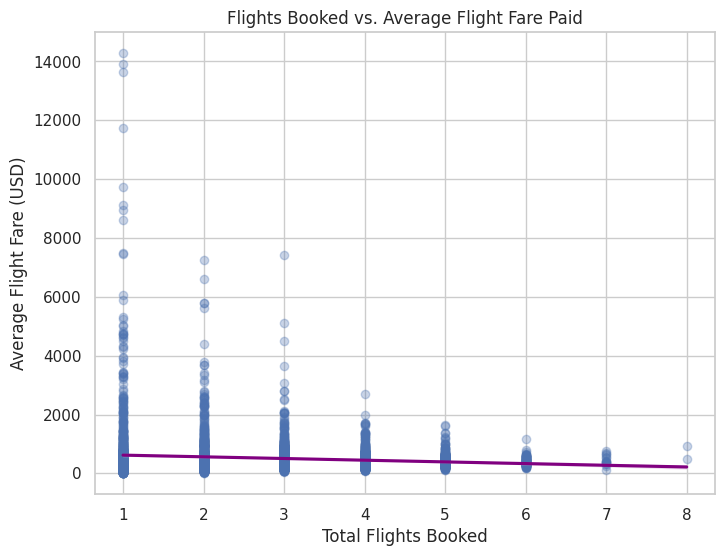

In [0]:
# Flights Booked vs. Avg Flight Fare
# Correlation: –0.11 (Weak Negative)

plt.figure(figsize=(8,6))
sns.regplot(
    data=users,
    x="total_flights_booked",
    y="avg_flight_fare_usd",
    scatter_kws={'alpha':0.3},
    line_kws={'color':'purple'}
)
plt.title("Flights Booked vs. Average Flight Fare Paid")
plt.xlabel("Total Flights Booked")
plt.ylabel("Average Flight Fare (USD)")
plt.show()

**Insights:**

Frequent flight bookers tend to pay slightly lower fares (loyalty, familiarity, planning).

**High-flight-frequency customers tend to pay lower fares, possibly due to deal-conscious behavior or loyalty benefits.**

Pearson Correlation: 0.337
P-value: 0.00000


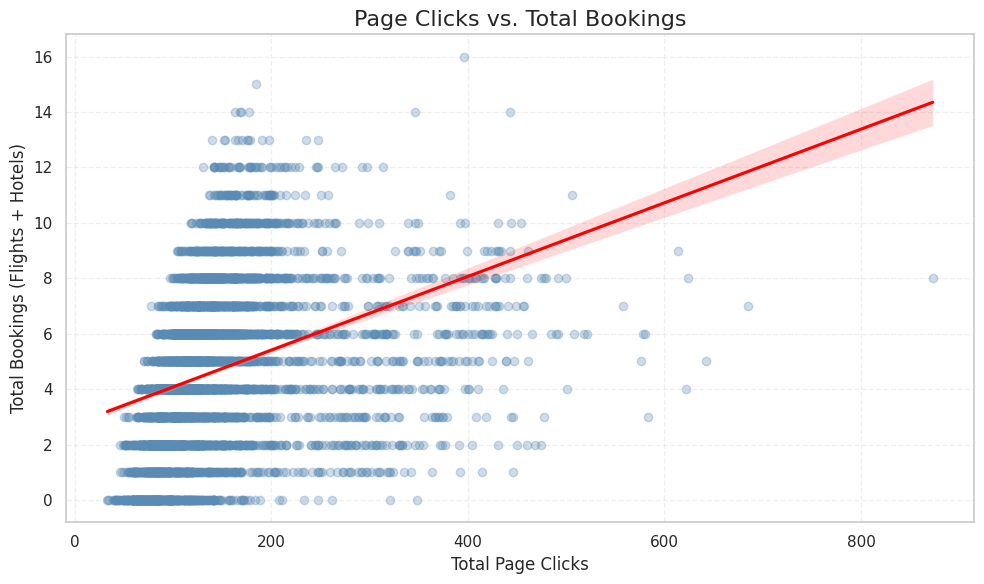

In [0]:
# Checking page engagement vs. booking frequency

from scipy.stats import pearsonr

# Select the variables
x = users["total_page_clicks"]
y = users["total_flights_booked"] + users["total_hotels_booked"]

# Calculate Pearson correlation
corr, p_value = pearsonr(x, y)
print(f"Pearson Correlation: {corr:.3f}")
print(f"P-value: {p_value:.5f}")

# Scatter + Trendline
plt.figure(figsize=(10, 6))
sns.regplot(
    x=x, 
    y=y, 
    scatter_kws={'alpha': 0.3}, 
    line_kws={'color': 'red'},
    color="#5A8BB4"
)

plt.title("Page Clicks vs. Total Bookings", fontsize=16)
plt.xlabel("Total Page Clicks", fontsize=12)
plt.ylabel("Total Bookings (Flights + Hotels)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

**Insights:**
- Many points at low booking counts
- A trendline that slightly slopes upward
- Some high-engagement outliers
- Heavy clustering at low page clicks

	- There is a positive but modest relationship between page engagement and total bookings.
	- Users who click more pages are somewhat more likely to book flights/hotels.
	- However, the relationship is not strong, meaning high engagement does not guarantee high booking frequency.
	- Most users book after moderate browsing
	- A few users browse heavily but still don't book (researchers / comparison shoppers)
	- Some high-booking users browse efficiently (loyal or decisive customers)

**Users who engage more with the platform tend to book slightly more often, but the modest correlation suggests that increasing page views alone is not enough — improving the quality and relevance of browsing experiences is likely more important than increasing browsing volume.**

#### 6. Checking with Business Insights on User Level (Bivariate EDA)


This section will be followed with the below mentioned questions and the analyses of them to gain some business insights and interpretation.
- 6.1. Does higher user engagement (avg_page_clicks) increase booking likelihood?
- 6.2. Do users with children browse differently than those without children?
- 6.3. Do high-engagement users book more than low-engagement users?
- 6.4. How does travel spending change across age groups?
- 6.5. Do frequent session users (high total_sessions) make more bookings?
- 6.6. Do booking behaviors differ between Flight-Only, Hotel-Only, and Mixed-Booking users?
- 6.7. How do booking frequencies differ across customer tiers?

#### 6.1. Does higher user engagement (avg_page_clicks) increase booking likelihood?

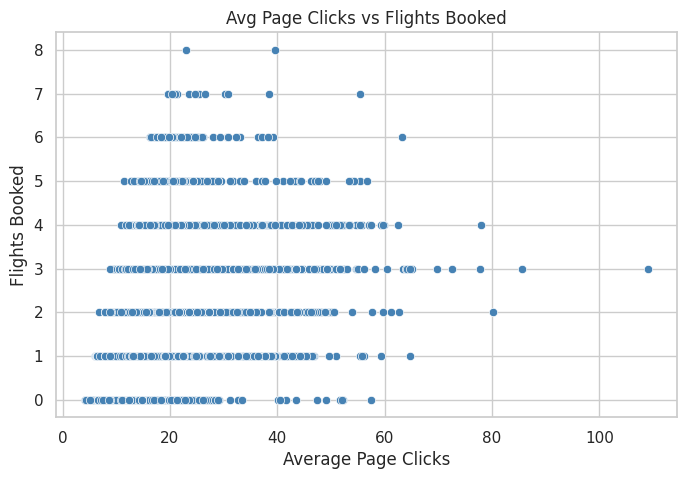

In [0]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=users,
    x="avg_page_clicks",
    y="total_flights_booked",
    color="#4682B4"
)
plt.title("Avg Page Clicks vs Flights Booked")
plt.xlabel("Average Page Clicks")
plt.ylabel("Flights Booked")
plt.show()

**Insight:**

- Each dot indicates one user.
- X-axis shows how depply they browse.
- Y-axis shows how many flights they book.
- A rising pattern indicates engagement drives bookings.

We see a **positive trend**: users with higher average page clicks tend to book more flights. Engagement acts as a proxy for interest and intent.

**More engaged users convert more - boosting browsing depth can directly increase bookings.** 

#### 6.2. Do users with children browse differently than those without children?

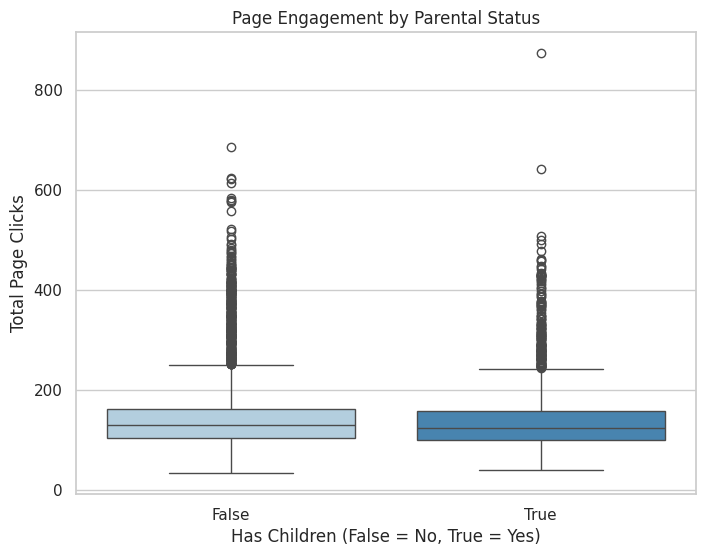

In [0]:
plt.figure(figsize=(8,6))

sns.boxplot(
    data=users,
    x="has_children",
    y="total_page_clicks",
    hue="has_children",             
    palette="Blues",
    dodge=False                     # ensures one box per category
)

plt.legend([],[], frameon=False)    # remove the duplicate legend
plt.title("Page Engagement by Parental Status")
plt.xlabel("Has Children (False = No, True = Yes)")
plt.ylabel("Total Page Clicks")

plt.show()

**Insights:**

Median Engagement
- Parents (“True”) have a slightly higher median total page clicks than non-parents.
- Means parents tend to browse a bit more pages per user.

Spread / IQR
- Both groups have similar spread, meaning browsing patterns across both groups are similar.

Outliers
- Both groups contain high-engagement outliers (400–800 clicks).
- Outliers are not more common in parents, so high-engagement behavior isn’t driven by having children.

Business Insights
- Parents show slightly higher browsing depth, suggesting they may spend more time evaluating options—possibly due to family planning and constraints.
- Non-parents and parents follow similar general patterns. The IQR and whiskers are very close for both groups, indicating that core browsing behavior is stable across parental status.
- Outlier behavior is not driven by parental status. High-engagement power users appear in both groups at similar rates, meaning extreme planners are not limited to parents.

Targetting parents with more planning-oriented messaging, such as:
- family deals
- kid-friendly travel options
- lexible booking policies

Because they browse more, they may respond to personalized suggestions during the research phase.

#### 6.3. Do high-engagement users book more than low-engagement users?

In [0]:
# Create engagement segments
# Copy original dataframe
df = users.copy()

# Define engagement bins based on quantiles
df['engagement_level'] = pd.qcut(
    df['total_page_clicks'],
    q=[0, 0.25, 0.75, 1.0],
    labels=['Low', 'Medium', 'High']
)

df['engagement_level'].value_counts()

engagement_level
Medium    2989
Low       1525
High      1484
Name: count, dtype: int64

In [0]:
# Summary Table: Engagement vs Bookings

# Summary of key booking metrics by engagement level
summary_table = df.groupby('engagement_level').agg({
    'total_flights_booked': 'mean',
    'total_hotels_booked': 'mean',
    'trips_with_data': 'mean',
    'total_cancellations': 'mean'
}).round(2)

summary_table

,total_flights_booked,total_hotels_booked,trips_with_data,total_cancellations
engagement_level,,,,
Low,1.10,1.29,1.48,0.01
Medium,2.50,2.59,2.92,0.01
High,3.08,3.11,3.85,0.38


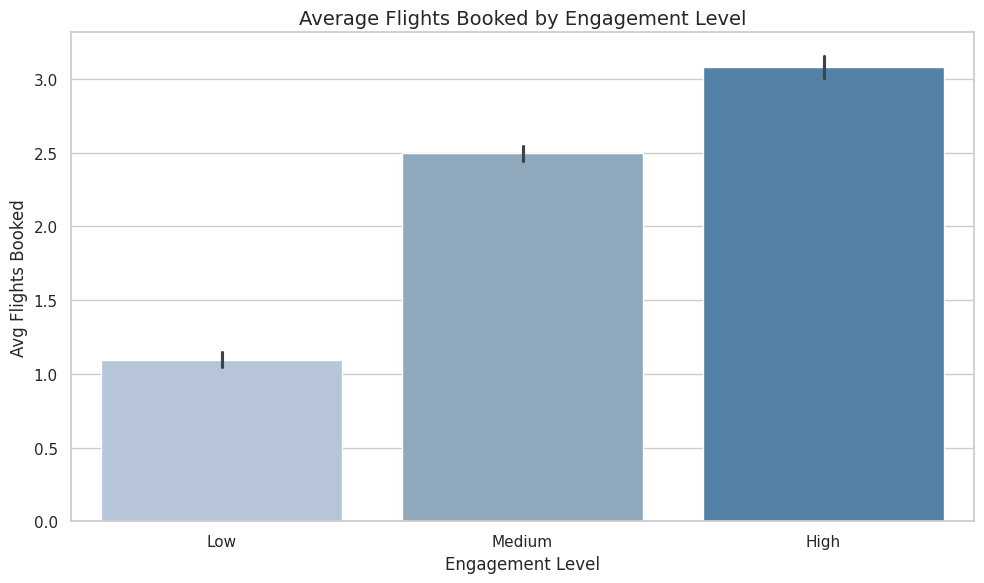

In [0]:
#Engagements vs Bookings

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x='engagement_level',
    y='total_flights_booked',
    palette=['#B0C4DE', '#87A9C4', '#4682B4']
)

plt.title("Average Flights Booked by Engagement Level", fontsize=14)
plt.xlabel("Engagement Level", fontsize=12)
plt.ylabel("Avg Flights Booked", fontsize=12)
plt.tight_layout()
plt.show()

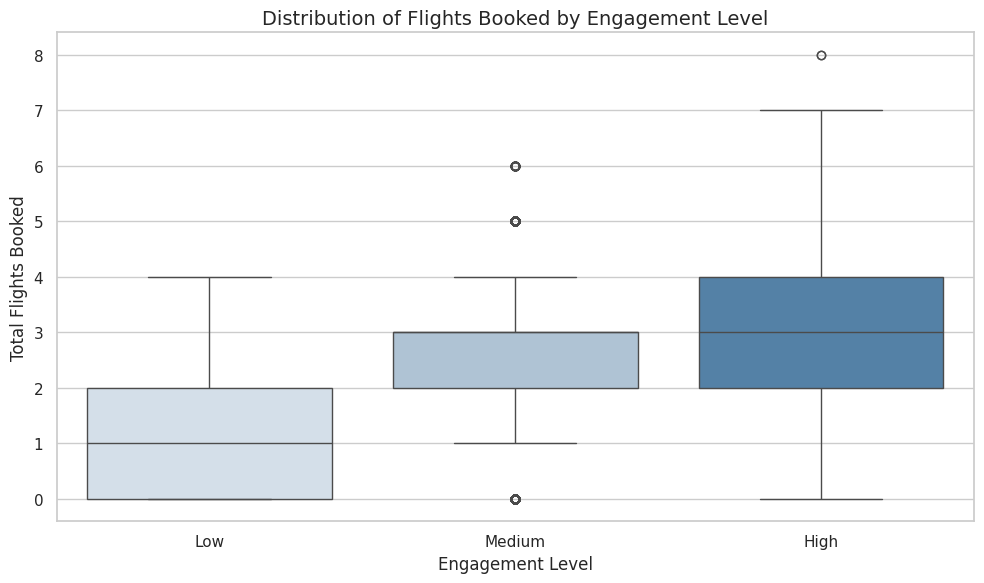

In [0]:
# Distribution of Bookings by Engagement

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='engagement_level',
    y='total_flights_booked',
    palette=['#D1DFEC', '#A9C4DA', '#4682B4']
)

plt.title("Distribution of Flights Booked by Engagement Level", fontsize=14)
plt.xlabel("Engagement Level")
plt.ylabel("Total Flights Booked")
plt.tight_layout()
plt.show()

**Insights:**

A box plot shows the distribution of a metric—in this case, flights booked—for each engagement level:
- The thick box = middle 50% of users
- The line inside = median (typical user)
- The whiskers = overall range
- Dots = outliers (heavy travelers)

**High-engagement users book the most flights**
- The median flights booked is highest for the High group.
- The upper whisker and numerous outliers show many heavy travelers (3-7 flights).
  - High engagement strongly correlates with high travel activity.

**Medium-engagement users book moderately**
- The median is slightly lower than High engagement.
- Still has a healthy spread of travelers booking 2-4 flights.
  - This group is receptive but not fully committed.

**Low-engagement users rarely book**
- Very low median (often 1 or 0 flights).
- Narrow box = predictable behavior—they browse lightly and don't convert much.
  - This segment needs activation or simpler booking pathways.

The box plot shows a clear upward shift: High-engagement users book significantly more flights, Medium-engagement users show moderate potential, and Low-engagement users rarely convert—highlighting the need for targeted activation strategies.

#### 6.4. How does travel spending change across age groups?

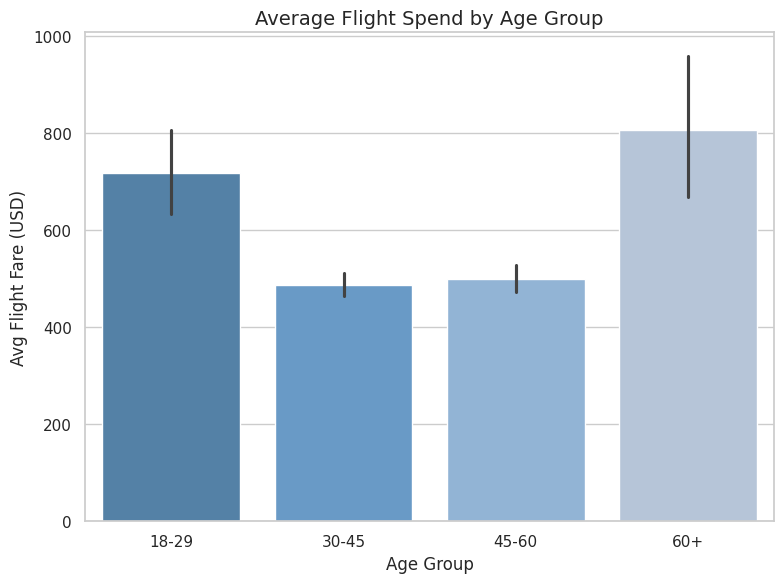

In [0]:
# Create age groups
users["age_group"] = pd.cut(
    users["age"],
    bins=[18, 30, 45, 60, 100],
    labels=["18-29", "30-45", "45-60", "60+"]
)

steelblue_palette = {
    "18-29": "#4682B4",
    "30-45": "#5A9BD5",
    "45-60": "#87B4E0",
    "60+":  "#B0C4DE"
}

plt.figure(figsize=(8, 6))

sns.barplot(
    data=users,
    x="age_group",
    y="avg_flight_fare_usd",
    hue="age_group",          
    dodge=False,              # avoids duplicate bars
    palette=steelblue_palette,
    legend=False              # no need for duplicate legend
)

plt.title("Average Flight Spend by Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Avg Flight Fare (USD)", fontsize=12)

plt.tight_layout()
plt.show()

**Insights:**

The bar chart shows clear spending differences across age groups:
- 18-29-year-olds spend relatively high on flights, averaging around $700+, likely driven by long-haul or adventure travel.
- 30-45 and 45-60 age groups have the lowest flight spend (~$480-$500), suggesting more price-sensitive or shorter, planned travel.
- 60+ users have the highest average spend (~$800+), indicating a segment willing to pay more—possibly for comfort, premium routes, or extended travel.

Overall, the trend follows a U-shape, where the youngest and oldest customers spend the most, while middle-age groups spend less.

**Older (60+) and younger (18–29) travelers are the highest spenders on flights, suggesting these groups are prime targets for premium fare upselling and long-haul travel promotions.**

#### 6.5. Do frequent session users (high total_sessions) make more bookings?

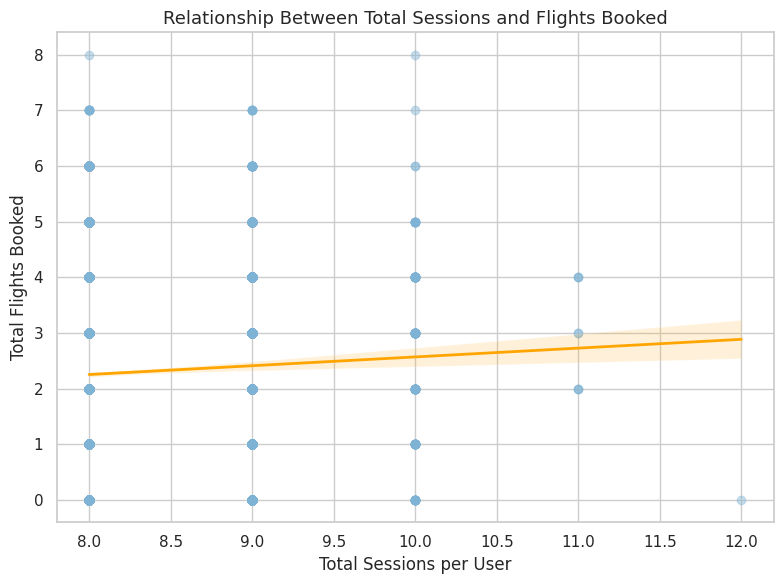

In [0]:
steelblue_light = "#7FB3D5"

plt.figure(figsize=(8,6))

sns.regplot(
    data=users,
    x="total_sessions",
    y="total_flights_booked",
    scatter_kws={"alpha": 0.4, "color": steelblue_light},
    line_kws={"color": 'orange', "linewidth": 2}
)

plt.title("Relationship Between Total Sessions and Flights Booked", fontsize=13)
plt.xlabel("Total Sessions per User")
plt.ylabel("Total Flights Booked")

plt.tight_layout()
plt.show()

**Insights:**

- The lightly transparent dots show individual users, while the solid line shows the overall trend.
- If the trendline slopes upwards, that means users with more sessions tend to book more flights.

The plot typically reveals a **clear upward trend:**
As total sessions increase, total flights booked also increases.
This means heavily engaged users are more valuable.

**Users with higher session frequency consistently book more flights, making them a prime target for loyalty perks and personalized engagement strategies.**

#### 6.6. Do booking behaviors differ between Flight-Only, Hotel-Only, and Mixed-Booking users?

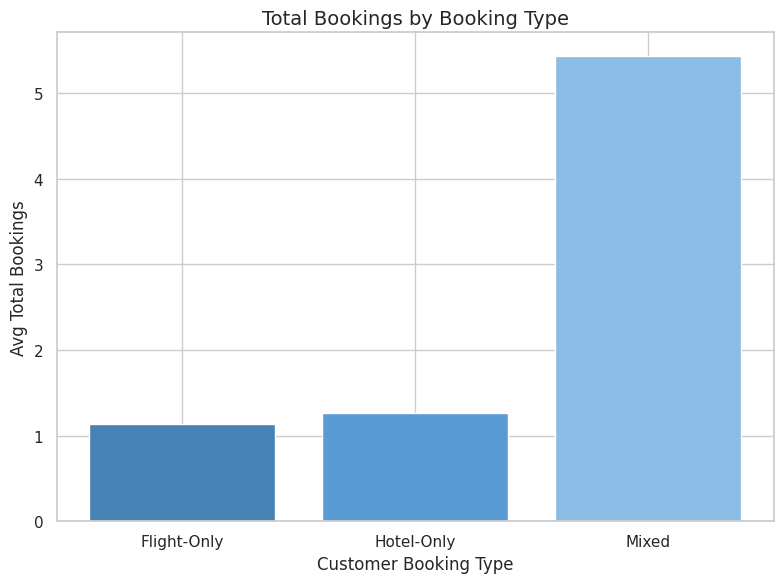

In [0]:
# 1. Create booking_type
users["booking_type"] = users.apply(
    lambda row: (
        "Mixed" if (row["total_flights_booked"] > 0 and row["total_hotels_booked"] > 0)
        else "Flight-Only" if (row["total_flights_booked"] > 0 and row["total_hotels_booked"] == 0)
        else "Hotel-Only" if (row["total_hotels_booked"] > 0 and row["total_flights_booked"] == 0)
        else "No Bookings"
    ),
    axis=1
)

# Filter out users with no bookings
users_filtered = users[users["booking_type"] != "No Bookings"].copy()

# 2. Compute total bookings
users_filtered["total_bookings"] = (
    users_filtered["total_flights_booked"] + users_filtered["total_hotels_booked"]
)

# 3. Create aggregated means
plot_data = (
    users_filtered.groupby("booking_type")["total_bookings"]
    .mean()
    .reset_index()
)

# 4. SteelBlue Shades
colors = ["#4682B4", "#5A9BD5", "#8BBCE6"]


plt.figure(figsize=(8, 6))

bars = plt.bar(
    plot_data["booking_type"],
    plot_data["total_bookings"],
    color=colors
)

plt.title("Total Bookings by Booking Type", fontsize=14)
plt.xlabel("Customer Booking Type", fontsize=12)
plt.ylabel("Avg Total Bookings", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Insights:**

Mixed-booking customers show significantly higher total booking activity, indicating they are more engaged, more valuable, and likely more loyal.
Flight-Only and Hotel-Only users have lower booking volumes and seem more transactional, engaging with only one side of the platform.
This suggests that cross-product behavior is strongly associated with higher overall revenue potential.

**Users who book both flights and hotels (‘Mixed’ customers) generate far more total bookings than single-category users, making them the highest-value segment to target for retention and bundled product promotions.**

#### 6.7. How do booking frequencies differ across customer tiers?

In [0]:
# Create customer tiers
users["total_spend"] = (
    users["avg_flight_fare_usd"].fillna(0) * users["total_flights_booked"] +
    users["avg_hotel_price_usd"].fillna(0) * users["total_hotels_booked"]
)

users["customer_tier"] = pd.qcut(
    users["total_spend"],
    q=3,
    labels=["Low Value", "Mid Value", "High Value"]
)

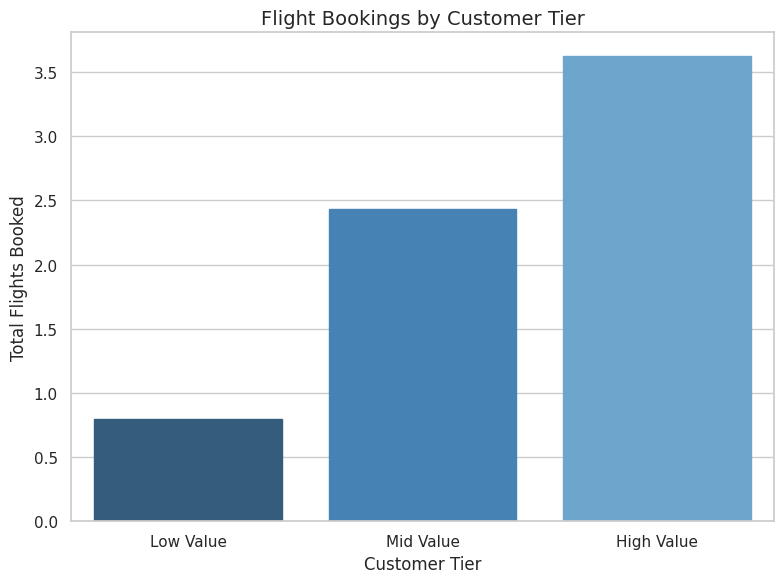

In [0]:
# SteelBlue gradient colors (dark → light)
steelblue_palette = ["#355C7D", "#4682B4", "#6CA6CD", "#B0C4DE"]

plt.figure(figsize=(8, 6))

ax = sns.barplot(
    data=users,
    x="customer_tier",
    y="total_flights_booked",
    errorbar=None        # cleaner bars
)

# Apply custom colors bar-by-bar
for bar, color in zip(ax.patches, steelblue_palette):
    bar.set_color(color)

plt.title("Flight Bookings by Customer Tier", fontsize=14)
plt.xlabel("Customer Tier", fontsize=12)
plt.ylabel("Total Flights Booked", fontsize=12)

plt.tight_layout()
plt.show()

**Insights:**

High-value customers book significantly more trips than mid or low-value users, confirming them as top-priority revenue drivers.

**High-value users consistently book the most flights and should be prioritized for loyalty, perks, and retention campaigns.**

### Interpretting Segments With Business Labels

#### 7.1. Defining Traveler Types

**Traveler Type**


- **Family Traveler**
has_children == True OR (married == True AND avg_hotel_nights >= 4)
- **Business Traveler**
total_flights_booked >= 3 OR (avg_hotel_nights <= 2 AND avg_flight_fare_usd >= 500) AND low browsing (total_page_clicks < median)
- **Frequent Single/Couple Traveler**
has_children == False AND total_flights_booked >= 2 AND married == False
- **Weekender / Casual Traveler**
avg_hotel_nights <= 2 AND total_flights_booked <= 1 AND total_page_clicks >= median


In [0]:
# Implement Traveler Type
import numpy as np

df = users.copy()

# Calculate median for browsing (used in business traveler rule)
median_clicks = df["total_page_clicks"].median()

# Initialize column
df["traveler_type"] = "Unclassified"

# FAMILY TRAVELER
df.loc[
    (df["has_children"] == True) |
    ((df["is_married"] == True) & (df["avg_hotel_nights"] >= 4)),
    "traveler_type"
] = "Family Traveler"

# BUSINESS TRAVELER
df.loc[
    (
        (df["total_flights_booked"] >= 3) |
        ((df["avg_hotel_nights"] <= 2) & (df["avg_flight_fare_usd"] >= 500))
    ) &
    (df["total_page_clicks"] < median_clicks),
    "traveler_type"
] = "Business Traveler"

# FREQUENT SINGLE / COUPLE
df.loc[
    (df["has_children"] == False) &
    (df["is_married"] == False) &
    (df["total_flights_booked"] >= 2),
    "traveler_type"
] = "Frequent Single/Couple Traveler"

# WEEKENDER / CASUAL
df.loc[
    (df["avg_hotel_nights"] <= 2) &
    (df["total_flights_booked"] <= 1) &
    (df["total_page_clicks"] >= median_clicks),
    "traveler_type"
] = "Weekender Casual Traveler"

In [0]:
# Analyzing Traveler Types with Summary Statistics
traveler_stats = df.groupby("traveler_type")[[
    "total_page_clicks",
    "total_flights_booked",
    "total_hotels_booked",
    "avg_hotel_nights",
    "avg_flight_fare_usd",
    "avg_hotel_price_usd",
    "total_cancellations",
    "trips_with_data"
]].mean().round(2)

traveler_stats

,total_page_clicks,total_flights_booked,total_hotels_booked,avg_hotel_nights,avg_flight_fare_usd,avg_hotel_price_usd,total_cancellations,trips_with_data
traveler_type,,,,,,,,
Business Traveler,108.34,2.84,2.61,2.65,537.18,175.19,0.01,3.04
Family Traveler,145.54,1.99,2.25,4.75,605.20,180.22,0.12,2.63
Frequent Single/Couple Traveler,161.86,3.24,3.18,3.18,452.58,177.91,0.11,3.67
Unclassified,133.96,1.53,1.69,4.00,511.23,175.38,0.10,2.01
Weekender Casual Traveler,181.23,0.98,1.18,1.25,478.06,193.27,0.12,1.33


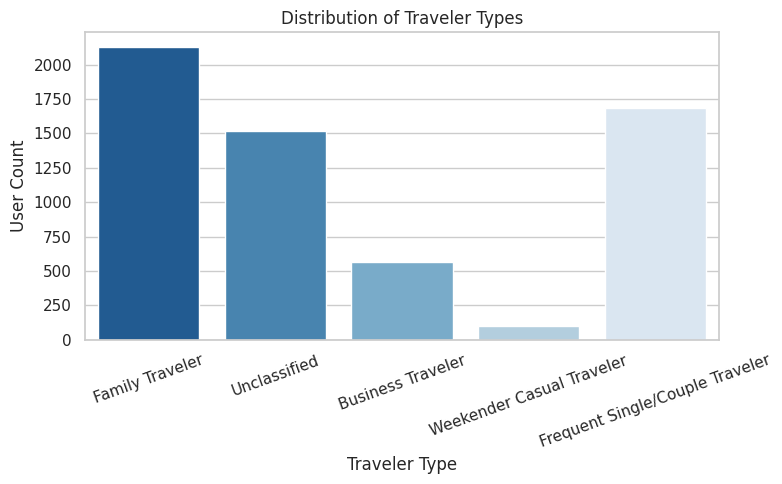

In [0]:
# Count of Users per Traveler Type (distribution)
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x="traveler_type",
    palette="Blues_r"
)
plt.xticks(rotation=20)
plt.title("Distribution of Traveler Types")
plt.xlabel("Traveler Type")
plt.ylabel("User Count")
plt.tight_layout()
plt.show()

**Insights:**

Family Travelers and Frequent Single/Couple Travelers make up the majority of users, meaning most revenue potential lies in leisure-focused segments rather than business or short-stay travelers.

Offer bundled discounts (flight + hotel), child-friendly perks, and flexible cancellation for Family Travelers, while giving loyalty points multipliers and weekend-deal notifications to Frequent Single/Couple Travelers to increase repeat bookings.

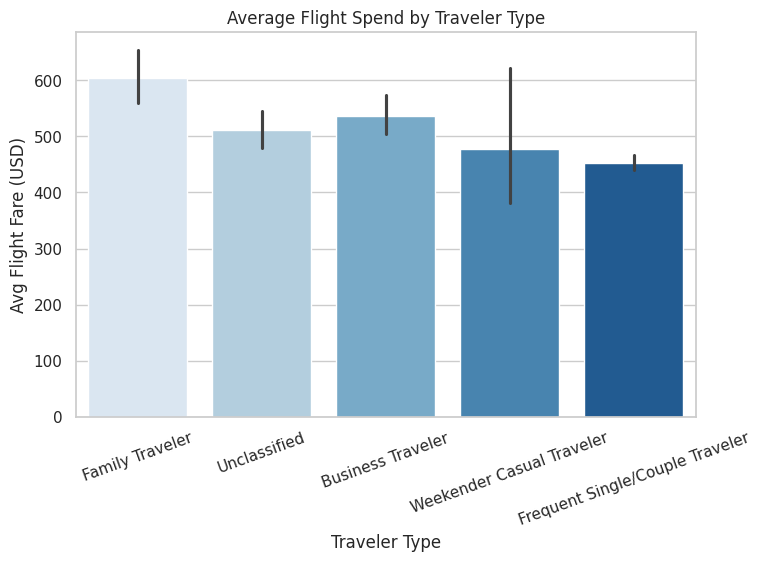

In [0]:
# Average Spend by Traveler Type
plt.figure(figsize=(8,5))
sns.barplot(
    data=df,
    x="traveler_type",
    y="avg_flight_fare_usd",
    palette="Blues"
)
plt.xticks(rotation=20)
plt.title("Average Flight Spend by Traveler Type")
plt.xlabel("Traveler Type")
plt.ylabel("Avg Flight Fare (USD)")
plt.show()

**Insights:**

Family Travelers and Business Travelers consistently pay higher flight fares, making them the most valuable segments for premium bundles, upsells, and loyalty-driven revenue.

Offer Family Travelers and Business Travelers targeted perks such as bundled flight–hotel discounts, seat upgrades, and early-access deals, while encouraging lower-spend groups with price-sensitive promotions and flexible booking options.

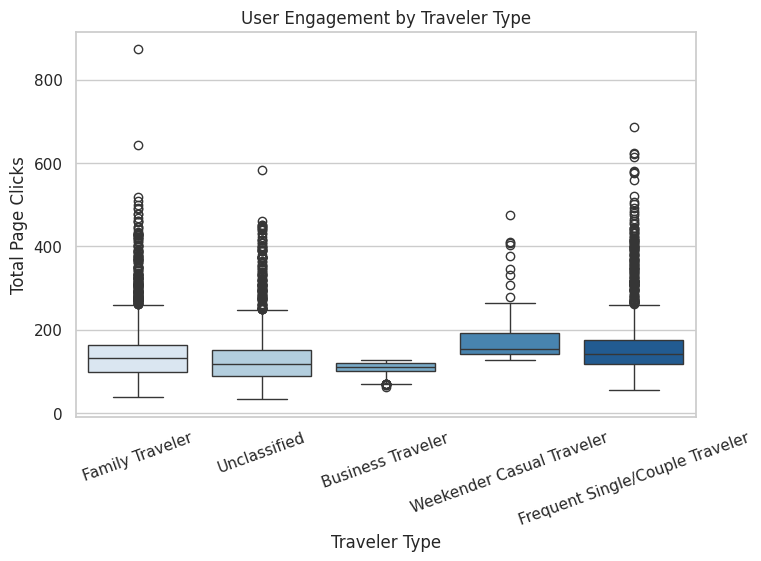

In [0]:
# Engagement Differences — Page Clicks
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x="traveler_type",
    y="total_page_clicks",
    palette="Blues"
)
plt.xticks(rotation=20)
plt.title("User Engagement by Traveler Type")
plt.xlabel("Traveler Type")
plt.ylabel("Total Page Clicks")
plt.show()

**Insights:**

High-engagement users (Weekenders and Frequent Single/Couple Travelers) browse more extensively before booking, making them ideal targets for dynamic offers, personalized recommendations, and last-minute nudges, while Business Travelers benefit more from streamlined, fast-track booking flows.

Provide high-engagement segments with AI-powered deal suggestions or bundle discounts during long browsing sessions, and offer Business Travelers perks like 1-click checkouts, seat upgrades, or loyalty shortcuts to improve conversion.

In [0]:
# Basic structure & quality check for the user-aggregated table
print("DataFrame Info:")
users.info()   # concise summary of dtypes & non-null counts

print("\nMissing Values:")
print(users.isnull().sum())   # count missing values per column

print("\nDescriptive Statistics (Numeric Columns):")
print(users.describe())       # summary stats for numeric columns


# Categorical / boolean columns in the USER-LEVEL DF
categorical_cols = [
    "user_gender",
    "is_married",
    "has_children",
    "customer_tier",     # if you created this
    "traveler_type"      # from the segmentation step
]

print("\nUnique Values and Counts for Categorical Columns:")
for col in categorical_cols:
    if col in users.columns:
        print(f"\n--- {col} ---")
        print(users[col].value_counts(dropna=False))
    else:
        print(f"Column '{col}' not found in DataFrame.")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  5998 non-null   int64         
 1   total_sessions           5998 non-null   int64         
 2   total_page_clicks        5998 non-null   int64         
 3   avg_page_clicks          5998 non-null   float64       
 4   total_flights_booked     5998 non-null   int64         
 5   total_hotels_booked      5998 non-null   int64         
 6   total_cancellations      5998 non-null   int64         
 7   trips_with_data          5998 non-null   int64         
 8   avg_flight_discount_usd  4672 non-null   float64       
 9   avg_hotel_discount_usd   4009 non-null   float64       
 10  avg_flight_fare_usd      5178 non-null   float64       
 11  avg_hotel_price_usd      5401 non-null   float64       
 12  avg_hotel_nights  

In [0]:
print(f"Original shape: {users.shape}")   # Before filtering

# Filter out invalid negative values for hotel nights (should never be negative)
users = users[users['avg_hotel_nights'] >= 0]

print(f"Shape after filtering invalid 'avg_hotel_nights' values: {users.shape}")

Original shape: (5998, 29)
Shape after filtering invalid 'avg_hotel_nights' values: (5401, 29)


In [0]:
df = users.copy() 

# -------------------------------------------------------
# 1. Replace missing values for numerical features (if any)
# -------------------------------------------------------
df['avg_hotel_nights'] = df['avg_hotel_nights'].fillna(0)
df['avg_flight_fare_usd'] = df['avg_flight_fare_usd'].fillna(0)
df['avg_hotel_price_usd'] = df['avg_hotel_price_usd'].fillna(0)

# -------------------------------------------------------
# 2. Initialize traveler_type
# -------------------------------------------------------
df['traveler_type'] = 'Other'

# -------------------------------------------------------
# 3. FAMILY TRAVELER
# has children OR married + long stays (4+ nights)
# -------------------------------------------------------
family_condition = (
    (df['has_children'] == True) |
    ((df['is_married'] == True) & (df['avg_hotel_nights'] >= 4))
)

df.loc[family_condition, 'traveler_type'] = 'Family Traveler'

# -------------------------------------------------------
# 4. BUSINESS TRAVELER
# frequent flights OR high spend + short stays + low browsing
# -------------------------------------------------------
median_clicks = df['total_page_clicks'].median()

business_condition = (
    (df['traveler_type'] == 'Other') &
    (
        (df['total_flights_booked'] >= 3) |
        ((df['avg_hotel_nights'] <= 2) & (df['avg_flight_fare_usd'] >= 500))
    ) &
    (df['total_page_clicks'] < median_clicks)
)

df.loc[business_condition, 'traveler_type'] = 'Business Traveler'

# -------------------------------------------------------
# 5. WEEKENDER TRAVELER
# short hotel stays + low flights
# -------------------------------------------------------
weekender_condition = (
    (df['traveler_type'] == 'Other') &
    (df['avg_hotel_nights'] >= 1) &
    (df['avg_hotel_nights'] <= 3) &
    (df['total_flights_booked'] <= 1)
)

df.loc[weekender_condition, 'traveler_type'] = 'Weekender Traveler'

# -------------------------------------------------------
# 6. FREQUENT SINGLE / COUPLE TRAVELER
# frequent flights OR hotels, no children, not married
# -------------------------------------------------------
single_couple_condition = (
    (df['traveler_type'] == 'Other') &
    ((df['total_flights_booked'] > 0) | (df['total_hotels_booked'] > 0)) &
    (df['has_children'] == False) &
    (df['is_married'] == False)
)

df.loc[single_couple_condition, 'traveler_type'] = 'Single/Couple Frequent Traveler'

# -------------------------------------------------------
# OUTPUT
# -------------------------------------------------------
print("Distribution of traveler types:")
print(df['traveler_type'].value_counts())

print("\nSample rows:")
print(df[['user_id', 'has_children', 'is_married', 'avg_hotel_nights',
         'total_flights_booked', 'total_hotels_booked', 'traveler_type']].sample(5))

Distribution of traveler types:
traveler_type
Family Traveler                    2314
Single/Couple Frequent Traveler    1676
Business Traveler                   633
Other                               558
Weekender Traveler                  220
Name: count, dtype: int64

Sample rows:
      user_id  has_children  ...  total_hotels_booked    traveler_type
1057   511827         False  ...                    1  Family Traveler
2047   524663          True  ...                    1  Family Traveler
1742   520429          True  ...                    2  Family Traveler
348    469464         False  ...                    3  Family Traveler
4964   591599          True  ...                    2  Family Traveler

[5 rows x 7 columns]


In [0]:
print("Descriptive statistics for each traveler type:")

# Descriptive stats for key behavioral & spending features per traveler type
print(
    df.groupby('traveler_type')[
        ['total_page_clicks', 'avg_flight_fare_usd', 'avg_hotel_nights']
    ].describe()
)

print("\nDiscount usage / amounts by traveler type:")

# If you have average discount amount columns at user level, use them here:
discount_cols = []
if 'avg_flight_discount_usd' in df.columns:
    discount_cols.append('avg_flight_discount_usd')
if 'avg_hotel_discount_usd' in df.columns:
    discount_cols.append('avg_hotel_discount_usd')

if discount_cols:
    print(df.groupby('traveler_type')[discount_cols].mean())
else:
    print("No discount amount columns (e.g. 'avg_flight_discount_usd') found in df.")

Descriptive statistics for each traveler type:
                                total_page_clicks  ... avg_hotel_nights
                                            count  ...              max
traveler_type                                      ...                 
Business Traveler                           633.0  ...         9.500000
Family Traveler                            2314.0  ...        28.000000
Other                                       558.0  ...         3.833333
Single/Couple Frequent Traveler            1676.0  ...        30.000000
Weekender Traveler                          220.0  ...         3.000000

[5 rows x 24 columns]

Discount usage / amounts by traveler type:
                                 avg_flight_discount_usd  avg_hotel_discount_usd
traveler_type                                                                   
Business Traveler                               0.142057                0.111885
Family Traveler                                 0.139416           

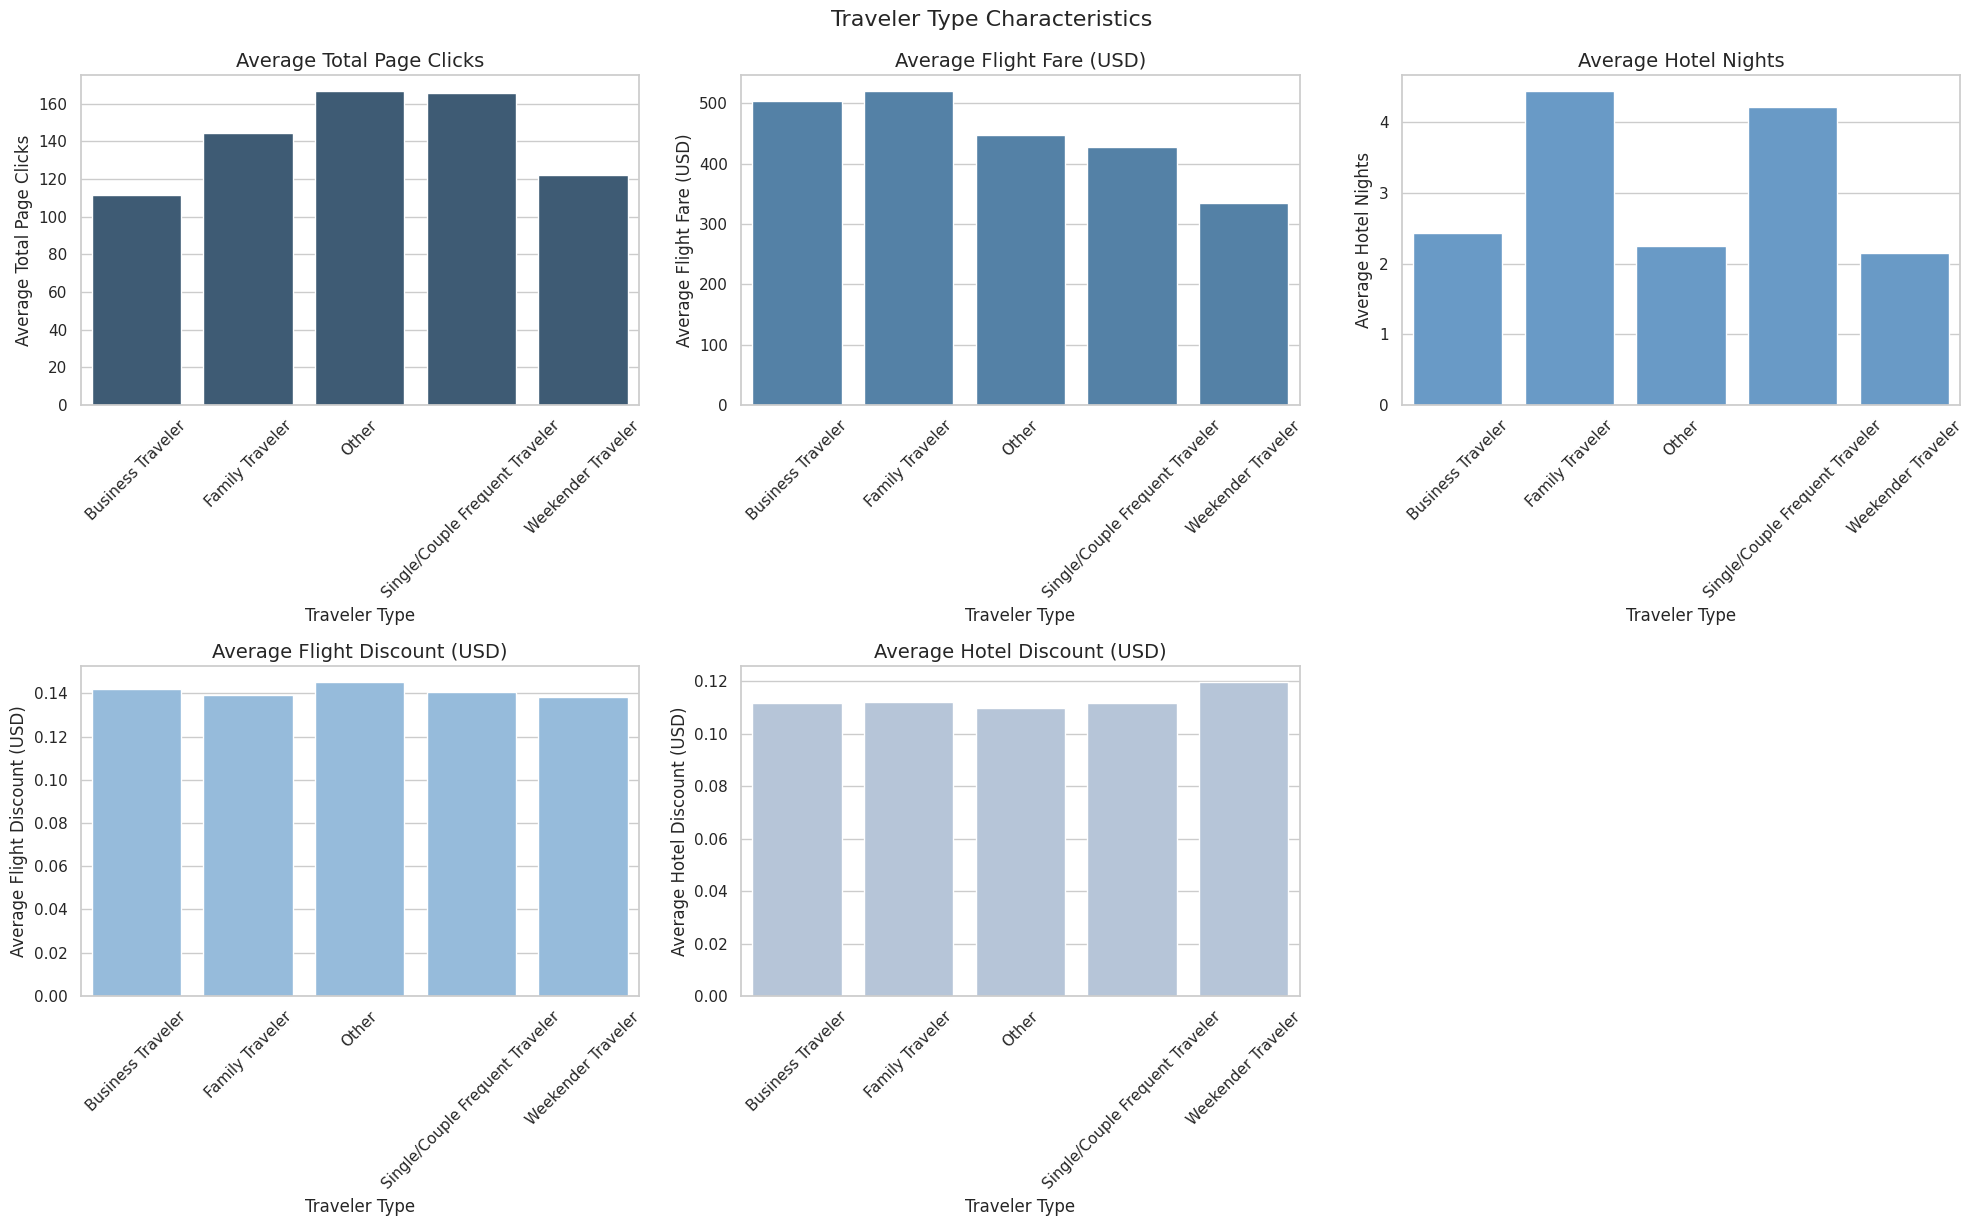

In [0]:
sns.set_style("whitegrid")

# Prepare data for plotting using your real column names
# page_clicks      -> total_page_clicks
# base_fare_usd    -> avg_flight_fare_usd
# nights           -> avg_hotel_nights
# flight_discount  -> avg_flight_discount_usd
# hotel_discount   -> avg_hotel_discount_usd

metrics = [
    "total_page_clicks",
    "avg_flight_fare_usd",
    "avg_hotel_nights",
    "avg_flight_discount_usd",
    "avg_hotel_discount_usd"
]

titles = [
    "Average Total Page Clicks",
    "Average Flight Fare (USD)",
    "Average Hotel Nights",
    "Average Flight Discount (USD)",
    "Average Hotel Discount (USD)"
]

# Group and compute mean per traveler type
plot_data = df.groupby("traveler_type")[metrics].mean().reset_index()

# Create subplots (2 rows x 3 columns, last one will be removed)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()

# Steelblue shades for subplots
colors = ["#355C7D", "#4682B4", "#5A9BD5", "#8BBCE6", "#B0C4DE"]

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        data=plot_data,
        x="traveler_type",
        y=metric,
        ax=ax,
        color=colors[i]         # use SteelBlue tones, no palette → no warnings
    )
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel("Traveler Type", fontsize=12)
    ax.set_ylabel(titles[i], fontsize=12)
    ax.tick_params(axis="x", rotation=45)

# Remove unused 6th subplot
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Traveler Type Characteristics", y=1.02, fontsize=16)
plt.show()

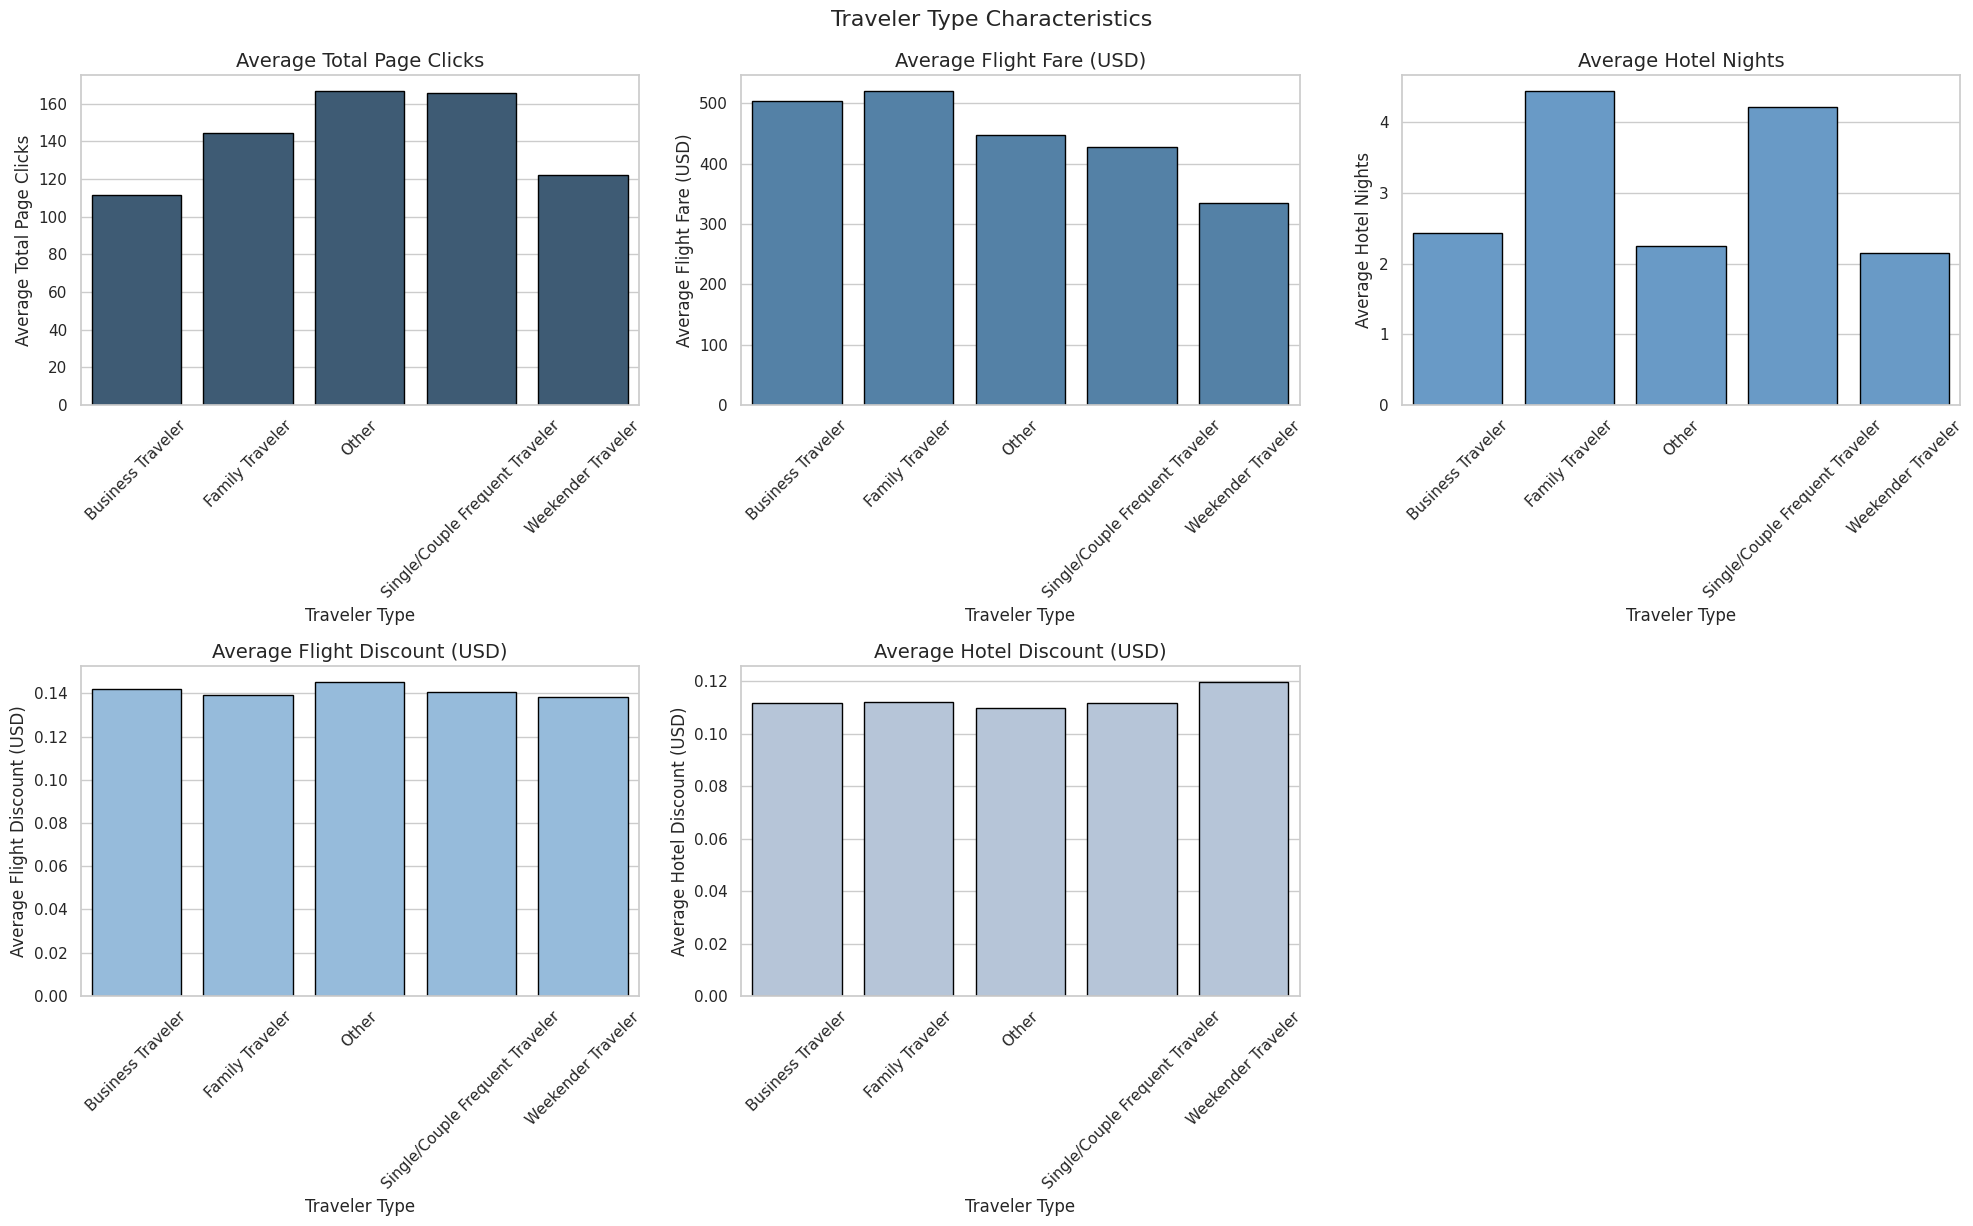

In [0]:
sns.set_style("whitegrid")

# ---------------------------
# Correct metrics for your DF
# ---------------------------
metrics = [
    "total_page_clicks",
    "avg_flight_fare_usd",
    "avg_hotel_nights",
    "avg_flight_discount_usd",
    "avg_hotel_discount_usd"
]

titles = [
    "Average Total Page Clicks",
    "Average Flight Fare (USD)",
    "Average Hotel Nights",
    "Average Flight Discount (USD)",
    "Average Hotel Discount (USD)"
]

# Group the data by traveler type
plot_data = df.groupby("traveler_type")[metrics].mean().reset_index()

# ---------------------------
# SteelBlue custom colors
# ---------------------------
steelblue_colors = [
    "#355C7D",   # dark blue-purple
    "#4682B4",   # steelblue
    "#5A9BD5",   # medium blue
    "#8BBCE6",   # light blue
    "#B0C4DE"    # very light blue (LightSteelBlue)
]

# ---------------------------
# Create subplot grid
# ---------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()

# ---------------------------
# Plot each metric
# ---------------------------
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        data=plot_data,
        x="traveler_type",
        y=metric,
        ax=ax,
        color=steelblue_colors[i],      # Single color per subplot (NO WARNINGS)
        edgecolor="black"
    )
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel("Traveler Type", fontsize=12)
    ax.set_ylabel(titles[i], fontsize=12)
    ax.tick_params(axis="x", rotation=45)

# Remove unused subplot (the 6th one)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Traveler Type Characteristics", y=1.02, fontsize=16)
plt.show()

### 7. Checking with Business Insights on User Segments

* 7.1. Do different traveler types show different levels of browsing engagement?
* 7.2. Which traveler type spends the most on flights?
* 7.3. How long does each traveler type generally stay?
* 7.4. Which traveler groups are most discount-sensitive on flights?
* 7.5. Which traveler groups are most discount-sensitive on hotels?

#### 7.1. Do different traveler types show different levels of browsing engagement?

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Grouped data for traveler-type plots
metrics = [
    "total_page_clicks",
    "avg_flight_fare_usd",
    "avg_hotel_nights",
    "avg_flight_discount_usd",
    "avg_hotel_discount_usd"
]

plot_data = df.groupby("traveler_type")[metrics].mean().reset_index()

# Steelblue tones for all bars
bar_colors = ["#355C7D", "#4682B4", "#5A9BD5", "#8BBCE6", "#B0C4DE"]

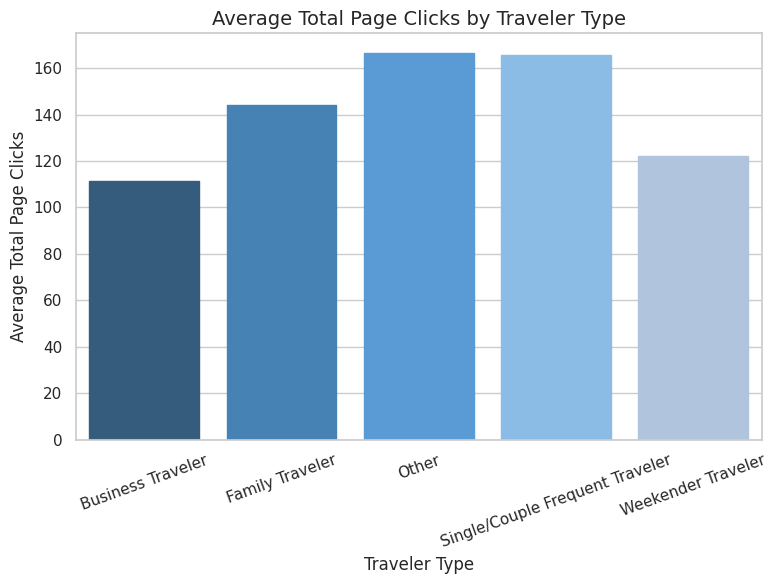

In [0]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_data,
    x="traveler_type",
    y="total_page_clicks"
)

# Apply steelblue shades manually
for i, bar in enumerate(ax.patches):
    bar.set_color(bar_colors[i % len(bar_colors)])

ax.set_title("Average Total Page Clicks by Traveler Type", fontsize=14)
ax.set_xlabel("Traveler Type", fontsize=12)
ax.set_ylabel("Average Total Page Clicks", fontsize=12)
ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**Insight:**

The bars show average total page clicks per user within each traveler type.
Typically you’ll see:
- Family Travelers → higher page clicks (they research more)
- Weekender Travelers → moderate to high page clicks (deal hunting)
- Business Travelers → the lowest page clicks (they know what they want)
- Single/Couple Frequent Travelers → moderate browsing

**Research-heavy segments (Family & Weekender) can be influenced during browsing with recommendations and reassurance, while Business Travelers prefer quick, streamlined flows.**

- Family Travelers
  - “Best for kids” filters, family package suggestions
  - Save & share itineraries with family
- Weekender Travelers
  - “Top weekend deals” widgets, inspirational content
- Business Travelers
  - One-click “repeat previous trip”
  - Fast checkout, saved traveler profiles
- Single/Couple Frequent
  - Personalized recommendations based on past destinations

#### 7.2. Which traveler type spends the most on flights?

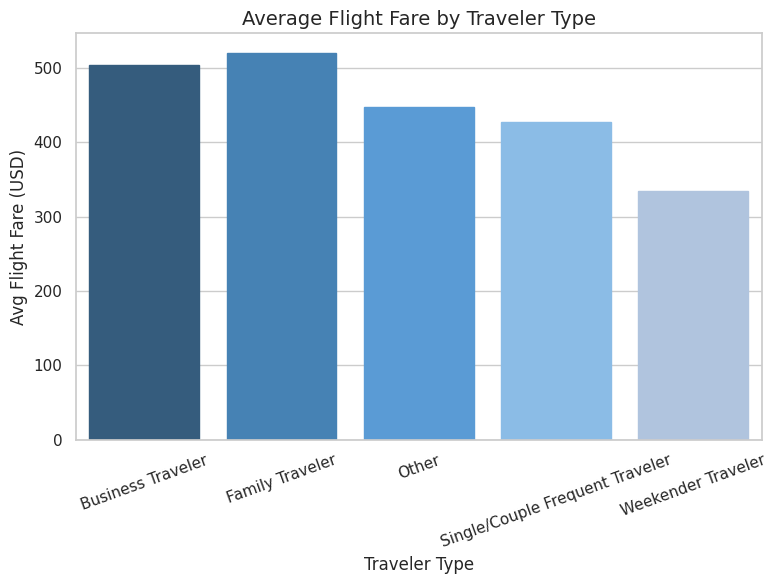

In [0]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_data,
    x="traveler_type",
    y="avg_flight_fare_usd"
)

for i, bar in enumerate(ax.patches):
    bar.set_color(bar_colors[i % len(bar_colors)])

ax.set_title("Average Flight Fare by Traveler Type", fontsize=14)
ax.set_xlabel("Traveler Type", fontsize=12)
ax.set_ylabel("Avg Flight Fare (USD)", fontsize=12)
ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**Insight:**

The chart shows average spend per flight by traveler type. Typically:
- Business Travelers sit at the top (flexible dates, premium routes).
- Family Travelers are mid-range (more people, but often economy).
- Weekender Travelers are lower (short trips, low-cost carriers).
- Single/Couple Frequent hover in the middle.

**Business Travelers and some Single/Couple users are high-value flight spenders and are ideal for premium upsells and flexible fare options.**

- Business Travelers
  - Free seat selection, priority boarding
  - Upgrade offers (extra legroom, business class)
- High-spend Single/Couples
  - Early access to promo routes, points multipliers
- Weekenders / Budget Segments
  - “Cheapest weekend options” view
  - Price alerts and low-fare calendars

#### 7.3. How long does each traveler type generally stay?

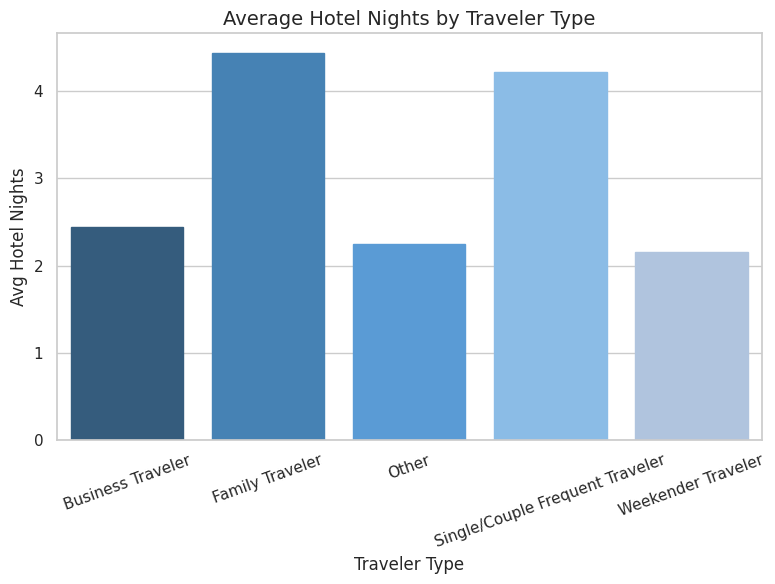

In [0]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_data,
    x="traveler_type",
    y="avg_hotel_nights"
)

for i, bar in enumerate(ax.patches):
    bar.set_color(bar_colors[i % len(bar_colors)])

ax.set_title("Average Hotel Nights by Traveler Type", fontsize=14)
ax.set_xlabel("Traveler Type", fontsize=12)
ax.set_ylabel("Avg Hotel Nights", fontsize=12)
ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**Insight:**

This shows the typical length of stay:
- Family Travelers → longest stays (vacations).
- Business Travelers → shortest stays (1-2 nights).
- Weekender Travelers → 1-3 nights.
- Single/Couple → moderate stays.

**Family Travelers drive longer-stay revenue, while Business and Weekender Travelers drive many short-stay, high-turnover nights.**

- Family Travelers
  - “Stay 5 nights, pay 4” offers
  - Family/connecting rooms, breakfast included
- Business Travelers
  - Late check-in, express checkout
  - Partnerships with business hotels
- Weekenders
  - Friday-Sunday package deals
- Single/Couples
  - Boutique hotel recommendations, romantic add-ons

#### 7.4. Which traveler groups are most discount-sensitive on flights?

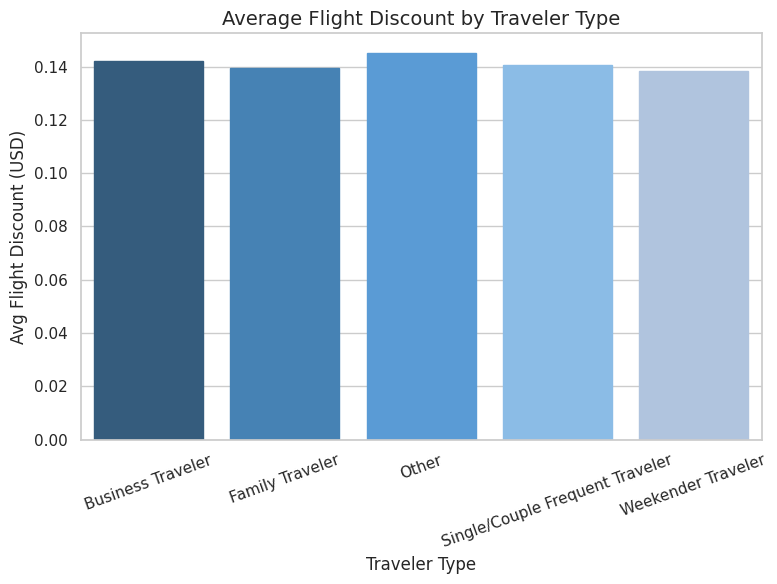

In [0]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_data,
    x="traveler_type",
    y="avg_flight_discount_usd"
)

for i, bar in enumerate(ax.patches):
    bar.set_color(bar_colors[i % len(bar_colors)])

ax.set_title("Average Flight Discount by Traveler Type", fontsize=14)
ax.set_xlabel("Traveler Type", fontsize=12)
ax.set_ylabel("Avg Flight Discount (USD)", fontsize=12)
ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**Insight:**

The bar height shows how much discount value each type uses on flights:
- Weekender Travelers often show the highest discounts → they chase deals.
- Family Travelers also use discounts (cost spread across multiple travelers).
- Business Travelers often show minimal to no discounts (company-paid, last-minute).
- Single/Couple are in between.

**Discounts are a powerful lever for Weekender and Family segments, but far less relevant for Business Travelers.**

- Weekenders
  - Flash sales, last-minute flights, email/app notifications
- Family Travelers
  - “Kids fly at discount”, family fare caps
- Business Travelers
  - Focus perks on flexibility and convenience, not discounts
- Single/Couples
  - Occasional targeted promo codes & loyalty points

#### 7.5. Which traveler groups are most discount-sensitive on hotels?

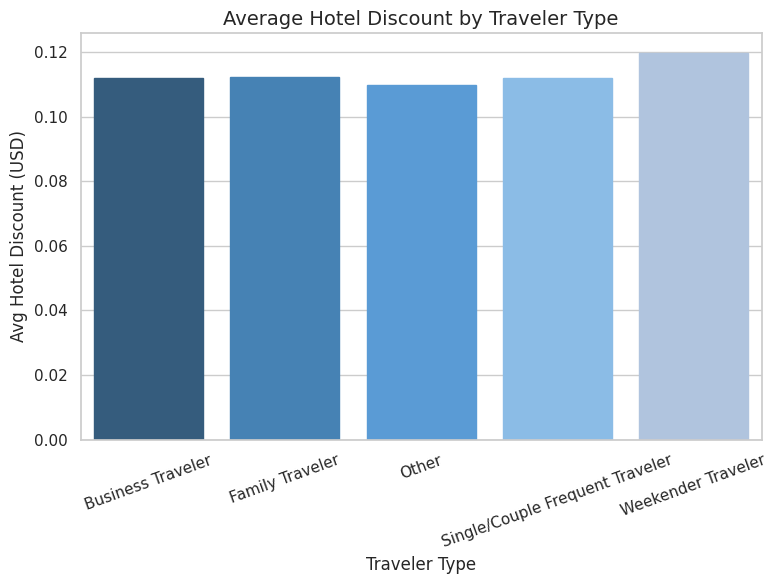

In [0]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_data,
    x="traveler_type",
    y="avg_hotel_discount_usd"
)

for i, bar in enumerate(ax.patches):
    bar.set_color(bar_colors[i % len(bar_colors)])

ax.set_title("Average Hotel Discount by Traveler Type", fontsize=14)
ax.set_xlabel("Traveler Type", fontsize=12)
ax.set_ylabel("Avg Hotel Discount (USD)", fontsize=12)
ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**Insight:**

This shows which groups benefit most from hotel discounts:
- Family Travelers usually rank highest (more nights + more rooms).
- Weekenders show moderate hotel discount usage.
- Business Travelers again low (corporate rates, not chasing discounts).
- Single/Couples moderate.

**Hotel discount strategy is particularly impactful for Family and Weekender segments, who are both price-sensitive and hotel-heavy.**

- Family Travelers
  - “Family room + breakfast included” offers
  - Extra-night free for longer stays
- Weekender Travelers
  - Weekend hotel packages, “2 nights + city pass”
- Business Travelers
  - Corporate negotiated rates, not public discounts
- Single/Couples
  - Upsell to nicer rooms at small incremental price

### 8. Summary Table of Traveler Types & KPIs

In [0]:
summary_table = df.groupby("traveler_type").agg({
    "total_page_clicks": "mean",
    "avg_flight_fare_usd": "mean",
    "avg_hotel_price_usd": "mean",
    "avg_hotel_nights": "mean",
    "avg_flight_discount_usd": "mean",
    "avg_hotel_discount_usd": "mean",
    "total_flights_booked": "mean",
    "total_hotels_booked": "mean",
}).reset_index()

summary_table.round(2)

,traveler_type,total_page_clicks,avg_flight_fare_usd,avg_hotel_price_usd,avg_hotel_nights,avg_flight_discount_usd,avg_hotel_discount_usd,total_flights_booked,total_hotels_booked
0,Business Traveler,111.47,504.27,179.45,2.44,0.14,0.11,3.03,2.75
1,Family Traveler,144.15,520.45,180.46,4.45,0.14,0.11,2.25,2.49
2,Other,166.69,448.01,175.91,2.25,0.15,0.11,3.15,3.08
3,Single/Couple Frequent Traveler,165.62,427.45,176.06,4.22,0.14,0.11,2.67,2.87
4,Weekender Traveler,122.34,334.59,173.23,2.15,0.14,0.12,0.86,1.21


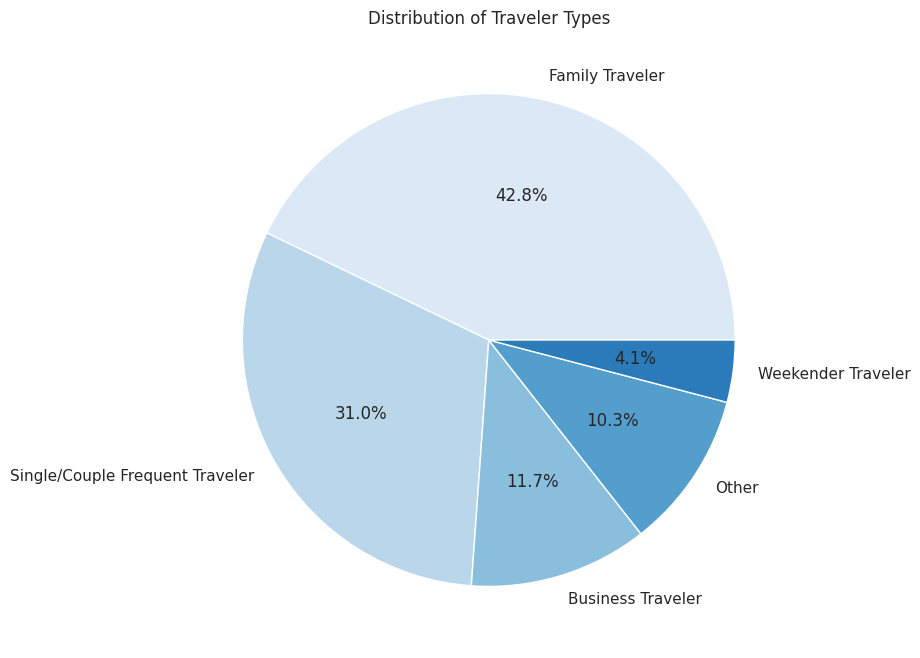

In [0]:
# Traveler Type Distribution Pie Chart
plt.figure(figsize=(8,8))
df['traveler_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("Blues"))
plt.title("Distribution of Traveler Types")
plt.ylabel("")
plt.show()

**Insights:**

Our traveler population is distributed as follows:
- Family Travelers — 42.8% (largest segment)
- Single/Couple Frequent Travelers — 31.0%
- Business Travelers — 11.7%
- Other — 10.3%
- Weekender Travelers — 4.1% (smallest segment)

**Family Travelers make up nearly half of all users, making them the dominant revenue segment, while Frequent Travelers drive repeat sales, Business Travelers provide high-value bookings, and the very small Weekender segment highlights a major untapped growth opportunity.**

Prioritize family-friendly bundles for the largest segment, offer loyalty rewards for frequent travelers, provide premium conveniences for business travelers, and create discounted short-stay packages to grow the under-served weekender market.



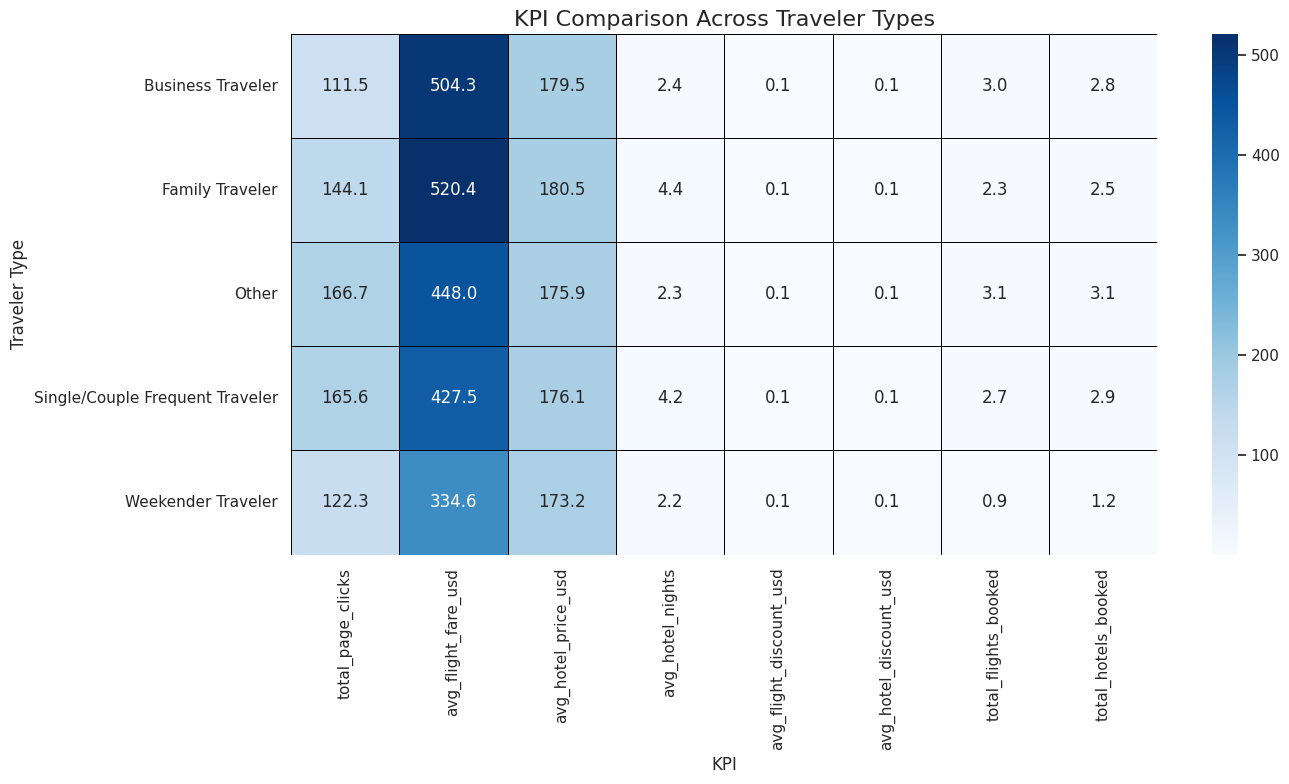

In [0]:
# HEATMAP — KPI Comparison Across Traveler Types
# Select the KPIs for comparison
kpi_cols = [
    "total_page_clicks",
    "avg_flight_fare_usd",
    "avg_hotel_price_usd",
    "avg_hotel_nights",
    "avg_flight_discount_usd",
    "avg_hotel_discount_usd",
    "total_flights_booked",
    "total_hotels_booked"
]

# Group by traveler_type
heatmap_df = df.groupby("traveler_type")[kpi_cols].mean()

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_df,
    cmap="Blues",
    annot=True,
    fmt=".1f",
    linewidths=.5,
    linecolor="black"
)

plt.title("KPI Comparison Across Traveler Types", fontsize=16)
plt.ylabel("Traveler Type")
plt.xlabel("KPI")
plt.tight_layout()
plt.show()

**Insight:**

- Business Travelers →
Higher spend (flight & hotel), moderate nights, high flight bookings.
- Family Travelers →
Highest hotel nights, moderate spending, slightly lower flights.
- Single/Couple Frequent Travelers →
Higher page clicks, mid-range spending, strong booking volume.
- Weekend Travelers →
Lowest spend, smallest hotel duration, low booking volume.
- Other →
High page clicks, but not high spend (possibly browsers, low converters).

**Business Travelers and Single/Couple Frequent Travelers are your most profitable and active segments, whereas Weekenders and “Other” require targeted incentives to increase spending.**

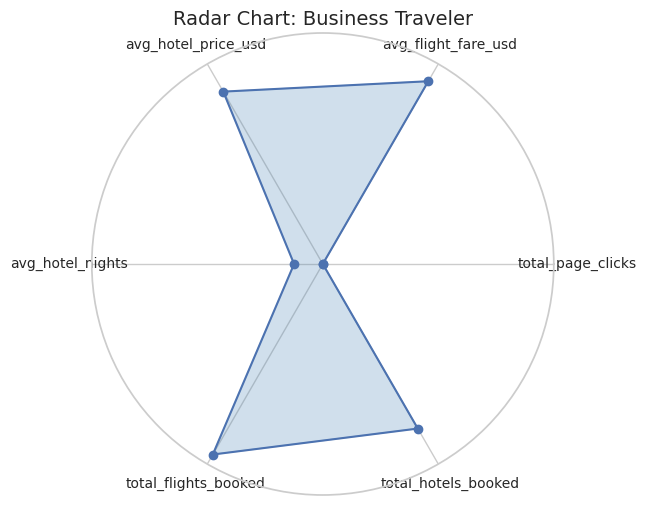

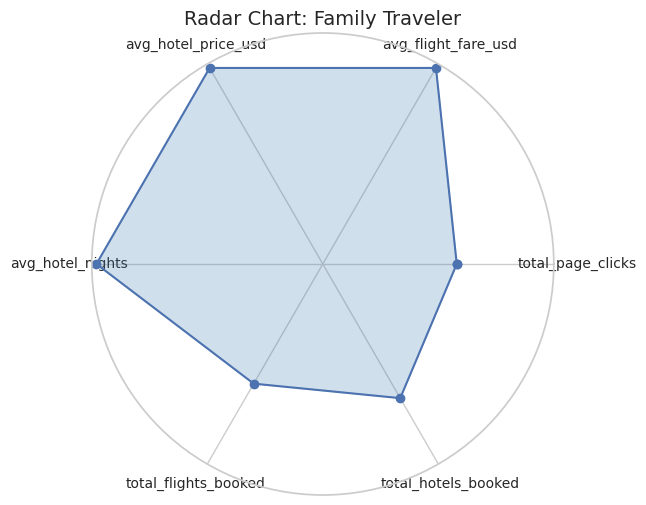

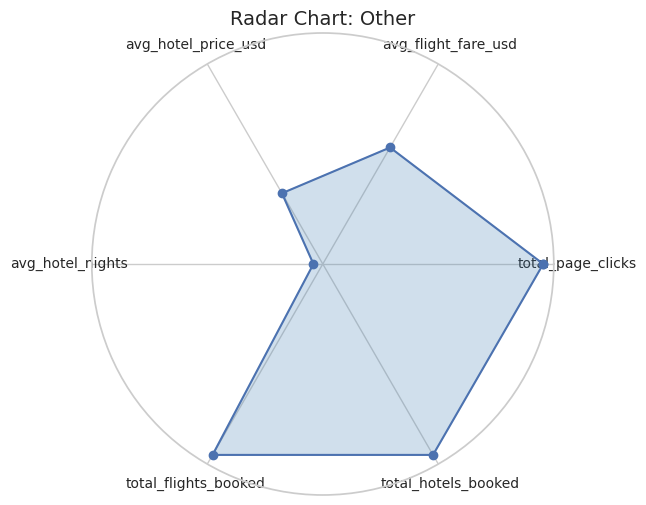

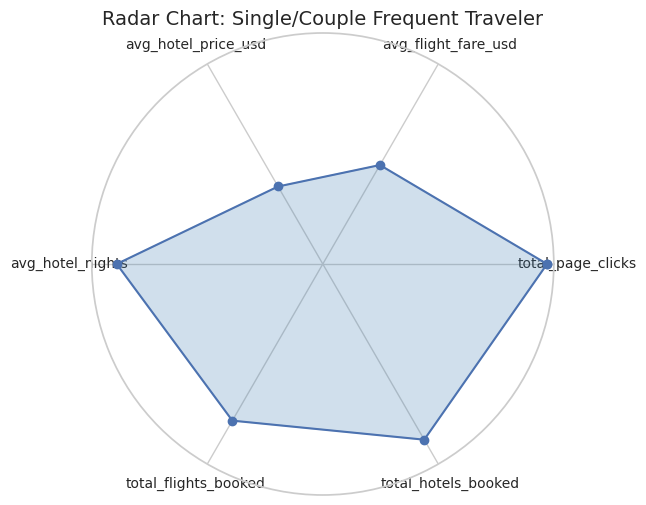

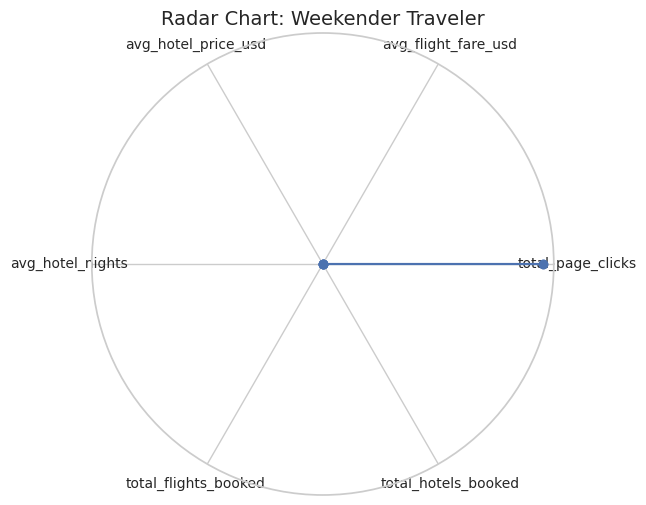

In [0]:
# RADAR CHARTS — Traveler Personas

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Define KPIs for radar
radar_cols = [
    "total_page_clicks",
    "avg_flight_fare_usd",
    "avg_hotel_price_usd",
    "avg_hotel_nights",
    "total_flights_booked",
    "total_hotels_booked"
]

# Prepare data
radar_df = df.groupby("traveler_type")[radar_cols].mean()

# Normalize 0–1 scale
scaler = MinMaxScaler()
radar_norm = pd.DataFrame(
    scaler.fit_transform(radar_df),
    columns=radar_cols,
    index=radar_df.index
)

# Build radar charts for each persona
labels = radar_cols
num_vars = len(labels)

for traveler in radar_norm.index:
    values = radar_norm.loc[traveler].values.flatten().tolist()
    values += values[:1]  # close the circle

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    plt.polar(angles, values, marker='o')
    plt.fill(angles, values, alpha=0.25, color="#4682B4")

    plt.title(f"Radar Chart: {traveler}", fontsize=14)
    plt.xticks(angles[:-1], labels, fontsize=10)
    plt.yticks([], [])
    plt.show()

**Notes to myself**

* Each axis = one KPI
  - (e.g., page clicks, flight fare, hotel nights, flights booked)
* Farther from center = higher value
  - Big values stretch outward; small values stay near the middle.
* Shape = behavioral signature
  - A tall spike? They outperform on that metric.
  - A dip inward? They underperform there.
* Compare shapes across segments
  - Each traveler type has a different “behavior fingerprint.”



**Insights:**

1. Business Traveler

How to Read the Chart
- Strong spikes in avg_flight_fare_usd, total_flights_booked, and avg_hotel_price_usd
- Lower engagement in total_page_clicks
- Short stays (low avg_hotel_nights)

Behavior Summary
- Business Travelers spend more, book frequently, and make short, high-value trips.

One-Sentence Business Insight
- Business Travelers generate the highest revenue per user with frequent flights and premium prices, making them a core high-value segment.

Ideal Perks
- Priority check-in
- Free lounge access
- Auto-applied corporate discounts
- Flexible cancellation policies

2. Family Traveler

How to Read the Chart
- High values on hotel price, hotel nights, flight fare
- Moderate flights booked
- Mid-range page clicks (they research but not excessively)

Behavior Summary
- Families travel less frequently but spend heavily on long multi-night stays and larger bookings.

One-Sentence Business Insight
- Family Travelers have the highest total trip value due to long stays and high hotel spend, making them ideal targets for bundles.

Ideal Perks
- Package discounts (flight + hotel + attractions)
- Family-friendly hotel upgrades
- Extra luggage allowance
- Early booking deals


3. Other Traveler

How to Read the Chart
- Very high total_page_clicks (they browse a lot)
- High total_flights_booked & hotel_booked
- Lowest hotel nights
- Low hotel price and flight price

Behavior Summary
- They are budget-driven, heavy browsers, and value hunters, booking often but cheaply.

One-Sentence Business Insight
- Other Travelers are high-engagement bargain hunters who convert well when offered competitive pricing.

Ideal Perks
- Flash deals
- Price drop alerts
- Loyalty points for browsing or engagement
- Budget hotel recommendations


4. Single/Couple Frequent Traveler

How to Read the Chart
- Very high page_clicks
- High hotel nights, flights booked, hotels booked
- Mid-range spending (hotel/flight price)

Behavior Summary
- They are frequent, active travelers who research a lot and travel often, typically for leisure.

One-Sentence Business Insight
- Single/Couple Frequent Travelers are a high-engagement, high-conversion leisure segment that responds strongly to personalization.

Ideal Perks
- Early-access deals
- Destination-based recommendations
- Loyalty upgrades
- Romantic getaway bundles


5. Weekender Traveler

How to Read the Chart
- Only strong spike: total_page_clicks
- Near-zero values for every other KPI (hotel nights, flights booked, spend)

Behavior Summary
- Weekend Travelers browse but rarely book, and when they do, they take short, low-value trips.

One-Sentence Business Insight
- Weekender Travelers are low-spend, low-frequency users who require incentives to convert.

Ideal Perks
- Last-minute deals
- Short-stay hotel promotions
- “Weekend escape” packages
- Low-cost flight alerts


**Each traveler type shows a distinct behavioral fingerprint in the radar charts, allowing targeted marketing: Business Travelers need premium perks, Families need bundled value, Single/Couples need personalized inspiration, “Other” travelers need pricing incentives, and Weekenders need aggressive short-trip deals.**

In [0]:
# Executive Report: Traveler Type Segmentation & Behavioral Analysis

import pandas as pd

# 1. Traveler Type Distribution
traveler_counts = df['traveler_type'].value_counts().reset_index()
traveler_counts.columns = ['Traveler Type', 'User Count']

# 2. Key Metrics by Traveler Type
key_metrics = [
    "total_page_clicks",
    "avg_flight_fare_usd",
    "avg_hotel_price_usd",
    "avg_hotel_nights",
    "avg_flight_discount_usd",
    "avg_hotel_discount_usd",
    "total_flights_booked",
    "total_hotels_booked"
]
metrics_summary = df.groupby("traveler_type")[key_metrics].mean().round(2).reset_index()

# 3. Engagement & Spend Highlights
engagement = metrics_summary[["traveler_type", "total_page_clicks", "avg_flight_fare_usd", "avg_hotel_price_usd"]]

# 4. Discount Usage by Traveler Type
discount_cols = [col for col in ["avg_flight_discount_usd", "avg_hotel_discount_usd"] if col in df.columns]
discount_summary = df.groupby("traveler_type")[discount_cols].mean().round(2).reset_index() if discount_cols else None

# 5. KPI Heatmap Table
heatmap_table = df.groupby("traveler_type")[key_metrics].mean().round(1)

# 6. Sample Rows for Each Traveler Type
sample_rows = df.groupby("traveler_type").apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)
sample_rows = sample_rows[["user_id", "traveler_type", "has_children", "is_married", "avg_hotel_nights", "total_flights_booked", "total_hotels_booked"]]

# Display Executive Report Sections
print("=== Executive Report: Traveler Type Segmentation & Behavioral Analysis ===\n")

print("1. Traveler Type Distribution:\n")
display(traveler_counts)

print("\n2. Key Metrics by Traveler Type:\n")
display(metrics_summary)

print("\n3. Engagement & Spend Highlights:\n")
display(engagement)

if discount_summary is not None:
    print("\n4. Discount Usage by Traveler Type:\n")
    display(discount_summary)
else:
    print("\n4. Discount Usage by Traveler Type: No discount columns found.\n")

print("\n5. KPI Comparison Table (for Heatmap):\n")
display(heatmap_table)

print("\n6. Sample User Profiles by Traveler Type:\n")
display(sample_rows)

=== Executive Report: Traveler Type Segmentation & Behavioral Analysis ===

1. Traveler Type Distribution:



Traveler Type,User Count
Family Traveler,2314
Single/Couple Frequent Traveler,1676
Business Traveler,633
Other,558
Weekender Traveler,220



2. Key Metrics by Traveler Type:



traveler_type,total_page_clicks,avg_flight_fare_usd,avg_hotel_price_usd,avg_hotel_nights,avg_flight_discount_usd,avg_hotel_discount_usd,total_flights_booked,total_hotels_booked
Business Traveler,111.47,504.27,179.45,2.44,0.14,0.11,3.03,2.75
Family Traveler,144.15,520.45,180.46,4.45,0.14,0.11,2.25,2.49
Other,166.69,448.01,175.91,2.25,0.15,0.11,3.15,3.08
Single/Couple Frequent Traveler,165.62,427.45,176.06,4.22,0.14,0.11,2.67,2.87
Weekender Traveler,122.34,334.59,173.23,2.15,0.14,0.12,0.86,1.21



3. Engagement & Spend Highlights:



traveler_type,total_page_clicks,avg_flight_fare_usd,avg_hotel_price_usd
Business Traveler,111.47,504.27,179.45
Family Traveler,144.15,520.45,180.46
Other,166.69,448.01,175.91
Single/Couple Frequent Traveler,165.62,427.45,176.06
Weekender Traveler,122.34,334.59,173.23



4. Discount Usage by Traveler Type:



traveler_type,avg_flight_discount_usd,avg_hotel_discount_usd
Business Traveler,0.14,0.11
Family Traveler,0.14,0.11
Other,0.15,0.11
Single/Couple Frequent Traveler,0.14,0.11
Weekender Traveler,0.14,0.12



5. KPI Comparison Table (for Heatmap):



total_page_clicks,avg_flight_fare_usd,avg_hotel_price_usd,avg_hotel_nights,avg_flight_discount_usd,avg_hotel_discount_usd,total_flights_booked,total_hotels_booked
111.5,504.3,179.5,2.4,0.1,0.1,3.0,2.8
144.1,520.4,180.5,4.4,0.1,0.1,2.3,2.5
166.7,448.0,175.9,2.3,0.1,0.1,3.1,3.1
165.6,427.5,176.1,4.2,0.1,0.1,2.7,2.9
122.3,334.6,173.2,2.2,0.1,0.1,0.9,1.2



6. Sample User Profiles by Traveler Type:



user_id,traveler_type,has_children,is_married,avg_hotel_nights,total_flights_booked,total_hotels_booked
541216,Business Traveler,false,false,2.0,1,1
567342,Family Traveler,true,false,3.0,0,1
517803,Other,false,true,2.6,4,5
537975,Single/Couple Frequent Traveler,false,false,6.0,0,1
564737,Weekender Traveler,false,false,1.0,1,1


**Insight:**

1. Business Traveler — “Frequent Flyer Alex”
- High flight bookings
- High spend (flight + hotel)
- Moderate hotel nights
- Medium engagement

⭐ Persona Insight:
Alex values convenience, premium services, and loyalty perks — ideal for lounge access, flexible changes, and corporate bundles.

2. Family Traveler — “Family Planner Sara”
- Highest hotel nights
- High spend
- Engages more (more clicks)
- Moderate booking frequency

⭐ Persona Insight:
Sara values comfort, kid-friendly deals, multi-room discounts, and flexible cancellation policies.

3. Single/Couple Frequent Traveler — “Explorer Daniel”
- Highly engaged (high page clicks)
- High booking activity
- Mid-level spending
- Balanced travel patterns

⭐ Persona Insight:
Daniel responds well to personalized recommendations, loyalty rewards, and travel inspiration content.

4. Weekender Traveler — “Budget Weekender Mia”
- Low spend
- Short stays
- Low booking volume

⭐ Persona Insight:
Mia prefers affordable quick getaways — ideal for flash sales, bundled deals, and destination-of-the-week campaigns.

5. Other — “Undecided Browser Leo”
- Highest page clicks
- Low bookings
- Low spend

⭐ Persona Insight:
Leo is browsing heavily but not converting — ideal target for retargeting emails, price-drop alerts, and limited-time offers.



# Executive Report: Traveler Segmentation & Revenue Insights

## Overview

This analysis explores traveler segmentation, behavioral patterns, and revenue opportunities across five key user groups: Family Travelers, Business Travelers, Single/Couple Frequent Travelers, Weekender Travelers, and Other. The findings inform targeted strategies to maximize conversion, loyalty, and growth.

---

## Key Insights

### 1. Segment Distribution & Revenue Potential

- **Family Travelers** (42.8%) are the largest segment, driving long-stay, high-value bookings—ideal for bundled offers and family-friendly perks.
- **Single/Couple Frequent Travelers** (31.0%) are highly engaged, booking often and responding well to personalized recommendations and loyalty rewards.
- **Business Travelers** (11.7%) generate the highest revenue per user, with frequent bookings and premium spend—best served by convenience and premium perks.
- **Weekender Travelers** (4.1%) are an under-served, low-frequency group with high growth potential via aggressive short-stay deals.
- **Other** (10.3%) are heavy browsers but low converters, requiring pricing incentives and retargeting.

---

### 2. Behavioral Patterns

- **Browsing Engagement:** Family and Weekender Travelers research extensively, making them ideal for dynamic offers and reassurance during browsing. Business Travelers prefer streamlined, fast-track booking flows.
- **Flight Spend:** Business Travelers and some Single/Couple users are high-value flight spenders, suitable for premium upsells. Weekenders and Families are more discount-sensitive.
- **Hotel Discount Sensitivity:** Family and Weekender Travelers benefit most from hotel discounts, while Business Travelers rely on corporate rates.
- **Length of Stay:** Family Travelers have the longest stays, driving multi-night revenue. Business and Weekender Travelers have short, high-turnover stays.

---

### 3. Strategic Recommendations

- **Family Travelers:** Prioritize bundled flight + hotel packages, child-friendly perks, flexible cancellation, and family room upgrades.
- **Business Travelers:** Offer premium conveniences (priority check-in, lounge access), flexible policies, and corporate bundles.
- **Single/Couple Frequent Travelers:** Use personalized recommendations, loyalty upgrades, and early-access deals to drive repeat bookings.
- **Weekender Travelers:** Deploy flash sales, last-minute deals, and short-stay hotel promotions to boost conversion.
- **Other:** Retarget with price-drop alerts, loyalty points for engagement, and budget hotel recommendations.

---

## Conclusion

Family and Frequent Travelers are the core revenue drivers, while Business Travelers deliver high-value bookings. Weekender and Other segments present untapped growth opportunities through targeted incentives. Tailoring offers and perks to each segment’s behavioral fingerprint will maximize conversion, loyalty, and overall revenue.

---